In [1]:
from comet_ml import Experiment

In [ ]:
with open("api_key.txt", "r") as f:
    api_key = json.load(f)

In [3]:
hyper_params = {
    "learning_rate": 0.001,
    "IMS_PER_BATCH": 4,
    "GAMMA" : 0.8,
    "FREEZE_AT" : 1,
    'IMS_PER_BATCH' : 4,
    "WARMUP_ITERS" : 10000,
    'SOLVER_STEPS':(40000, 80000, 120000, 200000, 500000)
}

experiment = Experiment(project_name="gun", api_key=api_key['api_key'])
experiment.log_parameters(hyper_params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/michalmiotk/gun/2411205bc28e45dbaebb3f3dd413cbf0



In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("weapons", {}, "/Pobrane/trainval.json", "/Pobrane/images")
register_coco_instances("weapons_test", {}, "/Pobrane/trainval.json", "/Pobrane/images")
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000000})

In [5]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [6]:
dataset_dicts = DatasetCatalog.get("weapons")
glock_metadata = MetadataCatalog.get("weapons")

In [7]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/Pobrane/images/More-weapons-1/table_48621_original.png


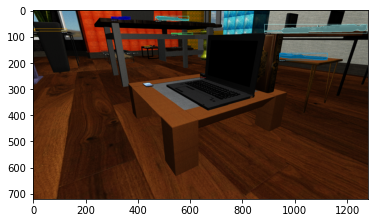

In [8]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=glock_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [9]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [10]:
from datetime import datetime
import os

In [14]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"/glock/tboard_logs/weapons"#_{datetime.now().isoformat().rsplit(':', 1)[0]}/"

cfg.DATASETS.TRAIN = ("weapons",)
cfg.DATASETS.TEST = ("weapons_test",)
cfg.DATALOADER.NUM_WORKERS = 4

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 2
cfg.MODEL.BACKBONE.FREEZE_AT=hyper_params['FREEZE_AT']
# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = hyper_params['IMS_PER_BATCH'] # 32
cfg.SOLVER.BASE_LR = hyper_params['learning_rate'] # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 500_000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS =  hyper_params['WARMUP_ITERS']
cfg.SOLVER.GAMMA = hyper_params['GAMMA']
cfg.SOLVER.STEPS = hyper_params['SOLVER_STEPS']

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 100000_000 
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


In [ ]:
class MyTrainer(DefaultTrainer):
    
view raw

In [ ]:
https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [16]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[11/03 21:45:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/03 21:45:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/03 21:46:08 d2.data.datasets.coco]: Loading /Pobrane/trainval.json takes 10.56 seconds.
[11/03 21:46:08 d2.data.datasets.coco]: Loaded 69988 images in COCO format from /Pobrane/trainval.json
[11/03 21:46:11 d2.data.build]: Removed 0 images with no usable annotations. 69988 images left.
[11/03 21:46:13 d2.data.common]: Serializing 69988 elements to byte tensors and concatenating them all ...
[11/03 21:46:14 d2.data.common]: Serialized dataset takes 269.91 MiB
[11/03 21:46:14 d2.data.build]: Using training sampler TrainingSampler
[11/03 21:46:15 d2.engine.train_loop]: Starting training from iteration 100000
[11/03 21:46:23 d2.utils.events]:  eta: 1 day, 15:39:26  iter: 100019  total_loss: 0.366  loss_cls: 0.04979  loss_box_reg: 0.07848  loss_mask: 0.1618  loss_rpn_cls: 0.0188

[11/03 21:49:32 d2.utils.events]:  eta: 1 day, 13:21:42  iter: 100579  total_loss: 0.4158  loss_cls: 0.04291  loss_box_reg: 0.07182  loss_mask: 0.1591  loss_rpn_cls: 0.01521  loss_rpn_loc: 0.05725  time: 0.3361  data_time: 0.0032  lr: 3e-05  max_mem: 3518M
[11/03 21:49:39 d2.utils.events]:  eta: 1 day, 13:22:18  iter: 100599  total_loss: 0.4434  loss_cls: 0.05719  loss_box_reg: 0.07773  loss_mask: 0.1642  loss_rpn_cls: 0.02182  loss_rpn_loc: 0.07405  time: 0.3363  data_time: 0.0033  lr: 3e-05  max_mem: 3518M
[11/03 21:49:45 d2.utils.events]:  eta: 1 day, 13:22:12  iter: 100619  total_loss: 0.4637  loss_cls: 0.06119  loss_box_reg: 0.07733  loss_mask: 0.174  loss_rpn_cls: 0.01778  loss_rpn_loc: 0.07869  time: 0.3363  data_time: 0.0033  lr: 3e-05  max_mem: 3518M
[11/03 21:49:52 d2.utils.events]:  eta: 1 day, 13:22:05  iter: 100639  total_loss: 0.4466  loss_cls: 0.05491  loss_box_reg: 0.08729  loss_mask: 0.1621  loss_rpn_cls: 0.02236  loss_rpn_loc: 0.08763  time: 0.3363  data_time: 0.0034 

[11/03 21:53:10 d2.utils.events]:  eta: 1 day, 14:14:12  iter: 101199  total_loss: 0.5274  loss_cls: 0.05889  loss_box_reg: 0.1082  loss_mask: 0.196  loss_rpn_cls: 0.02654  loss_rpn_loc: 0.08913  time: 0.3438  data_time: 0.0039  lr: 3e-05  max_mem: 3569M
[11/03 21:53:17 d2.utils.events]:  eta: 1 day, 14:15:55  iter: 101219  total_loss: 0.3956  loss_cls: 0.05578  loss_box_reg: 0.07441  loss_mask: 0.1531  loss_rpn_cls: 0.01794  loss_rpn_loc: 0.04198  time: 0.3440  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 21:53:24 d2.utils.events]:  eta: 1 day, 14:17:54  iter: 101239  total_loss: 0.5062  loss_cls: 0.06763  loss_box_reg: 0.09823  loss_mask: 0.187  loss_rpn_cls: 0.03128  loss_rpn_loc: 0.09929  time: 0.3442  data_time: 0.0038  lr: 3e-05  max_mem: 3569M
[11/03 21:53:31 d2.utils.events]:  eta: 1 day, 14:21:20  iter: 101259  total_loss: 0.4429  loss_cls: 0.04731  loss_box_reg: 0.07405  loss_mask: 0.1803  loss_rpn_cls: 0.01878  loss_rpn_loc: 0.05314  time: 0.3445  data_time: 0.0038  l

[11/03 21:56:46 d2.utils.events]:  eta: 1 day, 14:35:51  iter: 101819  total_loss: 0.3729  loss_cls: 0.03508  loss_box_reg: 0.09464  loss_mask: 0.1717  loss_rpn_cls: 0.01572  loss_rpn_loc: 0.04512  time: 0.3449  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 21:56:52 d2.utils.events]:  eta: 1 day, 14:35:30  iter: 101839  total_loss: 0.4874  loss_cls: 0.07689  loss_box_reg: 0.1004  loss_mask: 0.1838  loss_rpn_cls: 0.02579  loss_rpn_loc: 0.08264  time: 0.3449  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 21:56:59 d2.utils.events]:  eta: 1 day, 14:35:06  iter: 101859  total_loss: 0.498  loss_cls: 0.04721  loss_box_reg: 0.06599  loss_mask: 0.1815  loss_rpn_cls: 0.01883  loss_rpn_loc: 0.1477  time: 0.3448  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 21:57:06 d2.utils.events]:  eta: 1 day, 14:33:34  iter: 101879  total_loss: 0.4296  loss_cls: 0.05708  loss_box_reg: 0.0972  loss_mask: 0.1745  loss_rpn_cls: 0.01841  loss_rpn_loc: 0.07303  time: 0.3448  data_time: 0.0033  lr

[11/03 22:00:21 d2.utils.events]:  eta: 1 day, 14:14:31  iter: 102439  total_loss: 0.4177  loss_cls: 0.06218  loss_box_reg: 0.08826  loss_mask: 0.1836  loss_rpn_cls: 0.01304  loss_rpn_loc: 0.05656  time: 0.3454  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:00:28 d2.utils.events]:  eta: 1 day, 14:14:24  iter: 102459  total_loss: 0.4632  loss_cls: 0.0598  loss_box_reg: 0.1083  loss_mask: 0.2023  loss_rpn_cls: 0.01641  loss_rpn_loc: 0.0536  time: 0.3453  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 22:00:34 d2.utils.events]:  eta: 1 day, 14:11:17  iter: 102479  total_loss: 0.424  loss_cls: 0.04512  loss_box_reg: 0.06535  loss_mask: 0.1853  loss_rpn_cls: 0.01675  loss_rpn_loc: 0.05631  time: 0.3453  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:00:41 d2.utils.events]:  eta: 1 day, 14:10:17  iter: 102499  total_loss: 0.4847  loss_cls: 0.05552  loss_box_reg: 0.06576  loss_mask: 0.1917  loss_rpn_cls: 0.02168  loss_rpn_loc: 0.1154  time: 0.3451  data_time: 0.0034  lr:

[11/03 22:04:11 d2.utils.events]:  eta: 1 day, 15:30:01  iter: 103059  total_loss: 0.5376  loss_cls: 0.07159  loss_box_reg: 0.107  loss_mask: 0.2072  loss_rpn_cls: 0.02778  loss_rpn_loc: 0.1158  time: 0.3503  data_time: 0.0043  lr: 3e-05  max_mem: 3569M
[11/03 22:04:19 d2.utils.events]:  eta: 1 day, 15:38:33  iter: 103079  total_loss: 0.4542  loss_cls: 0.05765  loss_box_reg: 0.08409  loss_mask: 0.1933  loss_rpn_cls: 0.01372  loss_rpn_loc: 0.06212  time: 0.3506  data_time: 0.0041  lr: 3e-05  max_mem: 3569M
[11/03 22:04:26 d2.utils.events]:  eta: 1 day, 15:42:36  iter: 103099  total_loss: 0.5101  loss_cls: 0.06584  loss_box_reg: 0.1004  loss_mask: 0.1808  loss_rpn_cls: 0.02594  loss_rpn_loc: 0.08774  time: 0.3509  data_time: 0.0039  lr: 3e-05  max_mem: 3569M
[11/03 22:04:34 d2.utils.events]:  eta: 1 day, 15:48:16  iter: 103119  total_loss: 0.5252  loss_cls: 0.06222  loss_box_reg: 0.1157  loss_mask: 0.2085  loss_rpn_cls: 0.0195  loss_rpn_loc: 0.09432  time: 0.3512  data_time: 0.0039  lr: 

[11/03 22:08:13 d2.utils.events]:  eta: 1 day, 18:43:48  iter: 103679  total_loss: 0.3209  loss_cls: 0.03994  loss_box_reg: 0.0633  loss_mask: 0.142  loss_rpn_cls: 0.01448  loss_rpn_loc: 0.04177  time: 0.3570  data_time: 0.0042  lr: 3e-05  max_mem: 3569M
[11/03 22:08:21 d2.utils.events]:  eta: 1 day, 18:48:53  iter: 103699  total_loss: 0.4278  loss_cls: 0.0673  loss_box_reg: 0.09817  loss_mask: 0.1545  loss_rpn_cls: 0.01122  loss_rpn_loc: 0.05073  time: 0.3572  data_time: 0.0042  lr: 3e-05  max_mem: 3569M
[11/03 22:08:28 d2.utils.events]:  eta: 1 day, 18:45:13  iter: 103719  total_loss: 0.4688  loss_cls: 0.05653  loss_box_reg: 0.1  loss_mask: 0.1838  loss_rpn_cls: 0.02122  loss_rpn_loc: 0.08496  time: 0.3573  data_time: 0.0040  lr: 3e-05  max_mem: 3569M
[11/03 22:08:36 d2.utils.events]:  eta: 1 day, 18:44:58  iter: 103739  total_loss: 0.4592  loss_cls: 0.05889  loss_box_reg: 0.1051  loss_mask: 0.2107  loss_rpn_cls: 0.01951  loss_rpn_loc: 0.09609  time: 0.3574  data_time: 0.0040  lr: 3e

[11/03 22:12:19 d2.utils.events]:  eta: 1 day, 19:13:48  iter: 104299  total_loss: 0.4517  loss_cls: 0.05166  loss_box_reg: 0.08277  loss_mask: 0.1852  loss_rpn_cls: 0.01714  loss_rpn_loc: 0.05468  time: 0.3625  data_time: 0.0039  lr: 3e-05  max_mem: 3569M
[11/03 22:12:26 d2.utils.events]:  eta: 1 day, 19:11:32  iter: 104319  total_loss: 0.5149  loss_cls: 0.05284  loss_box_reg: 0.09276  loss_mask: 0.1828  loss_rpn_cls: 0.01817  loss_rpn_loc: 0.06857  time: 0.3624  data_time: 0.0033  lr: 3e-05  max_mem: 3569M
[11/03 22:12:33 d2.utils.events]:  eta: 1 day, 19:09:27  iter: 104339  total_loss: 0.6035  loss_cls: 0.08831  loss_box_reg: 0.1122  loss_mask: 0.1641  loss_rpn_cls: 0.01711  loss_rpn_loc: 0.1458  time: 0.3624  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 22:12:40 d2.utils.events]:  eta: 1 day, 19:02:50  iter: 104359  total_loss: 0.6474  loss_cls: 0.0734  loss_box_reg: 0.1044  loss_mask: 0.2054  loss_rpn_cls: 0.03114  loss_rpn_loc: 0.1456  time: 0.3623  data_time: 0.0034  lr:

[11/03 22:16:03 d2.utils.events]:  eta: 1 day, 16:33:49  iter: 104919  total_loss: 0.3628  loss_cls: 0.04593  loss_box_reg: 0.07247  loss_mask: 0.1542  loss_rpn_cls: 0.01733  loss_rpn_loc: 0.04045  time: 0.3623  data_time: 0.0045  lr: 3e-05  max_mem: 3569M
[11/03 22:16:10 d2.utils.events]:  eta: 1 day, 16:29:16  iter: 104939  total_loss: 0.5614  loss_cls: 0.06089  loss_box_reg: 0.1057  loss_mask: 0.166  loss_rpn_cls: 0.01916  loss_rpn_loc: 0.06508  time: 0.3622  data_time: 0.0041  lr: 3e-05  max_mem: 3569M
[11/03 22:16:17 d2.utils.events]:  eta: 1 day, 16:23:45  iter: 104959  total_loss: 0.3932  loss_cls: 0.04214  loss_box_reg: 0.08134  loss_mask: 0.1691  loss_rpn_cls: 0.01089  loss_rpn_loc: 0.04924  time: 0.3622  data_time: 0.0040  lr: 3e-05  max_mem: 3569M
[11/03 22:16:24 d2.utils.events]:  eta: 1 day, 16:14:22  iter: 104979  total_loss: 0.3238  loss_cls: 0.04114  loss_box_reg: 0.06915  loss_mask: 0.1424  loss_rpn_cls: 0.01296  loss_rpn_loc: 0.02667  time: 0.3621  data_time: 0.0040  

[11/03 22:19:45 d2.utils.events]:  eta: 1 day, 14:32:27  iter: 105539  total_loss: 0.4863  loss_cls: 0.06336  loss_box_reg: 0.114  loss_mask: 0.1798  loss_rpn_cls: 0.01534  loss_rpn_loc: 0.07677  time: 0.3618  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:19:52 d2.utils.events]:  eta: 1 day, 14:33:40  iter: 105559  total_loss: 0.5076  loss_cls: 0.05319  loss_box_reg: 0.09061  loss_mask: 0.169  loss_rpn_cls: 0.01598  loss_rpn_loc: 0.06341  time: 0.3617  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 22:19:59 d2.utils.events]:  eta: 1 day, 14:35:13  iter: 105579  total_loss: 0.5708  loss_cls: 0.06728  loss_box_reg: 0.1205  loss_mask: 0.1907  loss_rpn_cls: 0.01788  loss_rpn_loc: 0.1046  time: 0.3616  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 22:20:06 d2.utils.events]:  eta: 1 day, 14:32:06  iter: 105599  total_loss: 0.3459  loss_cls: 0.0461  loss_box_reg: 0.07352  loss_mask: 0.1555  loss_rpn_cls: 0.01208  loss_rpn_loc: 0.04212  time: 0.3616  data_time: 0.0036  lr: 

[11/03 22:23:21 d2.utils.events]:  eta: 1 day, 13:52:27  iter: 106159  total_loss: 0.4965  loss_cls: 0.06274  loss_box_reg: 0.07711  loss_mask: 0.2007  loss_rpn_cls: 0.02228  loss_rpn_loc: 0.07288  time: 0.3603  data_time: 0.0037  lr: 3e-05  max_mem: 3569M
[11/03 22:23:28 d2.utils.events]:  eta: 1 day, 13:49:09  iter: 106179  total_loss: 0.3935  loss_cls: 0.04611  loss_box_reg: 0.0754  loss_mask: 0.1736  loss_rpn_cls: 0.0131  loss_rpn_loc: 0.05845  time: 0.3602  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:23:34 d2.utils.events]:  eta: 1 day, 13:45:17  iter: 106199  total_loss: 0.3863  loss_cls: 0.04324  loss_box_reg: 0.05704  loss_mask: 0.1487  loss_rpn_cls: 0.01424  loss_rpn_loc: 0.04964  time: 0.3602  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 22:23:41 d2.utils.events]:  eta: 1 day, 13:43:24  iter: 106219  total_loss: 0.3605  loss_cls: 0.04798  loss_box_reg: 0.06738  loss_mask: 0.1719  loss_rpn_cls: 0.01258  loss_rpn_loc: 0.04159  time: 0.3601  data_time: 0.0036  

[11/03 22:26:58 d2.utils.events]:  eta: 1 day, 14:02:43  iter: 106779  total_loss: 0.5065  loss_cls: 0.08016  loss_box_reg: 0.09834  loss_mask: 0.1797  loss_rpn_cls: 0.01903  loss_rpn_loc: 0.1432  time: 0.3593  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 22:27:04 d2.utils.events]:  eta: 1 day, 14:01:37  iter: 106799  total_loss: 0.3836  loss_cls: 0.04875  loss_box_reg: 0.085  loss_mask: 0.1501  loss_rpn_cls: 0.01734  loss_rpn_loc: 0.0411  time: 0.3592  data_time: 0.0038  lr: 3e-05  max_mem: 3569M
[11/03 22:27:11 d2.utils.events]:  eta: 1 day, 14:00:13  iter: 106819  total_loss: 0.4528  loss_cls: 0.05604  loss_box_reg: 0.09346  loss_mask: 0.1658  loss_rpn_cls: 0.01613  loss_rpn_loc: 0.06921  time: 0.3591  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 22:27:18 d2.utils.events]:  eta: 1 day, 14:00:58  iter: 106839  total_loss: 0.276  loss_cls: 0.03539  loss_box_reg: 0.06767  loss_mask: 0.1276  loss_rpn_cls: 0.009464  loss_rpn_loc: 0.0299  time: 0.3591  data_time: 0.0038  lr:

[11/03 22:30:32 d2.utils.events]:  eta: 1 day, 13:47:05  iter: 107399  total_loss: 0.402  loss_cls: 0.05037  loss_box_reg: 0.1095  loss_mask: 0.1646  loss_rpn_cls: 0.01524  loss_rpn_loc: 0.05315  time: 0.3581  data_time: 0.0042  lr: 3e-05  max_mem: 3569M
[11/03 22:30:40 d2.utils.events]:  eta: 1 day, 13:48:49  iter: 107419  total_loss: 0.3502  loss_cls: 0.03954  loss_box_reg: 0.06746  loss_mask: 0.1401  loss_rpn_cls: 0.01289  loss_rpn_loc: 0.03457  time: 0.3581  data_time: 0.0042  lr: 3e-05  max_mem: 3569M
[11/03 22:30:48 d2.utils.events]:  eta: 1 day, 13:48:42  iter: 107439  total_loss: 0.3917  loss_cls: 0.0481  loss_box_reg: 0.0823  loss_mask: 0.1709  loss_rpn_cls: 0.01204  loss_rpn_loc: 0.03996  time: 0.3583  data_time: 0.0044  lr: 3e-05  max_mem: 3569M
[11/03 22:30:56 d2.utils.events]:  eta: 1 day, 13:52:09  iter: 107459  total_loss: 0.4333  loss_cls: 0.05296  loss_box_reg: 0.08514  loss_mask: 0.1634  loss_rpn_cls: 0.01483  loss_rpn_loc: 0.09432  time: 0.3583  data_time: 0.0042  lr

[11/03 22:34:25 d2.utils.events]:  eta: 1 day, 15:13:54  iter: 108019  total_loss: 0.4678  loss_cls: 0.06299  loss_box_reg: 0.0889  loss_mask: 0.184  loss_rpn_cls: 0.01623  loss_rpn_loc: 0.09222  time: 0.3594  data_time: 0.0042  lr: 3e-05  max_mem: 3569M
[11/03 22:34:33 d2.utils.events]:  eta: 1 day, 15:25:02  iter: 108039  total_loss: 0.6428  loss_cls: 0.07344  loss_box_reg: 0.1406  loss_mask: 0.216  loss_rpn_cls: 0.02829  loss_rpn_loc: 0.1892  time: 0.3595  data_time: 0.0042  lr: 3e-05  max_mem: 3569M
[11/03 22:34:41 d2.utils.events]:  eta: 1 day, 15:38:03  iter: 108059  total_loss: 0.4134  loss_cls: 0.06127  loss_box_reg: 0.08144  loss_mask: 0.151  loss_rpn_cls: 0.01573  loss_rpn_loc: 0.06981  time: 0.3596  data_time: 0.0040  lr: 3e-05  max_mem: 3569M
[11/03 22:34:49 d2.utils.events]:  eta: 1 day, 15:48:08  iter: 108079  total_loss: 0.4654  loss_cls: 0.04621  loss_box_reg: 0.0793  loss_mask: 0.1909  loss_rpn_cls: 0.01733  loss_rpn_loc: 0.05155  time: 0.3597  data_time: 0.0042  lr: 3

[11/03 22:38:21 d2.utils.events]:  eta: 1 day, 17:31:01  iter: 108639  total_loss: 0.6089  loss_cls: 0.06322  loss_box_reg: 0.1123  loss_mask: 0.1782  loss_rpn_cls: 0.02271  loss_rpn_loc: 0.1448  time: 0.3608  data_time: 0.0041  lr: 3e-05  max_mem: 3569M
[11/03 22:38:29 d2.utils.events]:  eta: 1 day, 17:36:51  iter: 108659  total_loss: 0.4613  loss_cls: 0.05911  loss_box_reg: 0.0979  loss_mask: 0.1782  loss_rpn_cls: 0.0154  loss_rpn_loc: 0.06557  time: 0.3609  data_time: 0.0040  lr: 3e-05  max_mem: 3569M
[11/03 22:38:37 d2.utils.events]:  eta: 1 day, 17:37:26  iter: 108679  total_loss: 0.3776  loss_cls: 0.04722  loss_box_reg: 0.07154  loss_mask: 0.1747  loss_rpn_cls: 0.01635  loss_rpn_loc: 0.06562  time: 0.3610  data_time: 0.0042  lr: 3e-05  max_mem: 3569M
[11/03 22:38:45 d2.utils.events]:  eta: 1 day, 17:42:37  iter: 108699  total_loss: 0.5099  loss_cls: 0.06414  loss_box_reg: 0.09672  loss_mask: 0.1833  loss_rpn_cls: 0.01829  loss_rpn_loc: 0.1182  time: 0.3610  data_time: 0.0042  lr:

[11/03 22:42:14 d2.utils.events]:  eta: 1 day, 16:12:23  iter: 109259  total_loss: 0.4197  loss_cls: 0.05131  loss_box_reg: 0.08171  loss_mask: 0.1717  loss_rpn_cls: 0.01872  loss_rpn_loc: 0.0407  time: 0.3618  data_time: 0.0039  lr: 3e-05  max_mem: 3569M
[11/03 22:42:21 d2.utils.events]:  eta: 1 day, 16:05:59  iter: 109279  total_loss: 0.2869  loss_cls: 0.04396  loss_box_reg: 0.0586  loss_mask: 0.1246  loss_rpn_cls: 0.01399  loss_rpn_loc: 0.01637  time: 0.3618  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:42:28 d2.utils.events]:  eta: 1 day, 16:00:51  iter: 109299  total_loss: 0.3937  loss_cls: 0.05123  loss_box_reg: 0.07631  loss_mask: 0.1626  loss_rpn_cls: 0.01552  loss_rpn_loc: 0.07711  time: 0.3618  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:42:35 d2.utils.events]:  eta: 1 day, 15:58:48  iter: 109319  total_loss: 0.4307  loss_cls: 0.05447  loss_box_reg: 0.1076  loss_mask: 0.177  loss_rpn_cls: 0.01085  loss_rpn_loc: 0.06458  time: 0.3617  data_time: 0.0036  lr

[11/03 22:45:56 d2.utils.events]:  eta: 1 day, 15:31:19  iter: 109879  total_loss: 0.4179  loss_cls: 0.04778  loss_box_reg: 0.09507  loss_mask: 0.1619  loss_rpn_cls: 0.01408  loss_rpn_loc: 0.04748  time: 0.3615  data_time: 0.0037  lr: 3e-05  max_mem: 3569M
[11/03 22:46:03 d2.utils.events]:  eta: 1 day, 15:27:03  iter: 109899  total_loss: 0.426  loss_cls: 0.05362  loss_box_reg: 0.08947  loss_mask: 0.1569  loss_rpn_cls: 0.01887  loss_rpn_loc: 0.08095  time: 0.3615  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:46:10 d2.utils.events]:  eta: 1 day, 15:20:45  iter: 109919  total_loss: 0.3583  loss_cls: 0.04727  loss_box_reg: 0.08044  loss_mask: 0.1445  loss_rpn_cls: 0.01054  loss_rpn_loc: 0.03269  time: 0.3615  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 22:46:17 d2.utils.events]:  eta: 1 day, 15:16:16  iter: 109939  total_loss: 0.4192  loss_cls: 0.04194  loss_box_reg: 0.07781  loss_mask: 0.1357  loss_rpn_cls: 0.01373  loss_rpn_loc: 0.05062  time: 0.3614  data_time: 0.0035 

[11/03 22:49:35 d2.utils.events]:  eta: 1 day, 14:16:50  iter: 110499  total_loss: 0.5243  loss_cls: 0.06488  loss_box_reg: 0.08511  loss_mask: 0.1646  loss_rpn_cls: 0.01814  loss_rpn_loc: 0.09645  time: 0.3609  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:49:42 d2.utils.events]:  eta: 1 day, 14:18:01  iter: 110519  total_loss: 0.554  loss_cls: 0.07858  loss_box_reg: 0.1229  loss_mask: 0.1805  loss_rpn_cls: 0.02076  loss_rpn_loc: 0.09928  time: 0.3609  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 22:49:49 d2.utils.events]:  eta: 1 day, 14:17:40  iter: 110539  total_loss: 0.407  loss_cls: 0.06474  loss_box_reg: 0.09057  loss_mask: 0.1768  loss_rpn_cls: 0.02186  loss_rpn_loc: 0.1001  time: 0.3609  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 22:49:57 d2.utils.events]:  eta: 1 day, 14:18:58  iter: 110559  total_loss: 0.3912  loss_cls: 0.05317  loss_box_reg: 0.082  loss_mask: 0.1424  loss_rpn_cls: 0.01848  loss_rpn_loc: 0.0557  time: 0.3609  data_time: 0.0034  lr: 3

[11/03 22:53:24 d2.utils.events]:  eta: 1 day, 14:53:39  iter: 111119  total_loss: 0.3418  loss_cls: 0.05308  loss_box_reg: 0.08245  loss_mask: 0.1664  loss_rpn_cls: 0.02012  loss_rpn_loc: 0.0284  time: 0.3613  data_time: 0.0038  lr: 3e-05  max_mem: 3569M
[11/03 22:53:31 d2.utils.events]:  eta: 1 day, 14:52:35  iter: 111139  total_loss: 0.4899  loss_cls: 0.06372  loss_box_reg: 0.08458  loss_mask: 0.1923  loss_rpn_cls: 0.01763  loss_rpn_loc: 0.08805  time: 0.3613  data_time: 0.0038  lr: 3e-05  max_mem: 3569M
[11/03 22:53:38 d2.utils.events]:  eta: 1 day, 14:52:38  iter: 111159  total_loss: 0.5865  loss_cls: 0.06257  loss_box_reg: 0.1098  loss_mask: 0.2227  loss_rpn_cls: 0.02017  loss_rpn_loc: 0.1025  time: 0.3613  data_time: 0.0037  lr: 3e-05  max_mem: 3569M
[11/03 22:53:45 d2.utils.events]:  eta: 1 day, 14:56:33  iter: 111179  total_loss: 0.4918  loss_cls: 0.06131  loss_box_reg: 0.1017  loss_mask: 0.1829  loss_rpn_cls: 0.0262  loss_rpn_loc: 0.08202  time: 0.3613  data_time: 0.0037  lr:

[11/03 22:57:12 d2.utils.events]:  eta: 1 day, 15:59:38  iter: 111739  total_loss: 0.4898  loss_cls: 0.05964  loss_box_reg: 0.1103  loss_mask: 0.155  loss_rpn_cls: 0.01571  loss_rpn_loc: 0.094  time: 0.3617  data_time: 0.0033  lr: 3e-05  max_mem: 3569M
[11/03 22:57:20 d2.utils.events]:  eta: 1 day, 16:04:10  iter: 111759  total_loss: 0.3518  loss_cls: 0.04463  loss_box_reg: 0.07815  loss_mask: 0.1661  loss_rpn_cls: 0.01846  loss_rpn_loc: 0.04318  time: 0.3617  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 22:57:27 d2.utils.events]:  eta: 1 day, 16:03:43  iter: 111779  total_loss: 0.4353  loss_cls: 0.04699  loss_box_reg: 0.07739  loss_mask: 0.1584  loss_rpn_cls: 0.01811  loss_rpn_loc: 0.1145  time: 0.3617  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 22:57:34 d2.utils.events]:  eta: 1 day, 15:57:29  iter: 111799  total_loss: 0.4079  loss_cls: 0.06003  loss_box_reg: 0.09205  loss_mask: 0.1616  loss_rpn_cls: 0.02143  loss_rpn_loc: 0.06966  time: 0.3617  data_time: 0.0034  lr:

[11/03 23:00:57 d2.utils.events]:  eta: 1 day, 15:14:02  iter: 112359  total_loss: 0.4918  loss_cls: 0.05599  loss_box_reg: 0.09127  loss_mask: 0.1886  loss_rpn_cls: 0.01498  loss_rpn_loc: 0.08254  time: 0.3616  data_time: 0.0033  lr: 3e-05  max_mem: 3569M
[11/03 23:01:04 d2.utils.events]:  eta: 1 day, 15:10:32  iter: 112379  total_loss: 0.3155  loss_cls: 0.0389  loss_box_reg: 0.06627  loss_mask: 0.1666  loss_rpn_cls: 0.01102  loss_rpn_loc: 0.03124  time: 0.3616  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 23:01:12 d2.utils.events]:  eta: 1 day, 15:09:51  iter: 112399  total_loss: 0.3723  loss_cls: 0.04943  loss_box_reg: 0.07109  loss_mask: 0.1727  loss_rpn_cls: 0.01369  loss_rpn_loc: 0.03211  time: 0.3616  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 23:01:19 d2.utils.events]:  eta: 1 day, 15:06:34  iter: 112419  total_loss: 0.4669  loss_cls: 0.05705  loss_box_reg: 0.1116  loss_mask: 0.1758  loss_rpn_cls: 0.02399  loss_rpn_loc: 0.07053  time: 0.3616  data_time: 0.0038  

[11/03 23:04:37 d2.utils.events]:  eta: 1 day, 14:25:47  iter: 112979  total_loss: 0.4901  loss_cls: 0.06059  loss_box_reg: 0.07223  loss_mask: 0.1781  loss_rpn_cls: 0.01782  loss_rpn_loc: 0.05291  time: 0.3613  data_time: 0.0039  lr: 3e-05  max_mem: 3569M
[11/03 23:04:45 d2.utils.events]:  eta: 1 day, 14:28:29  iter: 112999  total_loss: 0.4768  loss_cls: 0.05828  loss_box_reg: 0.09721  loss_mask: 0.2088  loss_rpn_cls: 0.02029  loss_rpn_loc: 0.06004  time: 0.3613  data_time: 0.0041  lr: 3e-05  max_mem: 3569M
[11/03 23:04:52 d2.utils.events]:  eta: 1 day, 14:33:18  iter: 113019  total_loss: 0.5726  loss_cls: 0.07862  loss_box_reg: 0.1043  loss_mask: 0.2109  loss_rpn_cls: 0.03073  loss_rpn_loc: 0.1024  time: 0.3613  data_time: 0.0040  lr: 3e-05  max_mem: 3569M
[11/03 23:04:59 d2.utils.events]:  eta: 1 day, 14:33:11  iter: 113039  total_loss: 0.3888  loss_cls: 0.04298  loss_box_reg: 0.07677  loss_mask: 0.1517  loss_rpn_cls: 0.01678  loss_rpn_loc: 0.07325  time: 0.3613  data_time: 0.0038  

[11/03 23:08:10 d2.utils.events]:  eta: 1 day, 13:16:54  iter: 113599  total_loss: 0.4482  loss_cls: 0.04613  loss_box_reg: 0.07829  loss_mask: 0.1581  loss_rpn_cls: 0.02135  loss_rpn_loc: 0.07134  time: 0.3604  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 23:08:17 d2.utils.events]:  eta: 1 day, 13:18:17  iter: 113619  total_loss: 0.3858  loss_cls: 0.05204  loss_box_reg: 0.07498  loss_mask: 0.1616  loss_rpn_cls: 0.01863  loss_rpn_loc: 0.08185  time: 0.3604  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 23:08:23 d2.utils.events]:  eta: 1 day, 13:23:13  iter: 113639  total_loss: 0.559  loss_cls: 0.07619  loss_box_reg: 0.1081  loss_mask: 0.1967  loss_rpn_cls: 0.01584  loss_rpn_loc: 0.07095  time: 0.3604  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 23:08:31 d2.utils.events]:  eta: 1 day, 13:24:30  iter: 113659  total_loss: 0.3592  loss_cls: 0.04445  loss_box_reg: 0.08576  loss_mask: 0.151  loss_rpn_cls: 0.01308  loss_rpn_loc: 0.02903  time: 0.3604  data_time: 0.0057  l

[11/03 23:11:41 d2.utils.events]:  eta: 1 day, 12:28:06  iter: 114219  total_loss: 0.4933  loss_cls: 0.07328  loss_box_reg: 0.107  loss_mask: 0.1728  loss_rpn_cls: 0.02244  loss_rpn_loc: 0.08613  time: 0.3595  data_time: 0.0035  lr: 3e-05  max_mem: 3569M
[11/03 23:11:48 d2.utils.events]:  eta: 1 day, 12:29:07  iter: 114239  total_loss: 0.4129  loss_cls: 0.04962  loss_box_reg: 0.09147  loss_mask: 0.167  loss_rpn_cls: 0.01507  loss_rpn_loc: 0.07436  time: 0.3595  data_time: 0.0039  lr: 3e-05  max_mem: 3569M
[11/03 23:11:56 d2.utils.events]:  eta: 1 day, 12:32:35  iter: 114259  total_loss: 0.3941  loss_cls: 0.05042  loss_box_reg: 0.06068  loss_mask: 0.1874  loss_rpn_cls: 0.01193  loss_rpn_loc: 0.1013  time: 0.3596  data_time: 0.0037  lr: 3e-05  max_mem: 3569M
[11/03 23:12:03 d2.utils.events]:  eta: 1 day, 12:35:30  iter: 114279  total_loss: 0.4225  loss_cls: 0.05883  loss_box_reg: 0.07804  loss_mask: 0.1557  loss_rpn_cls: 0.01977  loss_rpn_loc: 0.06967  time: 0.3596  data_time: 0.0035  lr

[11/03 23:15:28 d2.utils.events]:  eta: 1 day, 13:48:53  iter: 114839  total_loss: 0.5268  loss_cls: 0.06564  loss_box_reg: 0.1058  loss_mask: 0.1983  loss_rpn_cls: 0.01799  loss_rpn_loc: 0.1146  time: 0.3597  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 23:15:34 d2.utils.events]:  eta: 1 day, 13:48:46  iter: 114859  total_loss: 0.4486  loss_cls: 0.05624  loss_box_reg: 0.09535  loss_mask: 0.1765  loss_rpn_cls: 0.0161  loss_rpn_loc: 0.09603  time: 0.3597  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 23:15:41 d2.utils.events]:  eta: 1 day, 13:51:40  iter: 114879  total_loss: 0.4028  loss_cls: 0.05083  loss_box_reg: 0.07253  loss_mask: 0.1545  loss_rpn_cls: 0.01161  loss_rpn_loc: 0.04904  time: 0.3597  data_time: 0.0039  lr: 3e-05  max_mem: 3569M
[11/03 23:15:48 d2.utils.events]:  eta: 1 day, 13:54:34  iter: 114899  total_loss: 0.4565  loss_cls: 0.05311  loss_box_reg: 0.08556  loss_mask: 0.1544  loss_rpn_cls: 0.01694  loss_rpn_loc: 0.1197  time: 0.3597  data_time: 0.0035  lr

[11/03 23:19:11 d2.utils.events]:  eta: 1 day, 14:39:28  iter: 115459  total_loss: 0.3683  loss_cls: 0.05469  loss_box_reg: 0.0613  loss_mask: 0.1471  loss_rpn_cls: 0.01777  loss_rpn_loc: 0.05954  time: 0.3598  data_time: 0.0037  lr: 3e-05  max_mem: 3569M
[11/03 23:19:19 d2.utils.events]:  eta: 1 day, 14:41:35  iter: 115479  total_loss: 0.4265  loss_cls: 0.05313  loss_box_reg: 0.0709  loss_mask: 0.1784  loss_rpn_cls: 0.0148  loss_rpn_loc: 0.0929  time: 0.3598  data_time: 0.0036  lr: 3e-05  max_mem: 3569M
[11/03 23:19:26 d2.utils.events]:  eta: 1 day, 14:46:09  iter: 115499  total_loss: 0.3748  loss_cls: 0.04497  loss_box_reg: 0.07424  loss_mask: 0.1861  loss_rpn_cls: 0.01823  loss_rpn_loc: 0.05382  time: 0.3598  data_time: 0.0038  lr: 3e-05  max_mem: 3569M
[11/03 23:19:34 d2.utils.events]:  eta: 1 day, 14:50:00  iter: 115519  total_loss: 0.4383  loss_cls: 0.06032  loss_box_reg: 0.07985  loss_mask: 0.1555  loss_rpn_cls: 0.02498  loss_rpn_loc: 0.07894  time: 0.3598  data_time: 0.0040  lr

[11/03 23:23:01 d2.utils.events]:  eta: 1 day, 14:59:20  iter: 116079  total_loss: 0.3939  loss_cls: 0.04665  loss_box_reg: 0.08403  loss_mask: 0.1763  loss_rpn_cls: 0.01298  loss_rpn_loc: 0.05568  time: 0.3601  data_time: 0.0038  lr: 3e-05  max_mem: 3569M
[11/03 23:23:08 d2.utils.events]:  eta: 1 day, 14:59:35  iter: 116099  total_loss: 0.3614  loss_cls: 0.0517  loss_box_reg: 0.08542  loss_mask: 0.1742  loss_rpn_cls: 0.01552  loss_rpn_loc: 0.06985  time: 0.3601  data_time: 0.0037  lr: 3e-05  max_mem: 3569M
[11/03 23:23:16 d2.utils.events]:  eta: 1 day, 15:00:56  iter: 116119  total_loss: 0.4197  loss_cls: 0.04835  loss_box_reg: 0.09017  loss_mask: 0.1999  loss_rpn_cls: 0.01838  loss_rpn_loc: 0.07134  time: 0.3601  data_time: 0.0038  lr: 3e-05  max_mem: 3569M
[11/03 23:23:23 d2.utils.events]:  eta: 1 day, 15:01:54  iter: 116139  total_loss: 0.4061  loss_cls: 0.05428  loss_box_reg: 0.08996  loss_mask: 0.1605  loss_rpn_cls: 0.01532  loss_rpn_loc: 0.06776  time: 0.3602  data_time: 0.0037 

[11/03 23:26:38 d2.utils.events]:  eta: 1 day, 13:44:10  iter: 116699  total_loss: 0.5291  loss_cls: 0.05492  loss_box_reg: 0.108  loss_mask: 0.2035  loss_rpn_cls: 0.02012  loss_rpn_loc: 0.1019  time: 0.3597  data_time: 0.0037  lr: 3e-05  max_mem: 3569M
[11/03 23:26:45 d2.utils.events]:  eta: 1 day, 13:40:53  iter: 116719  total_loss: 0.4054  loss_cls: 0.05974  loss_box_reg: 0.0873  loss_mask: 0.1746  loss_rpn_cls: 0.01754  loss_rpn_loc: 0.04552  time: 0.3597  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 23:26:51 d2.utils.events]:  eta: 1 day, 13:39:25  iter: 116739  total_loss: 0.464  loss_cls: 0.06072  loss_box_reg: 0.08102  loss_mask: 0.189  loss_rpn_cls: 0.02384  loss_rpn_loc: 0.07584  time: 0.3597  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 23:26:58 d2.utils.events]:  eta: 1 day, 13:34:26  iter: 116759  total_loss: 0.4326  loss_cls: 0.04883  loss_box_reg: 0.05635  loss_mask: 0.1763  loss_rpn_cls: 0.01674  loss_rpn_loc: 0.06335  time: 0.3596  data_time: 0.0034  lr: 

[11/03 23:30:11 d2.utils.events]:  eta: 1 day, 12:22:03  iter: 117319  total_loss: 0.4155  loss_cls: 0.05402  loss_box_reg: 0.07657  loss_mask: 0.1771  loss_rpn_cls: 0.01478  loss_rpn_loc: 0.0528  time: 0.3591  data_time: 0.0033  lr: 3e-05  max_mem: 3569M
[11/03 23:30:17 d2.utils.events]:  eta: 1 day, 12:20:03  iter: 117339  total_loss: 0.5063  loss_cls: 0.06442  loss_box_reg: 0.08609  loss_mask: 0.1924  loss_rpn_cls: 0.01718  loss_rpn_loc: 0.07027  time: 0.3591  data_time: 0.0033  lr: 3e-05  max_mem: 3569M
[11/03 23:30:24 d2.utils.events]:  eta: 1 day, 12:22:18  iter: 117359  total_loss: 0.4663  loss_cls: 0.05783  loss_box_reg: 0.08127  loss_mask: 0.1838  loss_rpn_cls: 0.01405  loss_rpn_loc: 0.1074  time: 0.3591  data_time: 0.0034  lr: 3e-05  max_mem: 3569M
[11/03 23:30:31 d2.utils.events]:  eta: 1 day, 12:22:32  iter: 117379  total_loss: 0.4998  loss_cls: 0.06023  loss_box_reg: 0.09333  loss_mask: 0.1771  loss_rpn_cls: 0.02326  loss_rpn_loc: 0.1219  time: 0.3590  data_time: 0.0034  l

[11/03 23:33:44 d2.utils.events]:  eta: 1 day, 12:31:12  iter: 117939  total_loss: 0.4351  loss_cls: 0.06901  loss_box_reg: 0.1164  loss_mask: 0.1713  loss_rpn_cls: 0.02377  loss_rpn_loc: 0.08922  time: 0.3586  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/03 23:33:51 d2.utils.events]:  eta: 1 day, 12:26:33  iter: 117959  total_loss: 0.5525  loss_cls: 0.0614  loss_box_reg: 0.09957  loss_mask: 0.2204  loss_rpn_cls: 0.01647  loss_rpn_loc: 0.1054  time: 0.3586  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/03 23:33:58 d2.utils.events]:  eta: 1 day, 12:25:40  iter: 117979  total_loss: 0.4359  loss_cls: 0.04952  loss_box_reg: 0.07544  loss_mask: 0.1689  loss_rpn_cls: 0.01771  loss_rpn_loc: 0.08845  time: 0.3585  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/03 23:34:05 d2.utils.events]:  eta: 1 day, 12:27:22  iter: 117999  total_loss: 0.4582  loss_cls: 0.05757  loss_box_reg: 0.09263  loss_mask: 0.1796  loss_rpn_cls: 0.02488  loss_rpn_loc: 0.0696  time: 0.3585  data_time: 0.0035  lr

[11/03 23:37:27 d2.utils.events]:  eta: 1 day, 13:11:40  iter: 118559  total_loss: 0.4531  loss_cls: 0.04929  loss_box_reg: 0.0757  loss_mask: 0.171  loss_rpn_cls: 0.01878  loss_rpn_loc: 0.1013  time: 0.3586  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/03 23:37:35 d2.utils.events]:  eta: 1 day, 13:10:47  iter: 118579  total_loss: 0.3765  loss_cls: 0.05972  loss_box_reg: 0.06721  loss_mask: 0.1751  loss_rpn_cls: 0.01285  loss_rpn_loc: 0.06087  time: 0.3586  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/03 23:37:41 d2.utils.events]:  eta: 1 day, 13:09:47  iter: 118599  total_loss: 0.3697  loss_cls: 0.04452  loss_box_reg: 0.07453  loss_mask: 0.1627  loss_rpn_cls: 0.019  loss_rpn_loc: 0.05091  time: 0.3586  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/03 23:37:48 d2.utils.events]:  eta: 1 day, 13:11:19  iter: 118619  total_loss: 0.5072  loss_cls: 0.07964  loss_box_reg: 0.1104  loss_mask: 0.1923  loss_rpn_cls: 0.02098  loss_rpn_loc: 0.07445  time: 0.3586  data_time: 0.0036  lr: 

[11/03 23:41:04 d2.utils.events]:  eta: 1 day, 13:32:45  iter: 119179  total_loss: 0.4257  loss_cls: 0.04773  loss_box_reg: 0.065  loss_mask: 0.166  loss_rpn_cls: 0.0138  loss_rpn_loc: 0.07868  time: 0.3583  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/03 23:41:11 d2.utils.events]:  eta: 1 day, 13:31:46  iter: 119199  total_loss: 0.4465  loss_cls: 0.06164  loss_box_reg: 0.08686  loss_mask: 0.1799  loss_rpn_cls: 0.01588  loss_rpn_loc: 0.06818  time: 0.3583  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/03 23:41:18 d2.utils.events]:  eta: 1 day, 13:29:39  iter: 119219  total_loss: 0.3422  loss_cls: 0.03901  loss_box_reg: 0.04651  loss_mask: 0.1633  loss_rpn_cls: 0.01751  loss_rpn_loc: 0.05305  time: 0.3582  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/03 23:41:25 d2.utils.events]:  eta: 1 day, 13:29:31  iter: 119239  total_loss: 0.3625  loss_cls: 0.04537  loss_box_reg: 0.07597  loss_mask: 0.1409  loss_rpn_cls: 0.01535  loss_rpn_loc: 0.02925  time: 0.3582  data_time: 0.0034  lr

[11/03 23:44:45 d2.utils.events]:  eta: 1 day, 13:07:59  iter: 119799  total_loss: 0.3267  loss_cls: 0.04089  loss_box_reg: 0.07718  loss_mask: 0.1534  loss_rpn_cls: 0.009107  loss_rpn_loc: 0.02246  time: 0.3582  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/03 23:44:52 d2.utils.events]:  eta: 1 day, 13:07:52  iter: 119819  total_loss: 0.4284  loss_cls: 0.05519  loss_box_reg: 0.08249  loss_mask: 0.1937  loss_rpn_cls: 0.02099  loss_rpn_loc: 0.03777  time: 0.3582  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/03 23:44:58 d2.utils.events]:  eta: 1 day, 13:09:12  iter: 119839  total_loss: 0.4377  loss_cls: 0.06185  loss_box_reg: 0.08842  loss_mask: 0.1982  loss_rpn_cls: 0.02312  loss_rpn_loc: 0.07189  time: 0.3582  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/03 23:45:05 d2.utils.events]:  eta: 1 day, 13:09:05  iter: 119859  total_loss: 0.3899  loss_cls: 0.04224  loss_box_reg: 0.07381  loss_mask: 0.1694  loss_rpn_cls: 0.01279  loss_rpn_loc: 0.03222  time: 0.3581  data_time: 0.003

[11/03 23:48:41 d2.utils.events]:  eta: 1 day, 14:58:45  iter: 120419  total_loss: 0.3883  loss_cls: 0.05655  loss_box_reg: 0.08572  loss_mask: 0.1507  loss_rpn_cls: 0.01175  loss_rpn_loc: 0.04813  time: 0.3588  data_time: 0.0043  lr: 3e-05  max_mem: 3578M
[11/03 23:48:48 d2.utils.events]:  eta: 1 day, 14:59:13  iter: 120439  total_loss: 0.3302  loss_cls: 0.04399  loss_box_reg: 0.08417  loss_mask: 0.1392  loss_rpn_cls: 0.008493  loss_rpn_loc: 0.02232  time: 0.3588  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/03 23:48:56 d2.utils.events]:  eta: 1 day, 14:57:45  iter: 120459  total_loss: 0.4725  loss_cls: 0.05399  loss_box_reg: 0.08376  loss_mask: 0.1673  loss_rpn_cls: 0.01263  loss_rpn_loc: 0.06979  time: 0.3588  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/03 23:49:04 d2.utils.events]:  eta: 1 day, 15:00:06  iter: 120479  total_loss: 0.493  loss_cls: 0.06062  loss_box_reg: 0.1134  loss_mask: 0.1693  loss_rpn_cls: 0.01683  loss_rpn_loc: 0.06288  time: 0.3589  data_time: 0.0043 

[11/03 23:52:22 d2.utils.events]:  eta: 1 day, 14:55:30  iter: 121039  total_loss: 0.3573  loss_cls: 0.04634  loss_box_reg: 0.06726  loss_mask: 0.1885  loss_rpn_cls: 0.01259  loss_rpn_loc: 0.07219  time: 0.3587  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/03 23:52:29 d2.utils.events]:  eta: 1 day, 14:50:09  iter: 121059  total_loss: 0.5132  loss_cls: 0.06077  loss_box_reg: 0.08746  loss_mask: 0.2038  loss_rpn_cls: 0.02184  loss_rpn_loc: 0.1449  time: 0.3587  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/03 23:52:35 d2.utils.events]:  eta: 1 day, 14:42:05  iter: 121079  total_loss: 0.3919  loss_cls: 0.04579  loss_box_reg: 0.0791  loss_mask: 0.1835  loss_rpn_cls: 0.01485  loss_rpn_loc: 0.05948  time: 0.3587  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/03 23:52:42 d2.utils.events]:  eta: 1 day, 14:31:12  iter: 121099  total_loss: 0.6365  loss_cls: 0.06897  loss_box_reg: 0.1115  loss_mask: 0.193  loss_rpn_cls: 0.02867  loss_rpn_loc: 0.1597  time: 0.3587  data_time: 0.0037  lr:

[11/03 23:56:12 d2.utils.events]:  eta: 1 day, 13:46:20  iter: 121659  total_loss: 0.5111  loss_cls: 0.05978  loss_box_reg: 0.08538  loss_mask: 0.1881  loss_rpn_cls: 0.02247  loss_rpn_loc: 0.08782  time: 0.3590  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/03 23:56:19 d2.utils.events]:  eta: 1 day, 13:43:26  iter: 121679  total_loss: 0.4157  loss_cls: 0.04889  loss_box_reg: 0.08753  loss_mask: 0.1431  loss_rpn_cls: 0.01456  loss_rpn_loc: 0.07282  time: 0.3590  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/03 23:56:25 d2.utils.events]:  eta: 1 day, 13:42:45  iter: 121699  total_loss: 0.3331  loss_cls: 0.05305  loss_box_reg: 0.08321  loss_mask: 0.1517  loss_rpn_cls: 0.009831  loss_rpn_loc: 0.05223  time: 0.3590  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/03 23:56:32 d2.utils.events]:  eta: 1 day, 13:37:13  iter: 121719  total_loss: 0.3434  loss_cls: 0.05309  loss_box_reg: 0.0829  loss_mask: 0.1644  loss_rpn_cls: 0.014  loss_rpn_loc: 0.0749  time: 0.3590  data_time: 0.0038  l

[11/03 23:59:48 d2.utils.events]:  eta: 1 day, 13:29:52  iter: 122279  total_loss: 0.3563  loss_cls: 0.05101  loss_box_reg: 0.08235  loss_mask: 0.1429  loss_rpn_cls: 0.009385  loss_rpn_loc: 0.03088  time: 0.3587  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/03 23:59:54 d2.utils.events]:  eta: 1 day, 13:20:13  iter: 122299  total_loss: 0.4087  loss_cls: 0.04847  loss_box_reg: 0.07323  loss_mask: 0.1523  loss_rpn_cls: 0.01846  loss_rpn_loc: 0.07166  time: 0.3587  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 00:00:01 d2.utils.events]:  eta: 1 day, 13:18:37  iter: 122319  total_loss: 0.315  loss_cls: 0.03662  loss_box_reg: 0.05976  loss_mask: 0.1584  loss_rpn_cls: 0.01429  loss_rpn_loc: 0.03102  time: 0.3587  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 00:00:08 d2.utils.events]:  eta: 1 day, 13:13:07  iter: 122339  total_loss: 0.3716  loss_cls: 0.04193  loss_box_reg: 0.06799  loss_mask: 0.1697  loss_rpn_cls: 0.01608  loss_rpn_loc: 0.03997  time: 0.3586  data_time: 0.0033

[11/04 00:03:27 d2.utils.events]:  eta: 1 day, 12:30:04  iter: 122899  total_loss: 0.5766  loss_cls: 0.08187  loss_box_reg: 0.1296  loss_mask: 0.2002  loss_rpn_cls: 0.0218  loss_rpn_loc: 0.1094  time: 0.3585  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 00:03:34 d2.utils.events]:  eta: 1 day, 12:28:00  iter: 122919  total_loss: 0.3699  loss_cls: 0.05091  loss_box_reg: 0.06761  loss_mask: 0.19  loss_rpn_cls: 0.01184  loss_rpn_loc: 0.0326  time: 0.3585  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 00:03:40 d2.utils.events]:  eta: 1 day, 12:21:41  iter: 122939  total_loss: 0.4307  loss_cls: 0.04957  loss_box_reg: 0.07986  loss_mask: 0.1778  loss_rpn_cls: 0.009293  loss_rpn_loc: 0.06843  time: 0.3585  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/04 00:03:47 d2.utils.events]:  eta: 1 day, 12:17:47  iter: 122959  total_loss: 0.3226  loss_cls: 0.04675  loss_box_reg: 0.06617  loss_mask: 0.1608  loss_rpn_cls: 0.01581  loss_rpn_loc: 0.03483  time: 0.3585  data_time: 0.0036  lr:

[11/04 00:07:21 d2.utils.events]:  eta: 1 day, 14:28:08  iter: 123519  total_loss: 0.324  loss_cls: 0.04511  loss_box_reg: 0.08624  loss_mask: 0.1403  loss_rpn_cls: 0.01267  loss_rpn_loc: 0.06381  time: 0.3590  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 00:07:29 d2.utils.events]:  eta: 1 day, 14:29:36  iter: 123539  total_loss: 0.4025  loss_cls: 0.06668  loss_box_reg: 0.08687  loss_mask: 0.1826  loss_rpn_cls: 0.0213  loss_rpn_loc: 0.06556  time: 0.3591  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 00:07:36 d2.utils.events]:  eta: 1 day, 14:36:48  iter: 123559  total_loss: 0.3845  loss_cls: 0.04513  loss_box_reg: 0.06808  loss_mask: 0.1801  loss_rpn_cls: 0.0208  loss_rpn_loc: 0.05905  time: 0.3591  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 00:07:44 d2.utils.events]:  eta: 1 day, 14:41:31  iter: 123579  total_loss: 0.4213  loss_cls: 0.06336  loss_box_reg: 0.07313  loss_mask: 0.1829  loss_rpn_cls: 0.01805  loss_rpn_loc: 0.08034  time: 0.3591  data_time: 0.0042  l

[11/04 00:11:20 d2.utils.events]:  eta: 1 day, 16:15:03  iter: 124139  total_loss: 0.3667  loss_cls: 0.04441  loss_box_reg: 0.06426  loss_mask: 0.1474  loss_rpn_cls: 0.009413  loss_rpn_loc: 0.02369  time: 0.3597  data_time: 0.0041  lr: 3e-05  max_mem: 3578M
[11/04 00:11:28 d2.utils.events]:  eta: 1 day, 16:13:08  iter: 124159  total_loss: 0.2724  loss_cls: 0.03702  loss_box_reg: 0.05472  loss_mask: 0.1101  loss_rpn_cls: 0.00965  loss_rpn_loc: 0.02716  time: 0.3597  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 00:11:35 d2.utils.events]:  eta: 1 day, 16:10:50  iter: 124179  total_loss: 0.4437  loss_cls: 0.06127  loss_box_reg: 0.09325  loss_mask: 0.1834  loss_rpn_cls: 0.01954  loss_rpn_loc: 0.08522  time: 0.3597  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 00:11:43 d2.utils.events]:  eta: 1 day, 16:09:39  iter: 124199  total_loss: 0.4515  loss_cls: 0.06334  loss_box_reg: 0.1138  loss_mask: 0.2025  loss_rpn_cls: 0.01809  loss_rpn_loc: 0.0483  time: 0.3597  data_time: 0.0038 

[11/04 00:15:14 d2.utils.events]:  eta: 1 day, 15:21:14  iter: 124759  total_loss: 0.4559  loss_cls: 0.06218  loss_box_reg: 0.08191  loss_mask: 0.1834  loss_rpn_cls: 0.02249  loss_rpn_loc: 0.1033  time: 0.3601  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 00:15:21 d2.utils.events]:  eta: 1 day, 15:20:24  iter: 124779  total_loss: 0.4132  loss_cls: 0.06017  loss_box_reg: 0.09959  loss_mask: 0.1658  loss_rpn_cls: 0.01435  loss_rpn_loc: 0.05551  time: 0.3601  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 00:15:29 d2.utils.events]:  eta: 1 day, 15:17:24  iter: 124799  total_loss: 0.3363  loss_cls: 0.04247  loss_box_reg: 0.06719  loss_mask: 0.1574  loss_rpn_cls: 0.01348  loss_rpn_loc: 0.03521  time: 0.3601  data_time: 0.0041  lr: 3e-05  max_mem: 3578M
[11/04 00:15:36 d2.utils.events]:  eta: 1 day, 15:15:20  iter: 124819  total_loss: 0.5331  loss_cls: 0.05138  loss_box_reg: 0.08666  loss_mask: 0.1909  loss_rpn_cls: 0.01595  loss_rpn_loc: 0.1218  time: 0.3601  data_time: 0.0042  

[11/04 00:19:08 d2.utils.events]:  eta: 1 day, 15:12:41  iter: 125379  total_loss: 0.4751  loss_cls: 0.06024  loss_box_reg: 0.08074  loss_mask: 0.1538  loss_rpn_cls: 0.01835  loss_rpn_loc: 0.05787  time: 0.3605  data_time: 0.0041  lr: 3e-05  max_mem: 3578M
[11/04 00:19:15 d2.utils.events]:  eta: 1 day, 15:11:52  iter: 125399  total_loss: 0.4199  loss_cls: 0.05462  loss_box_reg: 0.08827  loss_mask: 0.1846  loss_rpn_cls: 0.01777  loss_rpn_loc: 0.06885  time: 0.3605  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 00:19:23 d2.utils.events]:  eta: 1 day, 15:10:42  iter: 125419  total_loss: 0.4329  loss_cls: 0.06209  loss_box_reg: 0.08188  loss_mask: 0.1893  loss_rpn_cls: 0.02231  loss_rpn_loc: 0.09152  time: 0.3605  data_time: 0.0044  lr: 3e-05  max_mem: 3578M
[11/04 00:19:30 d2.utils.events]:  eta: 1 day, 15:11:11  iter: 125439  total_loss: 0.3976  loss_cls: 0.05799  loss_box_reg: 0.0916  loss_mask: 0.168  loss_rpn_cls: 0.01539  loss_rpn_loc: 0.04794  time: 0.3605  data_time: 0.0043  

[11/04 00:22:59 d2.utils.events]:  eta: 1 day, 14:47:57  iter: 125999  total_loss: 0.5212  loss_cls: 0.05458  loss_box_reg: 0.09  loss_mask: 0.1689  loss_rpn_cls: 0.02111  loss_rpn_loc: 0.1095  time: 0.3608  data_time: 0.0043  lr: 3e-05  max_mem: 3578M
[11/04 00:23:06 d2.utils.events]:  eta: 1 day, 14:45:17  iter: 126019  total_loss: 0.4461  loss_cls: 0.06045  loss_box_reg: 0.07406  loss_mask: 0.1876  loss_rpn_cls: 0.0149  loss_rpn_loc: 0.07255  time: 0.3608  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 00:23:13 d2.utils.events]:  eta: 1 day, 14:43:24  iter: 126039  total_loss: 0.3616  loss_cls: 0.04549  loss_box_reg: 0.06915  loss_mask: 0.1531  loss_rpn_cls: 0.01232  loss_rpn_loc: 0.06833  time: 0.3608  data_time: 0.0032  lr: 3e-05  max_mem: 3578M
[11/04 00:23:21 d2.utils.events]:  eta: 1 day, 14:42:40  iter: 126059  total_loss: 0.4387  loss_cls: 0.04154  loss_box_reg: 0.06611  loss_mask: 0.1841  loss_rpn_cls: 0.012  loss_rpn_loc: 0.08045  time: 0.3608  data_time: 0.0036  lr: 3

[11/04 00:26:37 d2.utils.events]:  eta: 1 day, 13:15:24  iter: 126619  total_loss: 0.3299  loss_cls: 0.04805  loss_box_reg: 0.07057  loss_mask: 0.1383  loss_rpn_cls: 0.02373  loss_rpn_loc: 0.04159  time: 0.3606  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 00:26:45 d2.utils.events]:  eta: 1 day, 13:16:22  iter: 126639  total_loss: 0.4411  loss_cls: 0.06487  loss_box_reg: 0.08695  loss_mask: 0.1746  loss_rpn_cls: 0.02445  loss_rpn_loc: 0.03134  time: 0.3606  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 00:26:52 d2.utils.events]:  eta: 1 day, 13:15:09  iter: 126659  total_loss: 0.2889  loss_cls: 0.03172  loss_box_reg: 0.04691  loss_mask: 0.1429  loss_rpn_cls: 0.01304  loss_rpn_loc: 0.04149  time: 0.3606  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 00:27:00 d2.utils.events]:  eta: 1 day, 13:15:17  iter: 126679  total_loss: 0.506  loss_cls: 0.06814  loss_box_reg: 0.1138  loss_mask: 0.1712  loss_rpn_cls: 0.01944  loss_rpn_loc: 0.07998  time: 0.3606  data_time: 0.0036  

[11/04 00:30:34 d2.utils.events]:  eta: 1 day, 13:59:45  iter: 127239  total_loss: 0.3783  loss_cls: 0.0433  loss_box_reg: 0.08246  loss_mask: 0.1555  loss_rpn_cls: 0.0141  loss_rpn_loc: 0.05554  time: 0.3610  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 00:30:42 d2.utils.events]:  eta: 1 day, 14:04:34  iter: 127259  total_loss: 0.3711  loss_cls: 0.04852  loss_box_reg: 0.1021  loss_mask: 0.1516  loss_rpn_cls: 0.02342  loss_rpn_loc: 0.03406  time: 0.3610  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 00:30:49 d2.utils.events]:  eta: 1 day, 14:12:42  iter: 127279  total_loss: 0.3626  loss_cls: 0.04877  loss_box_reg: 0.07384  loss_mask: 0.1805  loss_rpn_cls: 0.01786  loss_rpn_loc: 0.03759  time: 0.3611  data_time: 0.0044  lr: 3e-05  max_mem: 3578M
[11/04 00:30:57 d2.utils.events]:  eta: 1 day, 14:19:01  iter: 127299  total_loss: 0.4568  loss_cls: 0.05582  loss_box_reg: 0.08957  loss_mask: 0.1695  loss_rpn_cls: 0.01718  loss_rpn_loc: 0.07857  time: 0.3611  data_time: 0.0046  l

[11/04 00:34:21 d2.utils.events]:  eta: 1 day, 14:49:31  iter: 127859  total_loss: 0.4057  loss_cls: 0.04325  loss_box_reg: 0.06727  loss_mask: 0.1674  loss_rpn_cls: 0.0142  loss_rpn_loc: 0.05207  time: 0.3611  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/04 00:34:28 d2.utils.events]:  eta: 1 day, 14:50:09  iter: 127879  total_loss: 0.4156  loss_cls: 0.05466  loss_box_reg: 0.07933  loss_mask: 0.1575  loss_rpn_cls: 0.01246  loss_rpn_loc: 0.04575  time: 0.3611  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 00:34:36 d2.utils.events]:  eta: 1 day, 14:51:12  iter: 127899  total_loss: 0.4421  loss_cls: 0.05088  loss_box_reg: 0.09026  loss_mask: 0.1649  loss_rpn_cls: 0.01454  loss_rpn_loc: 0.08762  time: 0.3611  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 00:34:44 d2.utils.events]:  eta: 1 day, 14:49:08  iter: 127919  total_loss: 0.3737  loss_cls: 0.04914  loss_box_reg: 0.07591  loss_mask: 0.1644  loss_rpn_cls: 0.01449  loss_rpn_loc: 0.041  time: 0.3612  data_time: 0.0041  l

[11/04 00:38:14 d2.utils.events]:  eta: 1 day, 13:42:24  iter: 128479  total_loss: 0.3891  loss_cls: 0.05946  loss_box_reg: 0.08206  loss_mask: 0.1724  loss_rpn_cls: 0.01062  loss_rpn_loc: 0.06236  time: 0.3614  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 00:38:21 d2.utils.events]:  eta: 1 day, 13:39:02  iter: 128499  total_loss: 0.3724  loss_cls: 0.05532  loss_box_reg: 0.08735  loss_mask: 0.148  loss_rpn_cls: 0.01528  loss_rpn_loc: 0.03308  time: 0.3614  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 00:38:29 d2.utils.events]:  eta: 1 day, 13:38:39  iter: 128519  total_loss: 0.52  loss_cls: 0.05301  loss_box_reg: 0.07141  loss_mask: 0.1842  loss_rpn_cls: 0.01828  loss_rpn_loc: 0.08874  time: 0.3614  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 00:38:36 d2.utils.events]:  eta: 1 day, 13:30:40  iter: 128539  total_loss: 0.4332  loss_cls: 0.05809  loss_box_reg: 0.1028  loss_mask: 0.1633  loss_rpn_cls: 0.01328  loss_rpn_loc: 0.06439  time: 0.3614  data_time: 0.0036  lr

[11/04 00:41:46 d2.utils.events]:  eta: 1 day, 12:00:40  iter: 129099  total_loss: 0.5253  loss_cls: 0.05297  loss_box_reg: 0.08706  loss_mask: 0.1933  loss_rpn_cls: 0.02158  loss_rpn_loc: 0.1031  time: 0.3610  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 00:41:53 d2.utils.events]:  eta: 1 day, 11:55:17  iter: 129119  total_loss: 0.5224  loss_cls: 0.06827  loss_box_reg: 0.107  loss_mask: 0.1953  loss_rpn_cls: 0.02142  loss_rpn_loc: 0.1546  time: 0.3610  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/04 00:42:00 d2.utils.events]:  eta: 1 day, 11:52:03  iter: 129139  total_loss: 0.4696  loss_cls: 0.05936  loss_box_reg: 0.09368  loss_mask: 0.1563  loss_rpn_cls: 0.01427  loss_rpn_loc: 0.07467  time: 0.3609  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 00:42:07 d2.utils.events]:  eta: 1 day, 11:47:41  iter: 129159  total_loss: 0.463  loss_cls: 0.04868  loss_box_reg: 0.08984  loss_mask: 0.1738  loss_rpn_cls: 0.02038  loss_rpn_loc: 0.07425  time: 0.3609  data_time: 0.0036  lr:

[11/04 00:45:22 d2.utils.events]:  eta: 1 day, 11:15:50  iter: 129719  total_loss: 0.4942  loss_cls: 0.04693  loss_box_reg: 0.08186  loss_mask: 0.2017  loss_rpn_cls: 0.01997  loss_rpn_loc: 0.07761  time: 0.3607  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 00:45:29 d2.utils.events]:  eta: 1 day, 11:15:43  iter: 129739  total_loss: 0.4196  loss_cls: 0.05187  loss_box_reg: 0.09035  loss_mask: 0.1448  loss_rpn_cls: 0.01626  loss_rpn_loc: 0.06704  time: 0.3607  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 00:45:36 d2.utils.events]:  eta: 1 day, 11:18:00  iter: 129759  total_loss: 0.3616  loss_cls: 0.04782  loss_box_reg: 0.09179  loss_mask: 0.1503  loss_rpn_cls: 0.01846  loss_rpn_loc: 0.05389  time: 0.3607  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 00:45:43 d2.utils.events]:  eta: 1 day, 11:20:37  iter: 129779  total_loss: 0.4102  loss_cls: 0.04491  loss_box_reg: 0.05337  loss_mask: 0.1391  loss_rpn_cls: 0.01398  loss_rpn_loc: 0.06401  time: 0.3607  data_time: 0.0040

[11/04 00:49:16 d2.utils.events]:  eta: 1 day, 13:25:38  iter: 130339  total_loss: 0.4154  loss_cls: 0.05427  loss_box_reg: 0.09102  loss_mask: 0.1671  loss_rpn_cls: 0.01959  loss_rpn_loc: 0.09429  time: 0.3610  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/04 00:49:23 d2.utils.events]:  eta: 1 day, 13:23:31  iter: 130359  total_loss: 0.3561  loss_cls: 0.05068  loss_box_reg: 0.1007  loss_mask: 0.1547  loss_rpn_cls: 0.01816  loss_rpn_loc: 0.04057  time: 0.3610  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 00:49:30 d2.utils.events]:  eta: 1 day, 13:26:02  iter: 130379  total_loss: 0.4841  loss_cls: 0.05903  loss_box_reg: 0.1006  loss_mask: 0.1649  loss_rpn_cls: 0.01173  loss_rpn_loc: 0.08316  time: 0.3610  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 00:49:38 d2.utils.events]:  eta: 1 day, 13:29:49  iter: 130399  total_loss: 0.5241  loss_cls: 0.07146  loss_box_reg: 0.1206  loss_mask: 0.1859  loss_rpn_cls: 0.02227  loss_rpn_loc: 0.07309  time: 0.3610  data_time: 0.0037  l

[11/04 00:53:01 d2.utils.events]:  eta: 1 day, 13:42:15  iter: 130959  total_loss: 0.5554  loss_cls: 0.06525  loss_box_reg: 0.1008  loss_mask: 0.1932  loss_rpn_cls: 0.02495  loss_rpn_loc: 0.1343  time: 0.3610  data_time: 0.0041  lr: 3e-05  max_mem: 3578M
[11/04 00:53:08 d2.utils.events]:  eta: 1 day, 13:38:00  iter: 130979  total_loss: 0.3572  loss_cls: 0.04559  loss_box_reg: 0.07182  loss_mask: 0.1612  loss_rpn_cls: 0.01522  loss_rpn_loc: 0.04208  time: 0.3610  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 00:53:16 d2.utils.events]:  eta: 1 day, 13:35:43  iter: 130999  total_loss: 0.4914  loss_cls: 0.05716  loss_box_reg: 0.09678  loss_mask: 0.1573  loss_rpn_cls: 0.01866  loss_rpn_loc: 0.1416  time: 0.3610  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 00:53:23 d2.utils.events]:  eta: 1 day, 13:31:18  iter: 131019  total_loss: 0.4358  loss_cls: 0.05211  loss_box_reg: 0.09973  loss_mask: 0.1794  loss_rpn_cls: 0.01128  loss_rpn_loc: 0.08853  time: 0.3610  data_time: 0.0036  l

[11/04 00:56:49 d2.utils.events]:  eta: 1 day, 13:40:09  iter: 131579  total_loss: 0.375  loss_cls: 0.04638  loss_box_reg: 0.08325  loss_mask: 0.1603  loss_rpn_cls: 0.0176  loss_rpn_loc: 0.04408  time: 0.3611  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 00:56:56 d2.utils.events]:  eta: 1 day, 13:38:43  iter: 131599  total_loss: 0.4684  loss_cls: 0.05645  loss_box_reg: 0.07272  loss_mask: 0.1712  loss_rpn_cls: 0.02385  loss_rpn_loc: 0.06281  time: 0.3611  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 00:57:03 d2.utils.events]:  eta: 1 day, 13:41:47  iter: 131619  total_loss: 0.3895  loss_cls: 0.05521  loss_box_reg: 0.07842  loss_mask: 0.1542  loss_rpn_cls: 0.01417  loss_rpn_loc: 0.03742  time: 0.3611  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 00:57:11 d2.utils.events]:  eta: 1 day, 13:41:06  iter: 131639  total_loss: 0.5219  loss_cls: 0.06567  loss_box_reg: 0.09394  loss_mask: 0.1643  loss_rpn_cls: 0.03605  loss_rpn_loc: 0.0873  time: 0.3611  data_time: 0.0038  l

[11/04 01:00:38 d2.utils.events]:  eta: 1 day, 13:19:13  iter: 132199  total_loss: 0.4002  loss_cls: 0.04133  loss_box_reg: 0.0744  loss_mask: 0.1547  loss_rpn_cls: 0.01041  loss_rpn_loc: 0.04499  time: 0.3613  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 01:00:45 d2.utils.events]:  eta: 1 day, 13:18:03  iter: 132219  total_loss: 0.3143  loss_cls: 0.04456  loss_box_reg: 0.08991  loss_mask: 0.1542  loss_rpn_cls: 0.01011  loss_rpn_loc: 0.03327  time: 0.3613  data_time: 0.0043  lr: 3e-05  max_mem: 3578M
[11/04 01:00:53 d2.utils.events]:  eta: 1 day, 13:19:04  iter: 132239  total_loss: 0.3924  loss_cls: 0.05353  loss_box_reg: 0.08443  loss_mask: 0.1477  loss_rpn_cls: 0.01336  loss_rpn_loc: 0.07494  time: 0.3613  data_time: 0.0042  lr: 3e-05  max_mem: 3578M
[11/04 01:01:00 d2.utils.events]:  eta: 1 day, 13:18:57  iter: 132259  total_loss: 0.4423  loss_cls: 0.06009  loss_box_reg: 0.06942  loss_mask: 0.1849  loss_rpn_cls: 0.01585  loss_rpn_loc: 0.04091  time: 0.3613  data_time: 0.0042 

[11/04 01:04:23 d2.utils.events]:  eta: 1 day, 13:02:46  iter: 132819  total_loss: 0.4806  loss_cls: 0.06449  loss_box_reg: 0.1137  loss_mask: 0.1709  loss_rpn_cls: 0.02271  loss_rpn_loc: 0.08696  time: 0.3613  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 01:04:30 d2.utils.events]:  eta: 1 day, 12:59:54  iter: 132839  total_loss: 0.351  loss_cls: 0.06069  loss_box_reg: 0.08654  loss_mask: 0.1759  loss_rpn_cls: 0.01663  loss_rpn_loc: 0.04473  time: 0.3613  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 01:04:37 d2.utils.events]:  eta: 1 day, 12:53:53  iter: 132859  total_loss: 0.4435  loss_cls: 0.0533  loss_box_reg: 0.07265  loss_mask: 0.1932  loss_rpn_cls: 0.02176  loss_rpn_loc: 0.0848  time: 0.3613  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 01:04:44 d2.utils.events]:  eta: 1 day, 12:52:22  iter: 132879  total_loss: 0.4345  loss_cls: 0.04755  loss_box_reg: 0.08106  loss_mask: 0.1464  loss_rpn_cls: 0.007966  loss_rpn_loc: 0.06779  time: 0.3613  data_time: 0.0040  l

[11/04 01:08:09 d2.utils.events]:  eta: 1 day, 12:56:21  iter: 133439  total_loss: 0.3626  loss_cls: 0.04966  loss_box_reg: 0.07926  loss_mask: 0.1506  loss_rpn_cls: 0.01676  loss_rpn_loc: 0.05143  time: 0.3613  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 01:08:16 d2.utils.events]:  eta: 1 day, 12:56:13  iter: 133459  total_loss: 0.4407  loss_cls: 0.06008  loss_box_reg: 0.08915  loss_mask: 0.1571  loss_rpn_cls: 0.01541  loss_rpn_loc: 0.03581  time: 0.3613  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 01:08:24 d2.utils.events]:  eta: 1 day, 12:53:45  iter: 133479  total_loss: 0.4519  loss_cls: 0.05253  loss_box_reg: 0.08953  loss_mask: 0.1608  loss_rpn_cls: 0.01621  loss_rpn_loc: 0.1113  time: 0.3613  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 01:08:31 d2.utils.events]:  eta: 1 day, 12:53:50  iter: 133499  total_loss: 0.4555  loss_cls: 0.0539  loss_box_reg: 0.09729  loss_mask: 0.1932  loss_rpn_cls: 0.01621  loss_rpn_loc: 0.04137  time: 0.3613  data_time: 0.0039  

[11/04 01:11:48 d2.utils.events]:  eta: 1 day, 12:30:55  iter: 134059  total_loss: 0.3504  loss_cls: 0.04424  loss_box_reg: 0.07585  loss_mask: 0.1573  loss_rpn_cls: 0.009964  loss_rpn_loc: 0.04478  time: 0.3611  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:11:55 d2.utils.events]:  eta: 1 day, 12:29:45  iter: 134079  total_loss: 0.4075  loss_cls: 0.04416  loss_box_reg: 0.06917  loss_mask: 0.1524  loss_rpn_cls: 0.008755  loss_rpn_loc: 0.09362  time: 0.3611  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 01:12:02 d2.utils.events]:  eta: 1 day, 12:30:57  iter: 134099  total_loss: 0.4732  loss_cls: 0.06373  loss_box_reg: 0.1054  loss_mask: 0.1713  loss_rpn_cls: 0.01598  loss_rpn_loc: 0.07587  time: 0.3611  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:12:09 d2.utils.events]:  eta: 1 day, 12:30:50  iter: 134119  total_loss: 0.3267  loss_cls: 0.04915  loss_box_reg: 0.08754  loss_mask: 0.16  loss_rpn_cls: 0.01033  loss_rpn_loc: 0.02968  time: 0.3611  data_time: 0.0035 

[11/04 01:15:39 d2.utils.events]:  eta: 1 day, 13:04:30  iter: 134679  total_loss: 0.3337  loss_cls: 0.03692  loss_box_reg: 0.08694  loss_mask: 0.1619  loss_rpn_cls: 0.01255  loss_rpn_loc: 0.04085  time: 0.3613  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:15:46 d2.utils.events]:  eta: 1 day, 13:02:11  iter: 134699  total_loss: 0.4956  loss_cls: 0.05117  loss_box_reg: 0.08292  loss_mask: 0.1792  loss_rpn_cls: 0.02208  loss_rpn_loc: 0.09156  time: 0.3613  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 01:15:53 d2.utils.events]:  eta: 1 day, 13:04:15  iter: 134719  total_loss: 0.4442  loss_cls: 0.06676  loss_box_reg: 0.1097  loss_mask: 0.1612  loss_rpn_cls: 0.01613  loss_rpn_loc: 0.0804  time: 0.3613  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 01:16:00 d2.utils.events]:  eta: 1 day, 13:02:26  iter: 134739  total_loss: 0.3919  loss_cls: 0.05103  loss_box_reg: 0.0771  loss_mask: 0.166  loss_rpn_cls: 0.01398  loss_rpn_loc: 0.04731  time: 0.3613  data_time: 0.0039  lr

[11/04 01:19:30 d2.utils.events]:  eta: 1 day, 14:03:00  iter: 135299  total_loss: 0.5596  loss_cls: 0.07727  loss_box_reg: 0.08783  loss_mask: 0.1822  loss_rpn_cls: 0.01886  loss_rpn_loc: 0.08242  time: 0.3615  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 01:19:37 d2.utils.events]:  eta: 1 day, 14:02:19  iter: 135319  total_loss: 0.4406  loss_cls: 0.04974  loss_box_reg: 0.08221  loss_mask: 0.1771  loss_rpn_cls: 0.01924  loss_rpn_loc: 0.05526  time: 0.3615  data_time: 0.0039  lr: 3e-05  max_mem: 3578M
[11/04 01:19:44 d2.utils.events]:  eta: 1 day, 14:01:34  iter: 135339  total_loss: 0.4724  loss_cls: 0.04824  loss_box_reg: 0.09369  loss_mask: 0.189  loss_rpn_cls: 0.01542  loss_rpn_loc: 0.08783  time: 0.3615  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:19:52 d2.utils.events]:  eta: 1 day, 13:57:25  iter: 135359  total_loss: 0.3856  loss_cls: 0.05124  loss_box_reg: 0.07811  loss_mask: 0.1595  loss_rpn_cls: 0.02031  loss_rpn_loc: 0.04976  time: 0.3615  data_time: 0.0035 

[11/04 01:23:13 d2.utils.events]:  eta: 1 day, 13:02:59  iter: 135919  total_loss: 0.4553  loss_cls: 0.05712  loss_box_reg: 0.09047  loss_mask: 0.1779  loss_rpn_cls: 0.01306  loss_rpn_loc: 0.07465  time: 0.3615  data_time: 0.0038  lr: 3e-05  max_mem: 3578M
[11/04 01:23:20 d2.utils.events]:  eta: 1 day, 12:59:12  iter: 135939  total_loss: 0.3456  loss_cls: 0.04146  loss_box_reg: 0.05916  loss_mask: 0.1403  loss_rpn_cls: 0.01571  loss_rpn_loc: 0.04558  time: 0.3615  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:23:27 d2.utils.events]:  eta: 1 day, 12:55:13  iter: 135959  total_loss: 0.357  loss_cls: 0.0508  loss_box_reg: 0.0715  loss_mask: 0.1614  loss_rpn_cls: 0.00917  loss_rpn_loc: 0.07592  time: 0.3615  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:23:34 d2.utils.events]:  eta: 1 day, 12:54:19  iter: 135979  total_loss: 0.3215  loss_cls: 0.04353  loss_box_reg: 0.06359  loss_mask: 0.1661  loss_rpn_cls: 0.0191  loss_rpn_loc: 0.04713  time: 0.3615  data_time: 0.0037  lr

[11/04 01:26:49 d2.utils.events]:  eta: 1 day, 11:24:05  iter: 136539  total_loss: 0.3718  loss_cls: 0.05361  loss_box_reg: 0.08162  loss_mask: 0.1433  loss_rpn_cls: 0.01667  loss_rpn_loc: 0.04077  time: 0.3612  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 01:26:56 d2.utils.events]:  eta: 1 day, 11:20:37  iter: 136559  total_loss: 0.5657  loss_cls: 0.05768  loss_box_reg: 0.08226  loss_mask: 0.1873  loss_rpn_cls: 0.02195  loss_rpn_loc: 0.1119  time: 0.3612  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/04 01:27:03 d2.utils.events]:  eta: 1 day, 11:21:53  iter: 136579  total_loss: 0.4635  loss_cls: 0.06518  loss_box_reg: 0.08487  loss_mask: 0.1591  loss_rpn_cls: 0.02288  loss_rpn_loc: 0.08305  time: 0.3612  data_time: 0.0040  lr: 3e-05  max_mem: 3578M
[11/04 01:27:10 d2.utils.events]:  eta: 1 day, 11:23:44  iter: 136599  total_loss: 0.4278  loss_cls: 0.05567  loss_box_reg: 0.09089  loss_mask: 0.188  loss_rpn_cls: 0.01913  loss_rpn_loc: 0.06789  time: 0.3612  data_time: 0.0035  

[11/04 01:30:22 d2.utils.events]:  eta: 1 day, 10:42:02  iter: 137159  total_loss: 0.4293  loss_cls: 0.05058  loss_box_reg: 0.08867  loss_mask: 0.17  loss_rpn_cls: 0.01901  loss_rpn_loc: 0.06559  time: 0.3609  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:30:29 d2.utils.events]:  eta: 1 day, 10:42:29  iter: 137179  total_loss: 0.4566  loss_cls: 0.06371  loss_box_reg: 0.1097  loss_mask: 0.1985  loss_rpn_cls: 0.01787  loss_rpn_loc: 0.08245  time: 0.3609  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:30:35 d2.utils.events]:  eta: 1 day, 10:38:19  iter: 137199  total_loss: 0.3903  loss_cls: 0.04578  loss_box_reg: 0.08756  loss_mask: 0.1725  loss_rpn_cls: 0.01339  loss_rpn_loc: 0.06161  time: 0.3609  data_time: 0.0030  lr: 3e-05  max_mem: 3578M
[11/04 01:30:42 d2.utils.events]:  eta: 1 day, 10:37:31  iter: 137219  total_loss: 0.3662  loss_cls: 0.04973  loss_box_reg: 0.09876  loss_mask: 0.1654  loss_rpn_cls: 0.02025  loss_rpn_loc: 0.04659  time: 0.3609  data_time: 0.0031  l

[11/04 01:33:50 d2.utils.events]:  eta: 1 day, 9:50:42  iter: 137779  total_loss: 0.3658  loss_cls: 0.0405  loss_box_reg: 0.08553  loss_mask: 0.1528  loss_rpn_cls: 0.01448  loss_rpn_loc: 0.09497  time: 0.3605  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/04 01:33:57 d2.utils.events]:  eta: 1 day, 9:50:33  iter: 137799  total_loss: 0.3846  loss_cls: 0.0379  loss_box_reg: 0.06105  loss_mask: 0.1612  loss_rpn_cls: 0.01645  loss_rpn_loc: 0.06779  time: 0.3605  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/04 01:34:04 d2.utils.events]:  eta: 1 day, 9:50:06  iter: 137819  total_loss: 0.4204  loss_cls: 0.06606  loss_box_reg: 0.09734  loss_mask: 0.1763  loss_rpn_cls: 0.02421  loss_rpn_loc: 0.08425  time: 0.3605  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/04 01:34:11 d2.utils.events]:  eta: 1 day, 9:47:46  iter: 137839  total_loss: 0.377  loss_cls: 0.04824  loss_box_reg: 0.07513  loss_mask: 0.1673  loss_rpn_cls: 0.01562  loss_rpn_loc: 0.06491  time: 0.3605  data_time: 0.0033  lr: 3

[11/04 01:37:26 d2.utils.events]:  eta: 1 day, 9:52:08  iter: 138419  total_loss: 0.4499  loss_cls: 0.04821  loss_box_reg: 0.08558  loss_mask: 0.1553  loss_rpn_cls: 0.01839  loss_rpn_loc: 0.06917  time: 0.3601  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/04 01:37:33 d2.utils.events]:  eta: 1 day, 9:53:44  iter: 138439  total_loss: 0.5447  loss_cls: 0.07507  loss_box_reg: 0.1098  loss_mask: 0.2066  loss_rpn_cls: 0.01696  loss_rpn_loc: 0.1044  time: 0.3601  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 01:37:40 d2.utils.events]:  eta: 1 day, 9:53:38  iter: 138459  total_loss: 0.384  loss_cls: 0.03769  loss_box_reg: 0.06782  loss_mask: 0.1546  loss_rpn_cls: 0.01174  loss_rpn_loc: 0.04823  time: 0.3601  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/04 01:37:47 d2.utils.events]:  eta: 1 day, 9:54:08  iter: 138479  total_loss: 0.4498  loss_cls: 0.05669  loss_box_reg: 0.08129  loss_mask: 0.1631  loss_rpn_cls: 0.02345  loss_rpn_loc: 0.08907  time: 0.3601  data_time: 0.0034  lr: 3

[11/04 01:41:02 d2.utils.events]:  eta: 1 day, 9:51:59  iter: 139059  total_loss: 0.4274  loss_cls: 0.0594  loss_box_reg: 0.09996  loss_mask: 0.1664  loss_rpn_cls: 0.01222  loss_rpn_loc: 0.06571  time: 0.3597  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:41:09 d2.utils.events]:  eta: 1 day, 9:51:46  iter: 139079  total_loss: 0.3382  loss_cls: 0.0469  loss_box_reg: 0.08058  loss_mask: 0.1365  loss_rpn_cls: 0.008684  loss_rpn_loc: 0.0442  time: 0.3597  data_time: 0.0034  lr: 3e-05  max_mem: 3578M
[11/04 01:41:16 d2.utils.events]:  eta: 1 day, 9:51:39  iter: 139099  total_loss: 0.488  loss_cls: 0.05443  loss_box_reg: 0.0964  loss_mask: 0.1961  loss_rpn_cls: 0.01502  loss_rpn_loc: 0.08668  time: 0.3597  data_time: 0.0033  lr: 3e-05  max_mem: 3578M
[11/04 01:41:23 d2.utils.events]:  eta: 1 day, 9:51:44  iter: 139119  total_loss: 0.3606  loss_cls: 0.04576  loss_box_reg: 0.05971  loss_mask: 0.1696  loss_rpn_cls: 0.01445  loss_rpn_loc: 0.04916  time: 0.3597  data_time: 0.0033  lr: 3e

[11/04 01:44:40 d2.utils.events]:  eta: 1 day, 9:53:03  iter: 139699  total_loss: 0.4518  loss_cls: 0.08282  loss_box_reg: 0.1037  loss_mask: 0.1687  loss_rpn_cls: 0.01663  loss_rpn_loc: 0.06883  time: 0.3594  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 01:44:46 d2.utils.events]:  eta: 1 day, 9:52:33  iter: 139719  total_loss: 0.4314  loss_cls: 0.05045  loss_box_reg: 0.09683  loss_mask: 0.177  loss_rpn_cls: 0.01411  loss_rpn_loc: 0.05116  time: 0.3594  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:44:53 d2.utils.events]:  eta: 1 day, 9:52:24  iter: 139739  total_loss: 0.4012  loss_cls: 0.05624  loss_box_reg: 0.08999  loss_mask: 0.176  loss_rpn_cls: 0.01446  loss_rpn_loc: 0.04737  time: 0.3594  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 01:45:00 d2.utils.events]:  eta: 1 day, 9:51:36  iter: 139759  total_loss: 0.4156  loss_cls: 0.04731  loss_box_reg: 0.07002  loss_mask: 0.1584  loss_rpn_cls: 0.01282  loss_rpn_loc: 0.04735  time: 0.3594  data_time: 0.0036  lr: 3

[11/04 01:48:09 d2.utils.events]:  eta: 1 day, 9:44:29  iter: 140319  total_loss: 0.4617  loss_cls: 0.05588  loss_box_reg: 0.07543  loss_mask: 0.1535  loss_rpn_cls: 0.01284  loss_rpn_loc: 0.04966  time: 0.3590  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 01:48:15 d2.utils.events]:  eta: 1 day, 9:44:34  iter: 140339  total_loss: 0.4383  loss_cls: 0.06375  loss_box_reg: 0.1037  loss_mask: 0.1747  loss_rpn_cls: 0.01831  loss_rpn_loc: 0.04247  time: 0.3590  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 01:48:22 d2.utils.events]:  eta: 1 day, 9:44:47  iter: 140359  total_loss: 0.3914  loss_cls: 0.04406  loss_box_reg: 0.08327  loss_mask: 0.1464  loss_rpn_cls: 0.01299  loss_rpn_loc: 0.06234  time: 0.3590  data_time: 0.0036  lr: 3e-05  max_mem: 3578M
[11/04 01:48:29 d2.utils.events]:  eta: 1 day, 9:44:41  iter: 140379  total_loss: 0.5188  loss_cls: 0.04836  loss_box_reg: 0.07782  loss_mask: 0.1572  loss_rpn_cls: 0.0175  loss_rpn_loc: 0.09995  time: 0.3590  data_time: 0.0038  lr: 

[11/04 01:51:44 d2.utils.events]:  eta: 1 day, 9:43:27  iter: 140959  total_loss: 0.4183  loss_cls: 0.06626  loss_box_reg: 0.08199  loss_mask: 0.1581  loss_rpn_cls: 0.01402  loss_rpn_loc: 0.08084  time: 0.3587  data_time: 0.0028  lr: 3e-05  max_mem: 3578M
[11/04 01:51:51 d2.utils.events]:  eta: 1 day, 9:43:41  iter: 140979  total_loss: 0.389  loss_cls: 0.04175  loss_box_reg: 0.07542  loss_mask: 0.1464  loss_rpn_cls: 0.01718  loss_rpn_loc: 0.05907  time: 0.3587  data_time: 0.0037  lr: 3e-05  max_mem: 3578M
[11/04 01:51:58 d2.utils.events]:  eta: 1 day, 9:43:28  iter: 140999  total_loss: 0.3331  loss_cls: 0.04282  loss_box_reg: 0.05883  loss_mask: 0.1422  loss_rpn_cls: 0.02301  loss_rpn_loc: 0.03376  time: 0.3587  data_time: 0.0035  lr: 3e-05  max_mem: 3578M
[11/04 01:52:04 d2.utils.events]:  eta: 1 day, 9:41:38  iter: 141019  total_loss: 0.3259  loss_cls: 0.03847  loss_box_reg: 0.05982  loss_mask: 0.1511  loss_rpn_cls: 0.01278  loss_rpn_loc: 0.03519  time: 0.3586  data_time: 0.0033  lr:

[11/04 01:55:13 d2.utils.events]:  eta: 1 day, 9:35:13  iter: 141579  total_loss: 0.4583  loss_cls: 0.06646  loss_box_reg: 0.09603  loss_mask: 0.1584  loss_rpn_cls: 0.01824  loss_rpn_loc: 0.05279  time: 0.3583  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 01:55:20 d2.utils.events]:  eta: 1 day, 9:39:25  iter: 141599  total_loss: 0.4288  loss_cls: 0.05938  loss_box_reg: 0.08772  loss_mask: 0.1484  loss_rpn_cls: 0.02065  loss_rpn_loc: 0.06546  time: 0.3583  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 01:55:26 d2.utils.events]:  eta: 1 day, 9:39:22  iter: 141619  total_loss: 0.5332  loss_cls: 0.06526  loss_box_reg: 0.08834  loss_mask: 0.216  loss_rpn_cls: 0.0211  loss_rpn_loc: 0.1373  time: 0.3583  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 01:55:33 d2.utils.events]:  eta: 1 day, 9:39:11  iter: 141639  total_loss: 0.4483  loss_cls: 0.05595  loss_box_reg: 0.08038  loss_mask: 0.1828  loss_rpn_cls: 0.01806  loss_rpn_loc: 0.06225  time: 0.3583  data_time: 0.0035  lr: 3

[11/04 01:58:49 d2.utils.events]:  eta: 1 day, 9:35:22  iter: 142219  total_loss: 0.36  loss_cls: 0.04688  loss_box_reg: 0.08437  loss_mask: 0.1553  loss_rpn_cls: 0.009884  loss_rpn_loc: 0.04232  time: 0.3580  data_time: 0.0039  lr: 3e-05  max_mem: 3603M
[11/04 01:58:56 d2.utils.events]:  eta: 1 day, 9:36:35  iter: 142239  total_loss: 0.4404  loss_cls: 0.04724  loss_box_reg: 0.07149  loss_mask: 0.168  loss_rpn_cls: 0.0159  loss_rpn_loc: 0.07292  time: 0.3580  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 01:59:03 d2.utils.events]:  eta: 1 day, 9:37:25  iter: 142259  total_loss: 0.4473  loss_cls: 0.0568  loss_box_reg: 0.08207  loss_mask: 0.1743  loss_rpn_cls: 0.01556  loss_rpn_loc: 0.04226  time: 0.3580  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 01:59:09 d2.utils.events]:  eta: 1 day, 9:37:18  iter: 142279  total_loss: 0.4153  loss_cls: 0.05088  loss_box_reg: 0.05675  loss_mask: 0.1453  loss_rpn_cls: 0.01695  loss_rpn_loc: 0.09079  time: 0.3580  data_time: 0.0036  lr: 3e

[11/04 02:02:18 d2.utils.events]:  eta: 1 day, 9:32:14  iter: 142839  total_loss: 0.4582  loss_cls: 0.06694  loss_box_reg: 0.09074  loss_mask: 0.1677  loss_rpn_cls: 0.01711  loss_rpn_loc: 0.103  time: 0.3577  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:02:24 d2.utils.events]:  eta: 1 day, 9:34:10  iter: 142859  total_loss: 0.3537  loss_cls: 0.04697  loss_box_reg: 0.07217  loss_mask: 0.1481  loss_rpn_cls: 0.01603  loss_rpn_loc: 0.07274  time: 0.3577  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 02:02:31 d2.utils.events]:  eta: 1 day, 9:33:17  iter: 142879  total_loss: 0.2688  loss_cls: 0.03963  loss_box_reg: 0.06261  loss_mask: 0.1111  loss_rpn_cls: 0.01759  loss_rpn_loc: 0.02689  time: 0.3577  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:02:38 d2.utils.events]:  eta: 1 day, 9:33:47  iter: 142899  total_loss: 0.4439  loss_cls: 0.05981  loss_box_reg: 0.09346  loss_mask: 0.1771  loss_rpn_cls: 0.01349  loss_rpn_loc: 0.07005  time: 0.3577  data_time: 0.0034  lr: 

[11/04 02:05:55 d2.utils.events]:  eta: 1 day, 9:35:08  iter: 143479  total_loss: 0.4514  loss_cls: 0.05274  loss_box_reg: 0.09226  loss_mask: 0.1791  loss_rpn_cls: 0.01743  loss_rpn_loc: 0.06256  time: 0.3574  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:06:02 d2.utils.events]:  eta: 1 day, 9:37:13  iter: 143499  total_loss: 0.4529  loss_cls: 0.05907  loss_box_reg: 0.08021  loss_mask: 0.1694  loss_rpn_cls: 0.0206  loss_rpn_loc: 0.06908  time: 0.3574  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 02:06:09 d2.utils.events]:  eta: 1 day, 9:36:19  iter: 143519  total_loss: 0.3729  loss_cls: 0.04858  loss_box_reg: 0.08007  loss_mask: 0.1483  loss_rpn_cls: 0.01611  loss_rpn_loc: 0.05542  time: 0.3574  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:06:16 d2.utils.events]:  eta: 1 day, 9:39:41  iter: 143539  total_loss: 0.4538  loss_cls: 0.05507  loss_box_reg: 0.07138  loss_mask: 0.1882  loss_rpn_cls: 0.01722  loss_rpn_loc: 0.052  time: 0.3574  data_time: 0.0035  lr: 3

[11/04 02:09:25 d2.utils.events]:  eta: 1 day, 9:29:59  iter: 144099  total_loss: 0.3801  loss_cls: 0.04519  loss_box_reg: 0.08025  loss_mask: 0.1692  loss_rpn_cls: 0.01312  loss_rpn_loc: 0.0281  time: 0.3571  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:09:32 d2.utils.events]:  eta: 1 day, 9:28:38  iter: 144119  total_loss: 0.4443  loss_cls: 0.05554  loss_box_reg: 0.09097  loss_mask: 0.187  loss_rpn_cls: 0.01565  loss_rpn_loc: 0.1001  time: 0.3571  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 02:09:39 d2.utils.events]:  eta: 1 day, 9:26:21  iter: 144139  total_loss: 0.3529  loss_cls: 0.04046  loss_box_reg: 0.07447  loss_mask: 0.1519  loss_rpn_cls: 0.01246  loss_rpn_loc: 0.07503  time: 0.3571  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:09:45 d2.utils.events]:  eta: 1 day, 9:26:14  iter: 144159  total_loss: 0.5197  loss_cls: 0.06375  loss_box_reg: 0.08395  loss_mask: 0.1821  loss_rpn_cls: 0.02056  loss_rpn_loc: 0.1221  time: 0.3571  data_time: 0.0034  lr: 3e

[11/04 02:13:00 d2.utils.events]:  eta: 1 day, 9:11:30  iter: 144739  total_loss: 0.4295  loss_cls: 0.05561  loss_box_reg: 0.07489  loss_mask: 0.1655  loss_rpn_cls: 0.01019  loss_rpn_loc: 0.07179  time: 0.3568  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:13:07 d2.utils.events]:  eta: 1 day, 9:12:35  iter: 144759  total_loss: 0.3777  loss_cls: 0.05376  loss_box_reg: 0.08562  loss_mask: 0.1551  loss_rpn_cls: 0.01871  loss_rpn_loc: 0.05099  time: 0.3568  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:13:13 d2.utils.events]:  eta: 1 day, 9:12:48  iter: 144779  total_loss: 0.4264  loss_cls: 0.0429  loss_box_reg: 0.06419  loss_mask: 0.1588  loss_rpn_cls: 0.01394  loss_rpn_loc: 0.06322  time: 0.3568  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:13:20 d2.utils.events]:  eta: 1 day, 9:12:21  iter: 144799  total_loss: 0.4097  loss_cls: 0.06063  loss_box_reg: 0.07086  loss_mask: 0.1754  loss_rpn_cls: 0.02114  loss_rpn_loc: 0.04802  time: 0.3568  data_time: 0.0033  lr:

[11/04 02:16:28 d2.utils.events]:  eta: 1 day, 9:08:57  iter: 145359  total_loss: 0.3538  loss_cls: 0.04471  loss_box_reg: 0.08716  loss_mask: 0.1358  loss_rpn_cls: 0.01335  loss_rpn_loc: 0.05158  time: 0.3565  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:16:35 d2.utils.events]:  eta: 1 day, 9:08:11  iter: 145379  total_loss: 0.3704  loss_cls: 0.05593  loss_box_reg: 0.07178  loss_mask: 0.161  loss_rpn_cls: 0.01425  loss_rpn_loc: 0.03956  time: 0.3565  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:16:42 d2.utils.events]:  eta: 1 day, 9:08:43  iter: 145399  total_loss: 0.5099  loss_cls: 0.06029  loss_box_reg: 0.0931  loss_mask: 0.1733  loss_rpn_cls: 0.01834  loss_rpn_loc: 0.08063  time: 0.3565  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:16:49 d2.utils.events]:  eta: 1 day, 9:09:48  iter: 145419  total_loss: 0.429  loss_cls: 0.0531  loss_box_reg: 0.0926  loss_mask: 0.1622  loss_rpn_cls: 0.0143  loss_rpn_loc: 0.05065  time: 0.3565  data_time: 0.0037  lr: 3e-0

[11/04 02:20:04 d2.utils.events]:  eta: 1 day, 9:09:42  iter: 145999  total_loss: 0.4191  loss_cls: 0.05461  loss_box_reg: 0.09029  loss_mask: 0.174  loss_rpn_cls: 0.01292  loss_rpn_loc: 0.07914  time: 0.3563  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:20:11 d2.utils.events]:  eta: 1 day, 9:09:35  iter: 146019  total_loss: 0.3279  loss_cls: 0.04269  loss_box_reg: 0.0559  loss_mask: 0.1846  loss_rpn_cls: 0.0152  loss_rpn_loc: 0.03562  time: 0.3562  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:20:17 d2.utils.events]:  eta: 1 day, 9:09:53  iter: 146039  total_loss: 0.3984  loss_cls: 0.05478  loss_box_reg: 0.09401  loss_mask: 0.1797  loss_rpn_cls: 0.01208  loss_rpn_loc: 0.05398  time: 0.3562  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:20:24 d2.utils.events]:  eta: 1 day, 9:10:04  iter: 146059  total_loss: 0.4558  loss_cls: 0.06774  loss_box_reg: 0.1073  loss_mask: 0.1817  loss_rpn_cls: 0.01416  loss_rpn_loc: 0.08342  time: 0.3562  data_time: 0.0034  lr: 3e

[11/04 02:23:41 d2.utils.events]:  eta: 1 day, 9:09:17  iter: 146639  total_loss: 0.5509  loss_cls: 0.05841  loss_box_reg: 0.08344  loss_mask: 0.2009  loss_rpn_cls: 0.01993  loss_rpn_loc: 0.1145  time: 0.3560  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:23:47 d2.utils.events]:  eta: 1 day, 9:09:58  iter: 146659  total_loss: 0.4654  loss_cls: 0.05835  loss_box_reg: 0.09977  loss_mask: 0.1785  loss_rpn_cls: 0.01801  loss_rpn_loc: 0.0529  time: 0.3560  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 02:23:54 d2.utils.events]:  eta: 1 day, 9:09:34  iter: 146679  total_loss: 0.5425  loss_cls: 0.05592  loss_box_reg: 0.1102  loss_mask: 0.1958  loss_rpn_cls: 0.02447  loss_rpn_loc: 0.125  time: 0.3560  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:24:01 d2.utils.events]:  eta: 1 day, 9:08:24  iter: 146699  total_loss: 0.3623  loss_cls: 0.05363  loss_box_reg: 0.07174  loss_mask: 0.1502  loss_rpn_cls: 0.01604  loss_rpn_loc: 0.06887  time: 0.3560  data_time: 0.0037  lr: 3e-

[11/04 02:27:16 d2.utils.events]:  eta: 1 day, 9:05:53  iter: 147279  total_loss: 0.5367  loss_cls: 0.06458  loss_box_reg: 0.09731  loss_mask: 0.1837  loss_rpn_cls: 0.0278  loss_rpn_loc: 0.1225  time: 0.3557  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 02:27:23 d2.utils.events]:  eta: 1 day, 9:01:53  iter: 147299  total_loss: 0.276  loss_cls: 0.03673  loss_box_reg: 0.05382  loss_mask: 0.1265  loss_rpn_cls: 0.01333  loss_rpn_loc: 0.03539  time: 0.3557  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:27:29 d2.utils.events]:  eta: 1 day, 9:01:40  iter: 147319  total_loss: 0.385  loss_cls: 0.04491  loss_box_reg: 0.06709  loss_mask: 0.1714  loss_rpn_cls: 0.01171  loss_rpn_loc: 0.03506  time: 0.3557  data_time: 0.0030  lr: 3e-05  max_mem: 3603M
[11/04 02:27:36 d2.utils.events]:  eta: 1 day, 9:01:11  iter: 147339  total_loss: 0.4972  loss_cls: 0.06252  loss_box_reg: 0.0895  loss_mask: 0.155  loss_rpn_cls: 0.0184  loss_rpn_loc: 0.1089  time: 0.3557  data_time: 0.0030  lr: 3e-05 

[11/04 02:30:53 d2.utils.events]:  eta: 1 day, 8:59:37  iter: 147919  total_loss: 0.3998  loss_cls: 0.04481  loss_box_reg: 0.09406  loss_mask: 0.1519  loss_rpn_cls: 0.01232  loss_rpn_loc: 0.04153  time: 0.3555  data_time: 0.0039  lr: 3e-05  max_mem: 3603M
[11/04 02:31:00 d2.utils.events]:  eta: 1 day, 8:59:30  iter: 147939  total_loss: 0.2957  loss_cls: 0.0409  loss_box_reg: 0.07234  loss_mask: 0.1563  loss_rpn_cls: 0.011  loss_rpn_loc: 0.01567  time: 0.3555  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:31:06 d2.utils.events]:  eta: 1 day, 8:57:16  iter: 147959  total_loss: 0.4256  loss_cls: 0.04664  loss_box_reg: 0.06678  loss_mask: 0.1754  loss_rpn_cls: 0.01702  loss_rpn_loc: 0.06119  time: 0.3555  data_time: 0.0030  lr: 3e-05  max_mem: 3603M
[11/04 02:31:13 d2.utils.events]:  eta: 1 day, 8:57:13  iter: 147979  total_loss: 0.5027  loss_cls: 0.0631  loss_box_reg: 0.1019  loss_mask: 0.1738  loss_rpn_cls: 0.01545  loss_rpn_loc: 0.07225  time: 0.3555  data_time: 0.0033  lr: 3e-

[11/04 02:34:30 d2.utils.events]:  eta: 1 day, 8:56:27  iter: 148559  total_loss: 0.4066  loss_cls: 0.04731  loss_box_reg: 0.0714  loss_mask: 0.1645  loss_rpn_cls: 0.02152  loss_rpn_loc: 0.06413  time: 0.3553  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:34:36 d2.utils.events]:  eta: 1 day, 8:54:35  iter: 148579  total_loss: 0.3873  loss_cls: 0.04821  loss_box_reg: 0.062  loss_mask: 0.1592  loss_rpn_cls: 0.01252  loss_rpn_loc: 0.04614  time: 0.3553  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:34:43 d2.utils.events]:  eta: 1 day, 8:56:13  iter: 148599  total_loss: 0.4503  loss_cls: 0.05759  loss_box_reg: 0.09498  loss_mask: 0.1807  loss_rpn_cls: 0.02035  loss_rpn_loc: 0.04059  time: 0.3552  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 02:34:50 d2.utils.events]:  eta: 1 day, 8:56:27  iter: 148619  total_loss: 0.464  loss_cls: 0.05312  loss_box_reg: 0.1  loss_mask: 0.1646  loss_rpn_cls: 0.01908  loss_rpn_loc: 0.09541  time: 0.3552  data_time: 0.0034  lr: 3e-05 

[11/04 02:38:06 d2.utils.events]:  eta: 1 day, 8:59:54  iter: 149199  total_loss: 0.4907  loss_cls: 0.05992  loss_box_reg: 0.09379  loss_mask: 0.1758  loss_rpn_cls: 0.01818  loss_rpn_loc: 0.05396  time: 0.3550  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 02:38:13 d2.utils.events]:  eta: 1 day, 8:59:37  iter: 149219  total_loss: 0.4129  loss_cls: 0.04313  loss_box_reg: 0.08387  loss_mask: 0.1612  loss_rpn_cls: 0.01299  loss_rpn_loc: 0.05995  time: 0.3550  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:38:20 d2.utils.events]:  eta: 1 day, 9:02:23  iter: 149239  total_loss: 0.4938  loss_cls: 0.06361  loss_box_reg: 0.1067  loss_mask: 0.1858  loss_rpn_cls: 0.01602  loss_rpn_loc: 0.08318  time: 0.3550  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:38:27 d2.utils.events]:  eta: 1 day, 9:03:28  iter: 149259  total_loss: 0.6208  loss_cls: 0.07542  loss_box_reg: 0.1205  loss_mask: 0.2151  loss_rpn_cls: 0.01792  loss_rpn_loc: 0.1202  time: 0.3550  data_time: 0.0032  lr: 3

[11/04 02:41:43 d2.utils.events]:  eta: 1 day, 9:06:35  iter: 149839  total_loss: 0.3343  loss_cls: 0.034  loss_box_reg: 0.05203  loss_mask: 0.1201  loss_rpn_cls: 0.01233  loss_rpn_loc: 0.03983  time: 0.3548  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 02:41:50 d2.utils.events]:  eta: 1 day, 9:07:35  iter: 149859  total_loss: 0.4083  loss_cls: 0.04314  loss_box_reg: 0.08303  loss_mask: 0.168  loss_rpn_cls: 0.0126  loss_rpn_loc: 0.06676  time: 0.3548  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:41:57 d2.utils.events]:  eta: 1 day, 9:05:23  iter: 149879  total_loss: 0.3891  loss_cls: 0.05435  loss_box_reg: 0.07281  loss_mask: 0.1461  loss_rpn_cls: 0.01232  loss_rpn_loc: 0.06336  time: 0.3548  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:42:03 d2.utils.events]:  eta: 1 day, 9:03:41  iter: 149899  total_loss: 0.3571  loss_cls: 0.04632  loss_box_reg: 0.07053  loss_mask: 0.1627  loss_rpn_cls: 0.01316  loss_rpn_loc: 0.01951  time: 0.3548  data_time: 0.0033  lr: 3e

[11/04 02:45:21 d2.utils.events]:  eta: 1 day, 8:56:58  iter: 150479  total_loss: 0.4116  loss_cls: 0.04407  loss_box_reg: 0.09856  loss_mask: 0.2227  loss_rpn_cls: 0.01333  loss_rpn_loc: 0.06584  time: 0.3546  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:45:27 d2.utils.events]:  eta: 1 day, 8:55:35  iter: 150499  total_loss: 0.4001  loss_cls: 0.04691  loss_box_reg: 0.08352  loss_mask: 0.1612  loss_rpn_cls: 0.01033  loss_rpn_loc: 0.04467  time: 0.3546  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:45:34 d2.utils.events]:  eta: 1 day, 8:54:54  iter: 150519  total_loss: 0.3984  loss_cls: 0.04335  loss_box_reg: 0.07969  loss_mask: 0.1825  loss_rpn_cls: 0.0117  loss_rpn_loc: 0.02867  time: 0.3546  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:45:41 d2.utils.events]:  eta: 1 day, 8:54:35  iter: 150539  total_loss: 0.4088  loss_cls: 0.0511  loss_box_reg: 0.07817  loss_mask: 0.1823  loss_rpn_cls: 0.01449  loss_rpn_loc: 0.03483  time: 0.3546  data_time: 0.0035  lr: 

[11/04 02:48:50 d2.utils.events]:  eta: 1 day, 8:54:43  iter: 151099  total_loss: 0.4815  loss_cls: 0.06765  loss_box_reg: 0.1063  loss_mask: 0.1722  loss_rpn_cls: 0.01669  loss_rpn_loc: 0.1136  time: 0.3544  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:48:57 d2.utils.events]:  eta: 1 day, 8:55:44  iter: 151119  total_loss: 0.2989  loss_cls: 0.03432  loss_box_reg: 0.07078  loss_mask: 0.1276  loss_rpn_cls: 0.01169  loss_rpn_loc: 0.03727  time: 0.3544  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:49:03 d2.utils.events]:  eta: 1 day, 8:54:29  iter: 151139  total_loss: 0.3866  loss_cls: 0.06045  loss_box_reg: 0.07794  loss_mask: 0.1743  loss_rpn_cls: 0.02177  loss_rpn_loc: 0.05921  time: 0.3544  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:49:10 d2.utils.events]:  eta: 1 day, 8:53:28  iter: 151159  total_loss: 0.552  loss_cls: 0.06059  loss_box_reg: 0.0916  loss_mask: 0.1889  loss_rpn_cls: 0.02162  loss_rpn_loc: 0.1553  time: 0.3544  data_time: 0.0037  lr: 3e-

[11/04 02:52:26 d2.utils.events]:  eta: 1 day, 8:45:53  iter: 151739  total_loss: 0.5256  loss_cls: 0.05762  loss_box_reg: 0.08925  loss_mask: 0.1787  loss_rpn_cls: 0.01982  loss_rpn_loc: 0.08412  time: 0.3542  data_time: 0.0038  lr: 3e-05  max_mem: 3603M
[11/04 02:52:32 d2.utils.events]:  eta: 1 day, 8:45:46  iter: 151759  total_loss: 0.4448  loss_cls: 0.04467  loss_box_reg: 0.06174  loss_mask: 0.167  loss_rpn_cls: 0.01561  loss_rpn_loc: 0.1063  time: 0.3542  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 02:52:39 d2.utils.events]:  eta: 1 day, 8:45:35  iter: 151779  total_loss: 0.318  loss_cls: 0.04179  loss_box_reg: 0.05028  loss_mask: 0.1673  loss_rpn_cls: 0.01641  loss_rpn_loc: 0.03258  time: 0.3542  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:52:46 d2.utils.events]:  eta: 1 day, 8:45:51  iter: 151799  total_loss: 0.5694  loss_cls: 0.05951  loss_box_reg: 0.09422  loss_mask: 0.1703  loss_rpn_cls: 0.03316  loss_rpn_loc: 0.1306  time: 0.3542  data_time: 0.0037  lr: 3e

[11/04 02:56:01 d2.utils.events]:  eta: 1 day, 8:40:40  iter: 152379  total_loss: 0.3531  loss_cls: 0.04736  loss_box_reg: 0.07074  loss_mask: 0.127  loss_rpn_cls: 0.01254  loss_rpn_loc: 0.08014  time: 0.3539  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:56:08 d2.utils.events]:  eta: 1 day, 8:41:35  iter: 152399  total_loss: 0.6317  loss_cls: 0.06861  loss_box_reg: 0.1168  loss_mask: 0.1923  loss_rpn_cls: 0.01481  loss_rpn_loc: 0.1259  time: 0.3539  data_time: 0.0031  lr: 3e-05  max_mem: 3603M
[11/04 02:56:15 d2.utils.events]:  eta: 1 day, 8:41:28  iter: 152419  total_loss: 0.436  loss_cls: 0.05334  loss_box_reg: 0.08432  loss_mask: 0.1811  loss_rpn_cls: 0.02351  loss_rpn_loc: 0.07638  time: 0.3539  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 02:56:22 d2.utils.events]:  eta: 1 day, 8:41:06  iter: 152439  total_loss: 0.4004  loss_cls: 0.04825  loss_box_reg: 0.07517  loss_mask: 0.1818  loss_rpn_cls: 0.01858  loss_rpn_loc: 0.07309  time: 0.3539  data_time: 0.0031  lr: 3e

[11/04 02:59:38 d2.utils.events]:  eta: 1 day, 8:38:58  iter: 153019  total_loss: 0.4741  loss_cls: 0.06032  loss_box_reg: 0.0952  loss_mask: 0.2025  loss_rpn_cls: 0.01704  loss_rpn_loc: 0.07203  time: 0.3538  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 02:59:44 d2.utils.events]:  eta: 1 day, 8:37:12  iter: 153039  total_loss: 0.4229  loss_cls: 0.04771  loss_box_reg: 0.07597  loss_mask: 0.1849  loss_rpn_cls: 0.01628  loss_rpn_loc: 0.08598  time: 0.3537  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 02:59:51 d2.utils.events]:  eta: 1 day, 8:37:05  iter: 153059  total_loss: 0.4126  loss_cls: 0.05902  loss_box_reg: 0.09558  loss_mask: 0.1753  loss_rpn_cls: 0.01886  loss_rpn_loc: 0.04902  time: 0.3537  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 02:59:58 d2.utils.events]:  eta: 1 day, 8:37:11  iter: 153079  total_loss: 0.4113  loss_cls: 0.04628  loss_box_reg: 0.08212  loss_mask: 0.1399  loss_rpn_cls: 0.0115  loss_rpn_loc: 0.07633  time: 0.3537  data_time: 0.0036  lr: 

[11/04 03:03:07 d2.utils.events]:  eta: 1 day, 8:35:52  iter: 153639  total_loss: 0.4666  loss_cls: 0.06153  loss_box_reg: 0.1017  loss_mask: 0.1646  loss_rpn_cls: 0.01445  loss_rpn_loc: 0.08161  time: 0.3536  data_time: 0.0039  lr: 3e-05  max_mem: 3603M
[11/04 03:03:14 d2.utils.events]:  eta: 1 day, 8:35:40  iter: 153659  total_loss: 0.4879  loss_cls: 0.05843  loss_box_reg: 0.08645  loss_mask: 0.1699  loss_rpn_cls: 0.0143  loss_rpn_loc: 0.07423  time: 0.3535  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:03:20 d2.utils.events]:  eta: 1 day, 8:36:50  iter: 153679  total_loss: 0.5186  loss_cls: 0.06811  loss_box_reg: 0.09601  loss_mask: 0.1894  loss_rpn_cls: 0.01352  loss_rpn_loc: 0.1332  time: 0.3535  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 03:03:27 d2.utils.events]:  eta: 1 day, 8:35:49  iter: 153699  total_loss: 0.3523  loss_cls: 0.04093  loss_box_reg: 0.06538  loss_mask: 0.1531  loss_rpn_cls: 0.0189  loss_rpn_loc: 0.05808  time: 0.3535  data_time: 0.0038  lr: 3e

[11/04 03:06:43 d2.utils.events]:  eta: 1 day, 8:26:18  iter: 154279  total_loss: 0.3881  loss_cls: 0.04699  loss_box_reg: 0.08217  loss_mask: 0.167  loss_rpn_cls: 0.01784  loss_rpn_loc: 0.06326  time: 0.3534  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:06:49 d2.utils.events]:  eta: 1 day, 8:26:24  iter: 154299  total_loss: 0.2851  loss_cls: 0.03647  loss_box_reg: 0.06518  loss_mask: 0.1478  loss_rpn_cls: 0.006959  loss_rpn_loc: 0.02714  time: 0.3533  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:06:56 d2.utils.events]:  eta: 1 day, 8:26:05  iter: 154319  total_loss: 0.3577  loss_cls: 0.04886  loss_box_reg: 0.08486  loss_mask: 0.1518  loss_rpn_cls: 0.02024  loss_rpn_loc: 0.08386  time: 0.3533  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:07:03 d2.utils.events]:  eta: 1 day, 8:25:09  iter: 154339  total_loss: 0.4443  loss_cls: 0.05665  loss_box_reg: 0.09669  loss_mask: 0.2006  loss_rpn_cls: 0.02402  loss_rpn_loc: 0.07803  time: 0.3533  data_time: 0.0035  lr

[11/04 03:10:19 d2.utils.events]:  eta: 1 day, 8:25:27  iter: 154919  total_loss: 0.4188  loss_cls: 0.05364  loss_box_reg: 0.07948  loss_mask: 0.1512  loss_rpn_cls: 0.01694  loss_rpn_loc: 0.04101  time: 0.3532  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:10:25 d2.utils.events]:  eta: 1 day, 8:25:20  iter: 154939  total_loss: 0.4041  loss_cls: 0.04259  loss_box_reg: 0.07696  loss_mask: 0.1526  loss_rpn_cls: 0.01303  loss_rpn_loc: 0.04275  time: 0.3532  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 03:10:32 d2.utils.events]:  eta: 1 day, 8:25:36  iter: 154959  total_loss: 0.362  loss_cls: 0.06127  loss_box_reg: 0.07429  loss_mask: 0.1533  loss_rpn_cls: 0.0169  loss_rpn_loc: 0.05144  time: 0.3531  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:10:38 d2.utils.events]:  eta: 1 day, 8:25:07  iter: 154979  total_loss: 0.4005  loss_cls: 0.05469  loss_box_reg: 0.07212  loss_mask: 0.1739  loss_rpn_cls: 0.01602  loss_rpn_loc: 0.06423  time: 0.3531  data_time: 0.0032  lr: 

[11/04 03:13:47 d2.utils.events]:  eta: 1 day, 8:23:17  iter: 155539  total_loss: 0.5176  loss_cls: 0.07048  loss_box_reg: 0.09386  loss_mask: 0.2062  loss_rpn_cls: 0.01715  loss_rpn_loc: 0.1154  time: 0.3530  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 03:13:54 d2.utils.events]:  eta: 1 day, 8:23:41  iter: 155559  total_loss: 0.4364  loss_cls: 0.05622  loss_box_reg: 0.1033  loss_mask: 0.1748  loss_rpn_cls: 0.02153  loss_rpn_loc: 0.1003  time: 0.3530  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 03:14:01 d2.utils.events]:  eta: 1 day, 8:22:43  iter: 155579  total_loss: 0.4809  loss_cls: 0.06059  loss_box_reg: 0.08706  loss_mask: 0.1708  loss_rpn_cls: 0.0137  loss_rpn_loc: 0.09838  time: 0.3530  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 03:14:08 d2.utils.events]:  eta: 1 day, 8:22:57  iter: 155599  total_loss: 0.4403  loss_cls: 0.06042  loss_box_reg: 0.09871  loss_mask: 0.1814  loss_rpn_cls: 0.01549  loss_rpn_loc: 0.07846  time: 0.3530  data_time: 0.0032  lr: 3e

[11/04 03:17:24 d2.utils.events]:  eta: 1 day, 8:19:36  iter: 156179  total_loss: 0.2848  loss_cls: 0.03675  loss_box_reg: 0.05139  loss_mask: 0.1312  loss_rpn_cls: 0.007851  loss_rpn_loc: 0.02303  time: 0.3528  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:17:30 d2.utils.events]:  eta: 1 day, 8:20:21  iter: 156199  total_loss: 0.4229  loss_cls: 0.05527  loss_box_reg: 0.08828  loss_mask: 0.1931  loss_rpn_cls: 0.01628  loss_rpn_loc: 0.06426  time: 0.3528  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:17:37 d2.utils.events]:  eta: 1 day, 8:17:37  iter: 156219  total_loss: 0.4692  loss_cls: 0.06159  loss_box_reg: 0.08544  loss_mask: 0.1822  loss_rpn_cls: 0.01562  loss_rpn_loc: 0.07416  time: 0.3528  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:17:44 d2.utils.events]:  eta: 1 day, 8:17:31  iter: 156239  total_loss: 0.3668  loss_cls: 0.05734  loss_box_reg: 0.07735  loss_mask: 0.1623  loss_rpn_cls: 0.01507  loss_rpn_loc: 0.04357  time: 0.3528  data_time: 0.0035  l

[11/04 03:20:59 d2.utils.events]:  eta: 1 day, 8:06:12  iter: 156819  total_loss: 0.436  loss_cls: 0.05476  loss_box_reg: 0.08171  loss_mask: 0.1618  loss_rpn_cls: 0.01653  loss_rpn_loc: 0.07842  time: 0.3526  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 03:21:05 d2.utils.events]:  eta: 1 day, 8:06:12  iter: 156839  total_loss: 0.4535  loss_cls: 0.05621  loss_box_reg: 0.09806  loss_mask: 0.1716  loss_rpn_cls: 0.01294  loss_rpn_loc: 0.08391  time: 0.3526  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:21:12 d2.utils.events]:  eta: 1 day, 8:06:19  iter: 156859  total_loss: 0.4685  loss_cls: 0.06161  loss_box_reg: 0.1032  loss_mask: 0.1924  loss_rpn_cls: 0.01757  loss_rpn_loc: 0.07502  time: 0.3526  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 03:21:19 d2.utils.events]:  eta: 1 day, 8:06:13  iter: 156879  total_loss: 0.4386  loss_cls: 0.05437  loss_box_reg: 0.07619  loss_mask: 0.1808  loss_rpn_cls: 0.01736  loss_rpn_loc: 0.05713  time: 0.3526  data_time: 0.0034  lr: 

[11/04 03:24:34 d2.utils.events]:  eta: 1 day, 8:06:24  iter: 157459  total_loss: 0.3751  loss_cls: 0.04428  loss_box_reg: 0.0695  loss_mask: 0.141  loss_rpn_cls: 0.01301  loss_rpn_loc: 0.034  time: 0.3524  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:24:41 d2.utils.events]:  eta: 1 day, 8:08:26  iter: 157479  total_loss: 0.4117  loss_cls: 0.05501  loss_box_reg: 0.05989  loss_mask: 0.1705  loss_rpn_cls: 0.01743  loss_rpn_loc: 0.07438  time: 0.3524  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:24:48 d2.utils.events]:  eta: 1 day, 8:07:36  iter: 157499  total_loss: 0.431  loss_cls: 0.0494  loss_box_reg: 0.09005  loss_mask: 0.1709  loss_rpn_cls: 0.01692  loss_rpn_loc: 0.05978  time: 0.3524  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:24:55 d2.utils.events]:  eta: 1 day, 8:08:31  iter: 157519  total_loss: 0.4173  loss_cls: 0.0577  loss_box_reg: 0.07295  loss_mask: 0.1639  loss_rpn_cls: 0.02017  loss_rpn_loc: 0.07521  time: 0.3524  data_time: 0.0035  lr: 3e-05

[11/04 03:28:10 d2.utils.events]:  eta: 1 day, 8:05:37  iter: 158099  total_loss: 0.3543  loss_cls: 0.03945  loss_box_reg: 0.06261  loss_mask: 0.1429  loss_rpn_cls: 0.02056  loss_rpn_loc: 0.04552  time: 0.3522  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 03:28:17 d2.utils.events]:  eta: 1 day, 8:04:15  iter: 158119  total_loss: 0.3944  loss_cls: 0.03784  loss_box_reg: 0.0645  loss_mask: 0.1408  loss_rpn_cls: 0.01087  loss_rpn_loc: 0.03268  time: 0.3522  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:28:24 d2.utils.events]:  eta: 1 day, 8:05:02  iter: 158139  total_loss: 0.5195  loss_cls: 0.07033  loss_box_reg: 0.1015  loss_mask: 0.1714  loss_rpn_cls: 0.02027  loss_rpn_loc: 0.1123  time: 0.3522  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:28:31 d2.utils.events]:  eta: 1 day, 8:04:00  iter: 158159  total_loss: 0.5209  loss_cls: 0.05717  loss_box_reg: 0.09529  loss_mask: 0.1697  loss_rpn_cls: 0.02102  loss_rpn_loc: 0.1247  time: 0.3522  data_time: 0.0036  lr: 3e

[11/04 03:31:47 d2.utils.events]:  eta: 1 day, 8:06:29  iter: 158739  total_loss: 0.4018  loss_cls: 0.05605  loss_box_reg: 0.08548  loss_mask: 0.1403  loss_rpn_cls: 0.01161  loss_rpn_loc: 0.0612  time: 0.3521  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 03:31:54 d2.utils.events]:  eta: 1 day, 8:09:30  iter: 158759  total_loss: 0.3406  loss_cls: 0.04517  loss_box_reg: 0.07434  loss_mask: 0.1564  loss_rpn_cls: 0.01514  loss_rpn_loc: 0.03814  time: 0.3521  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 03:32:01 d2.utils.events]:  eta: 1 day, 8:08:48  iter: 158779  total_loss: 0.4799  loss_cls: 0.0569  loss_box_reg: 0.1093  loss_mask: 0.1802  loss_rpn_cls: 0.01753  loss_rpn_loc: 0.05909  time: 0.3521  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:32:07 d2.utils.events]:  eta: 1 day, 8:05:49  iter: 158799  total_loss: 0.3888  loss_cls: 0.04367  loss_box_reg: 0.08141  loss_mask: 0.174  loss_rpn_cls: 0.01283  loss_rpn_loc: 0.04499  time: 0.3521  data_time: 0.0032  lr: 3e

[11/04 03:35:16 d2.utils.events]:  eta: 1 day, 7:58:16  iter: 159359  total_loss: 0.4254  loss_cls: 0.05367  loss_box_reg: 0.07873  loss_mask: 0.1765  loss_rpn_cls: 0.01719  loss_rpn_loc: 0.07772  time: 0.3519  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 03:35:23 d2.utils.events]:  eta: 1 day, 7:58:37  iter: 159379  total_loss: 0.4674  loss_cls: 0.05353  loss_box_reg: 0.0998  loss_mask: 0.1593  loss_rpn_cls: 0.02222  loss_rpn_loc: 0.07607  time: 0.3519  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:35:30 d2.utils.events]:  eta: 1 day, 7:58:03  iter: 159399  total_loss: 0.436  loss_cls: 0.05249  loss_box_reg: 0.07848  loss_mask: 0.1744  loss_rpn_cls: 0.0167  loss_rpn_loc: 0.07917  time: 0.3519  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:35:36 d2.utils.events]:  eta: 1 day, 8:00:24  iter: 159419  total_loss: 0.4013  loss_cls: 0.04479  loss_box_reg: 0.08793  loss_mask: 0.196  loss_rpn_cls: 0.01493  loss_rpn_loc: 0.04981  time: 0.3519  data_time: 0.0037  lr: 3e

[11/04 03:38:53 d2.utils.events]:  eta: 1 day, 7:54:26  iter: 159999  total_loss: 0.3929  loss_cls: 0.05811  loss_box_reg: 0.0876  loss_mask: 0.1515  loss_rpn_cls: 0.01458  loss_rpn_loc: 0.05418  time: 0.3518  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:39:00 d2.utils.events]:  eta: 1 day, 7:54:31  iter: 160019  total_loss: 0.4389  loss_cls: 0.05316  loss_box_reg: 0.08313  loss_mask: 0.1827  loss_rpn_cls: 0.01263  loss_rpn_loc: 0.06171  time: 0.3518  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 03:39:07 d2.utils.events]:  eta: 1 day, 7:54:44  iter: 160039  total_loss: 0.4373  loss_cls: 0.04775  loss_box_reg: 0.09156  loss_mask: 0.1773  loss_rpn_cls: 0.01519  loss_rpn_loc: 0.04059  time: 0.3518  data_time: 0.0172  lr: 3e-05  max_mem: 3603M
[11/04 03:39:14 d2.utils.events]:  eta: 1 day, 7:54:26  iter: 160059  total_loss: 0.2743  loss_cls: 0.04679  loss_box_reg: 0.05943  loss_mask: 0.1342  loss_rpn_cls: 0.01272  loss_rpn_loc: 0.02128  time: 0.3518  data_time: 0.0034  lr:

[11/04 03:42:30 d2.utils.events]:  eta: 1 day, 7:51:05  iter: 160639  total_loss: 0.5115  loss_cls: 0.06614  loss_box_reg: 0.08547  loss_mask: 0.1824  loss_rpn_cls: 0.01333  loss_rpn_loc: 0.06768  time: 0.3516  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:42:37 d2.utils.events]:  eta: 1 day, 7:50:42  iter: 160659  total_loss: 0.2864  loss_cls: 0.04582  loss_box_reg: 0.07245  loss_mask: 0.1394  loss_rpn_cls: 0.01778  loss_rpn_loc: 0.01927  time: 0.3516  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:42:44 d2.utils.events]:  eta: 1 day, 7:50:29  iter: 160679  total_loss: 0.4445  loss_cls: 0.05363  loss_box_reg: 0.08494  loss_mask: 0.1942  loss_rpn_cls: 0.01795  loss_rpn_loc: 0.05732  time: 0.3516  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:42:50 d2.utils.events]:  eta: 1 day, 7:51:08  iter: 160699  total_loss: 0.4662  loss_cls: 0.05585  loss_box_reg: 0.09761  loss_mask: 0.1836  loss_rpn_cls: 0.0149  loss_rpn_loc: 0.08129  time: 0.3516  data_time: 0.0038  lr:

[11/04 03:46:06 d2.utils.events]:  eta: 1 day, 7:47:30  iter: 161279  total_loss: 0.4204  loss_cls: 0.05185  loss_box_reg: 0.09537  loss_mask: 0.1834  loss_rpn_cls: 0.01294  loss_rpn_loc: 0.07068  time: 0.3515  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:46:13 d2.utils.events]:  eta: 1 day, 7:47:24  iter: 161299  total_loss: 0.3913  loss_cls: 0.04128  loss_box_reg: 0.07316  loss_mask: 0.1726  loss_rpn_cls: 0.01237  loss_rpn_loc: 0.05989  time: 0.3515  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:46:19 d2.utils.events]:  eta: 1 day, 7:46:52  iter: 161319  total_loss: 0.3385  loss_cls: 0.04397  loss_box_reg: 0.06835  loss_mask: 0.1333  loss_rpn_cls: 0.01549  loss_rpn_loc: 0.0698  time: 0.3515  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 03:46:26 d2.utils.events]:  eta: 1 day, 7:46:10  iter: 161339  total_loss: 0.4291  loss_cls: 0.04794  loss_box_reg: 0.08884  loss_mask: 0.1911  loss_rpn_cls: 0.01955  loss_rpn_loc: 0.04897  time: 0.3514  data_time: 0.0035  lr:

[11/04 03:49:42 d2.utils.events]:  eta: 1 day, 7:48:25  iter: 161919  total_loss: 0.4694  loss_cls: 0.05553  loss_box_reg: 0.09084  loss_mask: 0.1752  loss_rpn_cls: 0.02139  loss_rpn_loc: 0.1294  time: 0.3513  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:49:49 d2.utils.events]:  eta: 1 day, 7:48:44  iter: 161939  total_loss: 0.5272  loss_cls: 0.07057  loss_box_reg: 0.09997  loss_mask: 0.19  loss_rpn_cls: 0.01806  loss_rpn_loc: 0.1214  time: 0.3513  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 03:49:55 d2.utils.events]:  eta: 1 day, 7:50:25  iter: 161959  total_loss: 0.3101  loss_cls: 0.04351  loss_box_reg: 0.06667  loss_mask: 0.1361  loss_rpn_cls: 0.01338  loss_rpn_loc: 0.04201  time: 0.3513  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:50:02 d2.utils.events]:  eta: 1 day, 7:48:40  iter: 161979  total_loss: 0.5629  loss_cls: 0.06155  loss_box_reg: 0.1042  loss_mask: 0.1896  loss_rpn_cls: 0.0245  loss_rpn_loc: 0.1038  time: 0.3513  data_time: 0.0034  lr: 3e-05

[11/04 03:53:18 d2.utils.events]:  eta: 1 day, 7:39:27  iter: 162559  total_loss: 0.39  loss_cls: 0.04617  loss_box_reg: 0.06868  loss_mask: 0.1658  loss_rpn_cls: 0.02142  loss_rpn_loc: 0.05195  time: 0.3512  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:53:25 d2.utils.events]:  eta: 1 day, 7:36:38  iter: 162579  total_loss: 0.3924  loss_cls: 0.05346  loss_box_reg: 0.0821  loss_mask: 0.1747  loss_rpn_cls: 0.01702  loss_rpn_loc: 0.07009  time: 0.3512  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 03:53:31 d2.utils.events]:  eta: 1 day, 7:35:54  iter: 162599  total_loss: 0.5001  loss_cls: 0.07083  loss_box_reg: 0.1021  loss_mask: 0.2066  loss_rpn_cls: 0.02135  loss_rpn_loc: 0.08897  time: 0.3512  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:53:38 d2.utils.events]:  eta: 1 day, 7:36:13  iter: 162619  total_loss: 0.4172  loss_cls: 0.05886  loss_box_reg: 0.08739  loss_mask: 0.1816  loss_rpn_cls: 0.01621  loss_rpn_loc: 0.05849  time: 0.3512  data_time: 0.0035  lr: 3e

[11/04 03:56:54 d2.utils.events]:  eta: 1 day, 7:37:41  iter: 163199  total_loss: 0.4476  loss_cls: 0.06147  loss_box_reg: 0.0957  loss_mask: 0.1441  loss_rpn_cls: 0.01716  loss_rpn_loc: 0.06205  time: 0.3510  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 03:57:01 d2.utils.events]:  eta: 1 day, 7:38:58  iter: 163219  total_loss: 0.3773  loss_cls: 0.06119  loss_box_reg: 0.07637  loss_mask: 0.1612  loss_rpn_cls: 0.01735  loss_rpn_loc: 0.02962  time: 0.3510  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 03:57:08 d2.utils.events]:  eta: 1 day, 7:40:47  iter: 163239  total_loss: 0.3911  loss_cls: 0.05034  loss_box_reg: 0.08031  loss_mask: 0.1896  loss_rpn_cls: 0.0151  loss_rpn_loc: 0.05812  time: 0.3510  data_time: 0.0039  lr: 3e-05  max_mem: 3603M
[11/04 03:57:14 d2.utils.events]:  eta: 1 day, 7:40:01  iter: 163259  total_loss: 0.5329  loss_cls: 0.05748  loss_box_reg: 0.09931  loss_mask: 0.184  loss_rpn_cls: 0.01615  loss_rpn_loc: 0.1275  time: 0.3510  data_time: 0.0038  lr: 3e

[11/04 04:00:30 d2.utils.events]:  eta: 1 day, 7:40:36  iter: 163839  total_loss: 0.4348  loss_cls: 0.06461  loss_box_reg: 0.08597  loss_mask: 0.1551  loss_rpn_cls: 0.0162  loss_rpn_loc: 0.09181  time: 0.3509  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 04:00:37 d2.utils.events]:  eta: 1 day, 7:41:09  iter: 163859  total_loss: 0.322  loss_cls: 0.0457  loss_box_reg: 0.06821  loss_mask: 0.1552  loss_rpn_cls: 0.01365  loss_rpn_loc: 0.0379  time: 0.3509  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 04:00:43 d2.utils.events]:  eta: 1 day, 7:40:35  iter: 163879  total_loss: 0.39  loss_cls: 0.05403  loss_box_reg: 0.09745  loss_mask: 0.156  loss_rpn_cls: 0.01466  loss_rpn_loc: 0.06207  time: 0.3509  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 04:00:50 d2.utils.events]:  eta: 1 day, 7:40:28  iter: 163899  total_loss: 0.4443  loss_cls: 0.06245  loss_box_reg: 0.08089  loss_mask: 0.2109  loss_rpn_cls: 0.017  loss_rpn_loc: 0.07068  time: 0.3509  data_time: 0.0037  lr: 3e-05  

[11/04 04:04:05 d2.utils.events]:  eta: 1 day, 7:21:26  iter: 164479  total_loss: 0.496  loss_cls: 0.05342  loss_box_reg: 0.09744  loss_mask: 0.1769  loss_rpn_cls: 0.01887  loss_rpn_loc: 0.1048  time: 0.3507  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 04:04:12 d2.utils.events]:  eta: 1 day, 7:20:52  iter: 164499  total_loss: 0.4757  loss_cls: 0.05107  loss_box_reg: 0.09509  loss_mask: 0.1849  loss_rpn_cls: 0.01731  loss_rpn_loc: 0.1362  time: 0.3507  data_time: 0.0037  lr: 3e-05  max_mem: 3603M
[11/04 04:04:19 d2.utils.events]:  eta: 1 day, 7:19:53  iter: 164519  total_loss: 0.4248  loss_cls: 0.05273  loss_box_reg: 0.09487  loss_mask: 0.1796  loss_rpn_cls: 0.02331  loss_rpn_loc: 0.04867  time: 0.3507  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 04:04:25 d2.utils.events]:  eta: 1 day, 7:19:46  iter: 164539  total_loss: 0.3722  loss_cls: 0.05154  loss_box_reg: 0.08026  loss_mask: 0.1316  loss_rpn_cls: 0.01003  loss_rpn_loc: 0.03276  time: 0.3507  data_time: 0.0032  lr: 3

[11/04 04:07:41 d2.utils.events]:  eta: 1 day, 7:20:44  iter: 165119  total_loss: 0.2973  loss_cls: 0.03158  loss_box_reg: 0.06776  loss_mask: 0.1439  loss_rpn_cls: 0.01771  loss_rpn_loc: 0.02184  time: 0.3506  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 04:07:48 d2.utils.events]:  eta: 1 day, 7:20:47  iter: 165139  total_loss: 0.6418  loss_cls: 0.08597  loss_box_reg: 0.1361  loss_mask: 0.2001  loss_rpn_cls: 0.02376  loss_rpn_loc: 0.1607  time: 0.3506  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 04:07:55 d2.utils.events]:  eta: 1 day, 7:22:45  iter: 165159  total_loss: 0.4153  loss_cls: 0.05482  loss_box_reg: 0.08737  loss_mask: 0.1798  loss_rpn_cls: 0.009801  loss_rpn_loc: 0.04735  time: 0.3506  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 04:08:02 d2.utils.events]:  eta: 1 day, 7:21:30  iter: 165179  total_loss: 0.4371  loss_cls: 0.05642  loss_box_reg: 0.09981  loss_mask: 0.1524  loss_rpn_cls: 0.01906  loss_rpn_loc: 0.08361  time: 0.3506  data_time: 0.0034  lr:

[11/04 04:11:19 d2.utils.events]:  eta: 1 day, 7:29:55  iter: 165759  total_loss: 0.5592  loss_cls: 0.07561  loss_box_reg: 0.1232  loss_mask: 0.1861  loss_rpn_cls: 0.02194  loss_rpn_loc: 0.08242  time: 0.3505  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 04:11:25 d2.utils.events]:  eta: 1 day, 7:30:15  iter: 165779  total_loss: 0.3862  loss_cls: 0.05075  loss_box_reg: 0.08079  loss_mask: 0.1745  loss_rpn_cls: 0.01701  loss_rpn_loc: 0.05205  time: 0.3505  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 04:11:32 d2.utils.events]:  eta: 1 day, 7:30:34  iter: 165799  total_loss: 0.4624  loss_cls: 0.07138  loss_box_reg: 0.1015  loss_mask: 0.168  loss_rpn_cls: 0.01333  loss_rpn_loc: 0.06449  time: 0.3505  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 04:11:39 d2.utils.events]:  eta: 1 day, 7:31:15  iter: 165819  total_loss: 0.346  loss_cls: 0.04023  loss_box_reg: 0.0637  loss_mask: 0.1695  loss_rpn_cls: 0.01262  loss_rpn_loc: 0.05411  time: 0.3505  data_time: 0.0033  lr: 3e-

[11/04 04:14:48 d2.utils.events]:  eta: 1 day, 7:23:44  iter: 166379  total_loss: 0.5336  loss_cls: 0.0555  loss_box_reg: 0.09347  loss_mask: 0.1713  loss_rpn_cls: 0.02108  loss_rpn_loc: 0.105  time: 0.3504  data_time: 0.0032  lr: 3e-05  max_mem: 3603M
[11/04 04:14:55 d2.utils.events]:  eta: 1 day, 7:22:35  iter: 166399  total_loss: 0.3489  loss_cls: 0.05241  loss_box_reg: 0.07714  loss_mask: 0.1516  loss_rpn_cls: 0.01675  loss_rpn_loc: 0.02606  time: 0.3503  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 04:15:02 d2.utils.events]:  eta: 1 day, 7:22:22  iter: 166419  total_loss: 0.464  loss_cls: 0.04929  loss_box_reg: 0.07599  loss_mask: 0.1703  loss_rpn_cls: 0.01595  loss_rpn_loc: 0.0576  time: 0.3503  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 04:15:08 d2.utils.events]:  eta: 1 day, 7:21:09  iter: 166439  total_loss: 0.3922  loss_cls: 0.0663  loss_box_reg: 0.09684  loss_mask: 0.1694  loss_rpn_cls: 0.01316  loss_rpn_loc: 0.06725  time: 0.3503  data_time: 0.0035  lr: 3e-0

[11/04 04:18:25 d2.utils.events]:  eta: 1 day, 7:18:45  iter: 167019  total_loss: 0.4034  loss_cls: 0.05704  loss_box_reg: 0.08676  loss_mask: 0.1806  loss_rpn_cls: 0.02049  loss_rpn_loc: 0.05739  time: 0.3502  data_time: 0.0034  lr: 3e-05  max_mem: 3603M
[11/04 04:18:31 d2.utils.events]:  eta: 1 day, 7:18:33  iter: 167039  total_loss: 0.3925  loss_cls: 0.0427  loss_box_reg: 0.07752  loss_mask: 0.1559  loss_rpn_cls: 0.01771  loss_rpn_loc: 0.06649  time: 0.3502  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 04:18:38 d2.utils.events]:  eta: 1 day, 7:17:57  iter: 167059  total_loss: 0.4794  loss_cls: 0.06076  loss_box_reg: 0.07487  loss_mask: 0.1817  loss_rpn_cls: 0.01999  loss_rpn_loc: 0.1168  time: 0.3502  data_time: 0.0033  lr: 3e-05  max_mem: 3603M
[11/04 04:18:45 d2.utils.events]:  eta: 1 day, 7:18:09  iter: 167079  total_loss: 0.4218  loss_cls: 0.06029  loss_box_reg: 0.09154  loss_mask: 0.1686  loss_rpn_cls: 0.02081  loss_rpn_loc: 0.06455  time: 0.3502  data_time: 0.0034  lr: 

[11/04 04:21:53 d2.utils.events]:  eta: 1 day, 7:09:53  iter: 167639  total_loss: 0.3441  loss_cls: 0.06408  loss_box_reg: 0.07176  loss_mask: 0.1415  loss_rpn_cls: 0.01243  loss_rpn_loc: 0.02713  time: 0.3501  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 04:22:00 d2.utils.events]:  eta: 1 day, 7:09:42  iter: 167659  total_loss: 0.4056  loss_cls: 0.05135  loss_box_reg: 0.07336  loss_mask: 0.1655  loss_rpn_cls: 0.01139  loss_rpn_loc: 0.03959  time: 0.3501  data_time: 0.0035  lr: 3e-05  max_mem: 3603M
[11/04 04:22:07 d2.utils.events]:  eta: 1 day, 7:09:51  iter: 167679  total_loss: 0.412  loss_cls: 0.05953  loss_box_reg: 0.08437  loss_mask: 0.1603  loss_rpn_cls: 0.01286  loss_rpn_loc: 0.06774  time: 0.3501  data_time: 0.0036  lr: 3e-05  max_mem: 3603M
[11/04 04:22:14 d2.utils.events]:  eta: 1 day, 7:09:28  iter: 167699  total_loss: 0.4628  loss_cls: 0.05728  loss_box_reg: 0.09014  loss_mask: 0.1719  loss_rpn_cls: 0.01503  loss_rpn_loc: 0.07042  time: 0.3501  data_time: 0.0037  lr:

[11/04 04:25:32 d2.utils.events]:  eta: 1 day, 7:16:59  iter: 168279  total_loss: 0.3904  loss_cls: 0.04798  loss_box_reg: 0.0657  loss_mask: 0.1677  loss_rpn_cls: 0.01108  loss_rpn_loc: 0.03593  time: 0.3500  data_time: 0.0031  lr: 3e-05  max_mem: 3612M
[11/04 04:25:39 d2.utils.events]:  eta: 1 day, 7:17:33  iter: 168299  total_loss: 0.5038  loss_cls: 0.06785  loss_box_reg: 0.1133  loss_mask: 0.1828  loss_rpn_cls: 0.02075  loss_rpn_loc: 0.1032  time: 0.3500  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 04:25:45 d2.utils.events]:  eta: 1 day, 7:17:27  iter: 168319  total_loss: 0.5462  loss_cls: 0.0445  loss_box_reg: 0.06697  loss_mask: 0.1669  loss_rpn_cls: 0.01623  loss_rpn_loc: 0.1173  time: 0.3500  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 04:25:52 d2.utils.events]:  eta: 1 day, 7:15:18  iter: 168339  total_loss: 0.4196  loss_cls: 0.0554  loss_box_reg: 0.06795  loss_mask: 0.1708  loss_rpn_cls: 0.01423  loss_rpn_loc: 0.06339  time: 0.3500  data_time: 0.0033  lr: 3e-0

[11/04 04:29:08 d2.utils.events]:  eta: 1 day, 7:10:05  iter: 168919  total_loss: 0.4797  loss_cls: 0.05368  loss_box_reg: 0.08217  loss_mask: 0.1809  loss_rpn_cls: 0.01542  loss_rpn_loc: 0.05583  time: 0.3499  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 04:29:15 d2.utils.events]:  eta: 1 day, 7:07:43  iter: 168939  total_loss: 0.3761  loss_cls: 0.05744  loss_box_reg: 0.07939  loss_mask: 0.1551  loss_rpn_cls: 0.01899  loss_rpn_loc: 0.05245  time: 0.3499  data_time: 0.0040  lr: 3e-05  max_mem: 3612M
[11/04 04:29:21 d2.utils.events]:  eta: 1 day, 7:04:18  iter: 168959  total_loss: 0.6626  loss_cls: 0.07098  loss_box_reg: 0.1083  loss_mask: 0.1856  loss_rpn_cls: 0.02376  loss_rpn_loc: 0.1461  time: 0.3499  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 04:29:28 d2.utils.events]:  eta: 1 day, 7:03:40  iter: 168979  total_loss: 0.3936  loss_cls: 0.0431  loss_box_reg: 0.06217  loss_mask: 0.1493  loss_rpn_cls: 0.01891  loss_rpn_loc: 0.04817  time: 0.3499  data_time: 0.0032  lr: 3

[11/04 04:32:43 d2.utils.events]:  eta: 1 day, 6:53:54  iter: 169559  total_loss: 0.3394  loss_cls: 0.04438  loss_box_reg: 0.07006  loss_mask: 0.1514  loss_rpn_cls: 0.01355  loss_rpn_loc: 0.05918  time: 0.3498  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 04:32:50 d2.utils.events]:  eta: 1 day, 6:53:48  iter: 169579  total_loss: 0.4919  loss_cls: 0.05365  loss_box_reg: 0.07885  loss_mask: 0.1964  loss_rpn_cls: 0.01761  loss_rpn_loc: 0.1005  time: 0.3498  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:32:56 d2.utils.events]:  eta: 1 day, 6:53:52  iter: 169599  total_loss: 0.4054  loss_cls: 0.04396  loss_box_reg: 0.07221  loss_mask: 0.1734  loss_rpn_cls: 0.01767  loss_rpn_loc: 0.07948  time: 0.3497  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:33:03 d2.utils.events]:  eta: 1 day, 6:54:20  iter: 169619  total_loss: 0.3475  loss_cls: 0.04271  loss_box_reg: 0.05602  loss_mask: 0.1661  loss_rpn_cls: 0.02237  loss_rpn_loc: 0.06084  time: 0.3497  data_time: 0.0032  lr:

[11/04 04:36:13 d2.utils.events]:  eta: 1 day, 6:58:31  iter: 170179  total_loss: 0.3977  loss_cls: 0.06168  loss_box_reg: 0.09279  loss_mask: 0.1709  loss_rpn_cls: 0.01611  loss_rpn_loc: 0.04773  time: 0.3496  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 04:36:20 d2.utils.events]:  eta: 1 day, 6:59:53  iter: 170199  total_loss: 0.4787  loss_cls: 0.0681  loss_box_reg: 0.1019  loss_mask: 0.16  loss_rpn_cls: 0.01323  loss_rpn_loc: 0.08557  time: 0.3496  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:36:26 d2.utils.events]:  eta: 1 day, 7:01:32  iter: 170219  total_loss: 0.5644  loss_cls: 0.05877  loss_box_reg: 0.1037  loss_mask: 0.1887  loss_rpn_cls: 0.0209  loss_rpn_loc: 0.1054  time: 0.3496  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:36:33 d2.utils.events]:  eta: 1 day, 7:02:40  iter: 170239  total_loss: 0.4498  loss_cls: 0.05248  loss_box_reg: 0.08517  loss_mask: 0.1761  loss_rpn_cls: 0.01828  loss_rpn_loc: 0.04704  time: 0.3496  data_time: 0.0033  lr: 3e-05

[11/04 04:39:49 d2.utils.events]:  eta: 1 day, 7:02:12  iter: 170819  total_loss: 0.4389  loss_cls: 0.0695  loss_box_reg: 0.1071  loss_mask: 0.1691  loss_rpn_cls: 0.01207  loss_rpn_loc: 0.06305  time: 0.3495  data_time: 0.0031  lr: 3e-05  max_mem: 3612M
[11/04 04:39:56 d2.utils.events]:  eta: 1 day, 7:01:28  iter: 170839  total_loss: 0.3077  loss_cls: 0.03724  loss_box_reg: 0.05847  loss_mask: 0.1513  loss_rpn_cls: 0.01286  loss_rpn_loc: 0.02336  time: 0.3495  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 04:40:02 d2.utils.events]:  eta: 1 day, 7:00:17  iter: 170859  total_loss: 0.5186  loss_cls: 0.06541  loss_box_reg: 0.09792  loss_mask: 0.1722  loss_rpn_cls: 0.0151  loss_rpn_loc: 0.08677  time: 0.3495  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:40:09 d2.utils.events]:  eta: 1 day, 7:00:32  iter: 170879  total_loss: 0.3723  loss_cls: 0.04018  loss_box_reg: 0.07173  loss_mask: 0.1448  loss_rpn_cls: 0.01406  loss_rpn_loc: 0.06317  time: 0.3495  data_time: 0.0033  lr: 3

[11/04 04:43:26 d2.utils.events]:  eta: 1 day, 7:00:07  iter: 171459  total_loss: 0.4741  loss_cls: 0.05921  loss_box_reg: 0.08532  loss_mask: 0.1598  loss_rpn_cls: 0.0166  loss_rpn_loc: 0.08013  time: 0.3494  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 04:43:32 d2.utils.events]:  eta: 1 day, 7:00:34  iter: 171479  total_loss: 0.327  loss_cls: 0.03678  loss_box_reg: 0.05882  loss_mask: 0.1322  loss_rpn_cls: 0.01042  loss_rpn_loc: 0.01955  time: 0.3494  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 04:43:39 d2.utils.events]:  eta: 1 day, 7:01:24  iter: 171499  total_loss: 0.6278  loss_cls: 0.07675  loss_box_reg: 0.1112  loss_mask: 0.1811  loss_rpn_cls: 0.02578  loss_rpn_loc: 0.1334  time: 0.3494  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:43:46 d2.utils.events]:  eta: 1 day, 7:02:57  iter: 171519  total_loss: 0.3885  loss_cls: 0.05134  loss_box_reg: 0.08525  loss_mask: 0.1715  loss_rpn_cls: 0.01818  loss_rpn_loc: 0.06689  time: 0.3494  data_time: 0.0035  lr: 3e

[11/04 04:47:02 d2.utils.events]:  eta: 1 day, 6:55:27  iter: 172099  total_loss: 0.4976  loss_cls: 0.06938  loss_box_reg: 0.114  loss_mask: 0.1901  loss_rpn_cls: 0.01829  loss_rpn_loc: 0.08522  time: 0.3493  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:47:09 d2.utils.events]:  eta: 1 day, 6:54:35  iter: 172119  total_loss: 0.3262  loss_cls: 0.04486  loss_box_reg: 0.08273  loss_mask: 0.1395  loss_rpn_cls: 0.01297  loss_rpn_loc: 0.0451  time: 0.3493  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 04:47:16 d2.utils.events]:  eta: 1 day, 6:52:47  iter: 172139  total_loss: 0.3991  loss_cls: 0.04891  loss_box_reg: 0.087  loss_mask: 0.1339  loss_rpn_cls: 0.01643  loss_rpn_loc: 0.04407  time: 0.3493  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 04:47:22 d2.utils.events]:  eta: 1 day, 6:54:21  iter: 172159  total_loss: 0.5956  loss_cls: 0.073  loss_box_reg: 0.1093  loss_mask: 0.1967  loss_rpn_cls: 0.01891  loss_rpn_loc: 0.1343  time: 0.3493  data_time: 0.0035  lr: 3e-05  

[11/04 04:50:40 d2.utils.events]:  eta: 1 day, 6:56:11  iter: 172739  total_loss: 0.4347  loss_cls: 0.06911  loss_box_reg: 0.1029  loss_mask: 0.1549  loss_rpn_cls: 0.01528  loss_rpn_loc: 0.053  time: 0.3492  data_time: 0.0038  lr: 3e-05  max_mem: 3612M
[11/04 04:50:47 d2.utils.events]:  eta: 1 day, 6:56:04  iter: 172759  total_loss: 0.4961  loss_cls: 0.06574  loss_box_reg: 0.1088  loss_mask: 0.1743  loss_rpn_cls: 0.01558  loss_rpn_loc: 0.1019  time: 0.3492  data_time: 0.0039  lr: 3e-05  max_mem: 3612M
[11/04 04:50:54 d2.utils.events]:  eta: 1 day, 7:00:15  iter: 172779  total_loss: 0.4045  loss_cls: 0.06327  loss_box_reg: 0.08936  loss_mask: 0.1668  loss_rpn_cls: 0.01055  loss_rpn_loc: 0.03318  time: 0.3492  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:51:01 d2.utils.events]:  eta: 1 day, 7:00:40  iter: 172799  total_loss: 0.5422  loss_cls: 0.05528  loss_box_reg: 0.07773  loss_mask: 0.1559  loss_rpn_cls: 0.01953  loss_rpn_loc: 0.09171  time: 0.3492  data_time: 0.0036  lr: 3e-

[11/04 04:54:16 d2.utils.events]:  eta: 1 day, 6:47:59  iter: 173379  total_loss: 0.5162  loss_cls: 0.04937  loss_box_reg: 0.08412  loss_mask: 0.1704  loss_rpn_cls: 0.01508  loss_rpn_loc: 0.1384  time: 0.3491  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 04:54:23 d2.utils.events]:  eta: 1 day, 6:47:24  iter: 173399  total_loss: 0.4989  loss_cls: 0.07037  loss_box_reg: 0.1069  loss_mask: 0.1784  loss_rpn_cls: 0.01797  loss_rpn_loc: 0.07818  time: 0.3491  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 04:54:30 d2.utils.events]:  eta: 1 day, 6:49:06  iter: 173419  total_loss: 0.5551  loss_cls: 0.07016  loss_box_reg: 0.1001  loss_mask: 0.1809  loss_rpn_cls: 0.02055  loss_rpn_loc: 0.09886  time: 0.3491  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 04:54:36 d2.utils.events]:  eta: 1 day, 6:46:34  iter: 173439  total_loss: 0.3516  loss_cls: 0.05223  loss_box_reg: 0.09533  loss_mask: 0.1551  loss_rpn_cls: 0.01506  loss_rpn_loc: 0.07088  time: 0.3491  data_time: 0.0034  lr: 3

[11/04 04:57:53 d2.utils.events]:  eta: 1 day, 6:39:12  iter: 174019  total_loss: 0.4434  loss_cls: 0.05188  loss_box_reg: 0.07039  loss_mask: 0.1692  loss_rpn_cls: 0.01744  loss_rpn_loc: 0.09057  time: 0.3490  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 04:58:00 d2.utils.events]:  eta: 1 day, 6:39:06  iter: 174039  total_loss: 0.3771  loss_cls: 0.04953  loss_box_reg: 0.07284  loss_mask: 0.1708  loss_rpn_cls: 0.0117  loss_rpn_loc: 0.05101  time: 0.3490  data_time: 0.0031  lr: 3e-05  max_mem: 3612M
[11/04 04:58:07 d2.utils.events]:  eta: 1 day, 6:38:59  iter: 174059  total_loss: 0.4911  loss_cls: 0.05329  loss_box_reg: 0.07793  loss_mask: 0.1797  loss_rpn_cls: 0.01464  loss_rpn_loc: 0.04921  time: 0.3490  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 04:58:14 d2.utils.events]:  eta: 1 day, 6:40:18  iter: 174079  total_loss: 0.3543  loss_cls: 0.04408  loss_box_reg: 0.09675  loss_mask: 0.1562  loss_rpn_cls: 0.006731  loss_rpn_loc: 0.03385  time: 0.3490  data_time: 0.0037  lr

[11/04 05:01:29 d2.utils.events]:  eta: 1 day, 6:33:17  iter: 174659  total_loss: 0.5097  loss_cls: 0.05973  loss_box_reg: 0.1029  loss_mask: 0.1429  loss_rpn_cls: 0.02361  loss_rpn_loc: 0.1155  time: 0.3489  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 05:01:36 d2.utils.events]:  eta: 1 day, 6:34:10  iter: 174679  total_loss: 0.5344  loss_cls: 0.05478  loss_box_reg: 0.09418  loss_mask: 0.2075  loss_rpn_cls: 0.01183  loss_rpn_loc: 0.1056  time: 0.3489  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 05:01:42 d2.utils.events]:  eta: 1 day, 6:34:15  iter: 174699  total_loss: 0.3965  loss_cls: 0.04549  loss_box_reg: 0.06797  loss_mask: 0.1662  loss_rpn_cls: 0.01099  loss_rpn_loc: 0.06926  time: 0.3489  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:01:49 d2.utils.events]:  eta: 1 day, 6:31:27  iter: 174719  total_loss: 0.4758  loss_cls: 0.05606  loss_box_reg: 0.09835  loss_mask: 0.1782  loss_rpn_cls: 0.01402  loss_rpn_loc: 0.04844  time: 0.3489  data_time: 0.0035  lr: 3

[11/04 05:05:06 d2.utils.events]:  eta: 1 day, 6:37:03  iter: 175299  total_loss: 0.4173  loss_cls: 0.0613  loss_box_reg: 0.09385  loss_mask: 0.1918  loss_rpn_cls: 0.01581  loss_rpn_loc: 0.0454  time: 0.3488  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:05:12 d2.utils.events]:  eta: 1 day, 6:39:00  iter: 175319  total_loss: 0.4429  loss_cls: 0.05385  loss_box_reg: 0.07463  loss_mask: 0.1408  loss_rpn_cls: 0.01628  loss_rpn_loc: 0.09482  time: 0.3488  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:05:19 d2.utils.events]:  eta: 1 day, 6:37:49  iter: 175339  total_loss: 0.3509  loss_cls: 0.04113  loss_box_reg: 0.07682  loss_mask: 0.1274  loss_rpn_cls: 0.01774  loss_rpn_loc: 0.03846  time: 0.3488  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:05:26 d2.utils.events]:  eta: 1 day, 6:37:42  iter: 175359  total_loss: 0.4267  loss_cls: 0.05469  loss_box_reg: 0.07585  loss_mask: 0.1684  loss_rpn_cls: 0.01708  loss_rpn_loc: 0.06803  time: 0.3488  data_time: 0.0035  lr: 

[11/04 05:08:43 d2.utils.events]:  eta: 1 day, 6:33:04  iter: 175939  total_loss: 0.4352  loss_cls: 0.05419  loss_box_reg: 0.07506  loss_mask: 0.1696  loss_rpn_cls: 0.01939  loss_rpn_loc: 0.07371  time: 0.3488  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:08:50 d2.utils.events]:  eta: 1 day, 6:33:07  iter: 175959  total_loss: 0.3928  loss_cls: 0.05736  loss_box_reg: 0.1018  loss_mask: 0.1763  loss_rpn_cls: 0.01873  loss_rpn_loc: 0.08153  time: 0.3487  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:08:56 d2.utils.events]:  eta: 1 day, 6:32:42  iter: 175979  total_loss: 0.4368  loss_cls: 0.05259  loss_box_reg: 0.07177  loss_mask: 0.1874  loss_rpn_cls: 0.0142  loss_rpn_loc: 0.09974  time: 0.3487  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 05:09:04 d2.utils.events]:  eta: 1 day, 6:33:07  iter: 175999  total_loss: 0.4865  loss_cls: 0.05876  loss_box_reg: 0.1083  loss_mask: 0.1757  loss_rpn_cls: 0.01686  loss_rpn_loc: 0.0865  time: 0.3487  data_time: 0.0034  lr: 3e

[11/04 05:12:19 d2.utils.events]:  eta: 1 day, 6:22:39  iter: 176579  total_loss: 0.4017  loss_cls: 0.04122  loss_box_reg: 0.0829  loss_mask: 0.1969  loss_rpn_cls: 0.01594  loss_rpn_loc: 0.04731  time: 0.3487  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:12:26 d2.utils.events]:  eta: 1 day, 6:22:48  iter: 176599  total_loss: 0.4295  loss_cls: 0.05853  loss_box_reg: 0.08251  loss_mask: 0.182  loss_rpn_cls: 0.02522  loss_rpn_loc: 0.1251  time: 0.3486  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:12:33 d2.utils.events]:  eta: 1 day, 6:24:30  iter: 176619  total_loss: 0.4123  loss_cls: 0.0606  loss_box_reg: 0.07779  loss_mask: 0.1488  loss_rpn_cls: 0.01805  loss_rpn_loc: 0.05157  time: 0.3486  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 05:12:39 d2.utils.events]:  eta: 1 day, 6:21:53  iter: 176639  total_loss: 0.394  loss_cls: 0.04804  loss_box_reg: 0.07487  loss_mask: 0.1574  loss_rpn_cls: 0.025  loss_rpn_loc: 0.04877  time: 0.3486  data_time: 0.0036  lr: 3e-05

[11/04 05:15:55 d2.utils.events]:  eta: 1 day, 6:09:47  iter: 177219  total_loss: 0.3238  loss_cls: 0.04787  loss_box_reg: 0.08049  loss_mask: 0.16  loss_rpn_cls: 0.006569  loss_rpn_loc: 0.04833  time: 0.3485  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:16:02 d2.utils.events]:  eta: 1 day, 6:10:08  iter: 177239  total_loss: 0.5132  loss_cls: 0.052  loss_box_reg: 0.07986  loss_mask: 0.1876  loss_rpn_cls: 0.01813  loss_rpn_loc: 0.1243  time: 0.3485  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:16:08 d2.utils.events]:  eta: 1 day, 6:09:09  iter: 177259  total_loss: 0.3534  loss_cls: 0.04598  loss_box_reg: 0.0706  loss_mask: 0.1415  loss_rpn_cls: 0.01581  loss_rpn_loc: 0.07992  time: 0.3485  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:16:15 d2.utils.events]:  eta: 1 day, 6:08:41  iter: 177279  total_loss: 0.4222  loss_cls: 0.04052  loss_box_reg: 0.0731  loss_mask: 0.174  loss_rpn_cls: 0.01012  loss_rpn_loc: 0.03775  time: 0.3485  data_time: 0.0035  lr: 3e-05

[11/04 05:19:30 d2.utils.events]:  eta: 1 day, 6:15:33  iter: 177859  total_loss: 0.4638  loss_cls: 0.05623  loss_box_reg: 0.0961  loss_mask: 0.1563  loss_rpn_cls: 0.01694  loss_rpn_loc: 0.1166  time: 0.3484  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 05:19:37 d2.utils.events]:  eta: 1 day, 6:14:59  iter: 177879  total_loss: 0.3548  loss_cls: 0.04064  loss_box_reg: 0.07737  loss_mask: 0.1438  loss_rpn_cls: 0.01545  loss_rpn_loc: 0.0274  time: 0.3484  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:19:44 d2.utils.events]:  eta: 1 day, 6:16:56  iter: 177899  total_loss: 0.2912  loss_cls: 0.039  loss_box_reg: 0.05558  loss_mask: 0.1251  loss_rpn_cls: 0.0129  loss_rpn_loc: 0.04715  time: 0.3484  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:19:51 d2.utils.events]:  eta: 1 day, 6:16:39  iter: 177919  total_loss: 0.3721  loss_cls: 0.04989  loss_box_reg: 0.07351  loss_mask: 0.1587  loss_rpn_cls: 0.01264  loss_rpn_loc: 0.04473  time: 0.3484  data_time: 0.0034  lr: 3e-0

[11/04 05:23:05 d2.utils.events]:  eta: 1 day, 6:05:09  iter: 178499  total_loss: 0.3445  loss_cls: 0.0396  loss_box_reg: 0.07314  loss_mask: 0.1776  loss_rpn_cls: 0.01368  loss_rpn_loc: 0.03341  time: 0.3483  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:23:12 d2.utils.events]:  eta: 1 day, 6:04:27  iter: 178519  total_loss: 0.5217  loss_cls: 0.05864  loss_box_reg: 0.1076  loss_mask: 0.1704  loss_rpn_cls: 0.02268  loss_rpn_loc: 0.08891  time: 0.3483  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:23:19 d2.utils.events]:  eta: 1 day, 6:04:21  iter: 178539  total_loss: 0.4278  loss_cls: 0.05544  loss_box_reg: 0.09139  loss_mask: 0.1559  loss_rpn_cls: 0.01737  loss_rpn_loc: 0.06609  time: 0.3483  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:23:26 d2.utils.events]:  eta: 1 day, 6:04:31  iter: 178559  total_loss: 0.3642  loss_cls: 0.04666  loss_box_reg: 0.0667  loss_mask: 0.1483  loss_rpn_cls: 0.01316  loss_rpn_loc: 0.03608  time: 0.3483  data_time: 0.0034  lr: 3

[11/04 05:26:40 d2.utils.events]:  eta: 1 day, 5:57:56  iter: 179139  total_loss: 0.3838  loss_cls: 0.05263  loss_box_reg: 0.07707  loss_mask: 0.1606  loss_rpn_cls: 0.02035  loss_rpn_loc: 0.0694  time: 0.3482  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:26:47 d2.utils.events]:  eta: 1 day, 5:57:33  iter: 179159  total_loss: 0.5563  loss_cls: 0.06805  loss_box_reg: 0.1149  loss_mask: 0.1915  loss_rpn_cls: 0.01636  loss_rpn_loc: 0.1236  time: 0.3482  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 05:26:54 d2.utils.events]:  eta: 1 day, 5:57:31  iter: 179179  total_loss: 0.538  loss_cls: 0.06079  loss_box_reg: 0.0957  loss_mask: 0.2067  loss_rpn_cls: 0.0157  loss_rpn_loc: 0.09569  time: 0.3482  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:27:00 d2.utils.events]:  eta: 1 day, 5:57:36  iter: 179199  total_loss: 0.4508  loss_cls: 0.06751  loss_box_reg: 0.0959  loss_mask: 0.1785  loss_rpn_cls: 0.01941  loss_rpn_loc: 0.06045  time: 0.3482  data_time: 0.0034  lr: 3e-05

[11/04 05:30:16 d2.utils.events]:  eta: 1 day, 6:04:06  iter: 179779  total_loss: 0.614  loss_cls: 0.06673  loss_box_reg: 0.09591  loss_mask: 0.1992  loss_rpn_cls: 0.02541  loss_rpn_loc: 0.1801  time: 0.3481  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:30:23 d2.utils.events]:  eta: 1 day, 6:03:59  iter: 179799  total_loss: 0.4656  loss_cls: 0.0755  loss_box_reg: 0.09634  loss_mask: 0.1685  loss_rpn_cls: 0.0235  loss_rpn_loc: 0.06418  time: 0.3481  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:30:29 d2.utils.events]:  eta: 1 day, 6:04:46  iter: 179819  total_loss: 0.4879  loss_cls: 0.07333  loss_box_reg: 0.1297  loss_mask: 0.1907  loss_rpn_cls: 0.02746  loss_rpn_loc: 0.08933  time: 0.3481  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:30:36 d2.utils.events]:  eta: 1 day, 6:03:02  iter: 179839  total_loss: 0.4574  loss_cls: 0.054  loss_box_reg: 0.07158  loss_mask: 0.1795  loss_rpn_cls: 0.02231  loss_rpn_loc: 0.07464  time: 0.3481  data_time: 0.0032  lr: 3e-05

[11/04 05:33:52 d2.utils.events]:  eta: 1 day, 5:55:43  iter: 180419  total_loss: 0.4141  loss_cls: 0.05958  loss_box_reg: 0.1003  loss_mask: 0.1749  loss_rpn_cls: 0.01713  loss_rpn_loc: 0.06008  time: 0.3480  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 05:34:00 d2.utils.events]:  eta: 1 day, 5:55:49  iter: 180439  total_loss: 0.3351  loss_cls: 0.04444  loss_box_reg: 0.06218  loss_mask: 0.1393  loss_rpn_cls: 0.01567  loss_rpn_loc: 0.03865  time: 0.3480  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 05:34:07 d2.utils.events]:  eta: 1 day, 5:56:06  iter: 180459  total_loss: 0.4685  loss_cls: 0.06023  loss_box_reg: 0.08312  loss_mask: 0.1645  loss_rpn_cls: 0.02126  loss_rpn_loc: 0.1088  time: 0.3480  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 05:34:13 d2.utils.events]:  eta: 1 day, 5:56:28  iter: 180479  total_loss: 0.4473  loss_cls: 0.04953  loss_box_reg: 0.08343  loss_mask: 0.1611  loss_rpn_cls: 0.02366  loss_rpn_loc: 0.07063  time: 0.3480  data_time: 0.0032  lr: 

[11/04 05:37:30 d2.utils.events]:  eta: 1 day, 5:56:59  iter: 181059  total_loss: 0.33  loss_cls: 0.0407  loss_box_reg: 0.07503  loss_mask: 0.1486  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.04164  time: 0.3480  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:37:37 d2.utils.events]:  eta: 1 day, 5:56:22  iter: 181079  total_loss: 0.3407  loss_cls: 0.04399  loss_box_reg: 0.06726  loss_mask: 0.1451  loss_rpn_cls: 0.01364  loss_rpn_loc: 0.03979  time: 0.3480  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 05:37:44 d2.utils.events]:  eta: 1 day, 5:58:05  iter: 181099  total_loss: 0.4089  loss_cls: 0.05015  loss_box_reg: 0.111  loss_mask: 0.1622  loss_rpn_cls: 0.008441  loss_rpn_loc: 0.04154  time: 0.3480  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:37:51 d2.utils.events]:  eta: 1 day, 5:59:56  iter: 181119  total_loss: 0.5517  loss_cls: 0.06385  loss_box_reg: 0.08612  loss_mask: 0.1943  loss_rpn_cls: 0.01497  loss_rpn_loc: 0.08573  time: 0.3480  data_time: 0.0032  lr: 3e

[11/04 05:41:07 d2.utils.events]:  eta: 1 day, 5:57:03  iter: 181699  total_loss: 0.4137  loss_cls: 0.06247  loss_box_reg: 0.08689  loss_mask: 0.1764  loss_rpn_cls: 0.02735  loss_rpn_loc: 0.0607  time: 0.3479  data_time: 0.0031  lr: 3e-05  max_mem: 3612M
[11/04 05:41:13 d2.utils.events]:  eta: 1 day, 5:57:04  iter: 181719  total_loss: 0.4681  loss_cls: 0.06106  loss_box_reg: 0.07519  loss_mask: 0.1741  loss_rpn_cls: 0.02163  loss_rpn_loc: 0.09442  time: 0.3479  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 05:41:20 d2.utils.events]:  eta: 1 day, 5:59:00  iter: 181739  total_loss: 0.4204  loss_cls: 0.05133  loss_box_reg: 0.0963  loss_mask: 0.1562  loss_rpn_cls: 0.01904  loss_rpn_loc: 0.06991  time: 0.3479  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 05:41:27 d2.utils.events]:  eta: 1 day, 5:56:43  iter: 181759  total_loss: 0.4126  loss_cls: 0.0539  loss_box_reg: 0.07522  loss_mask: 0.184  loss_rpn_cls: 0.02114  loss_rpn_loc: 0.06235  time: 0.3479  data_time: 0.0034  lr: 3e

[11/04 05:44:42 d2.utils.events]:  eta: 1 day, 5:44:24  iter: 182339  total_loss: 0.352  loss_cls: 0.04303  loss_box_reg: 0.06447  loss_mask: 0.172  loss_rpn_cls: 0.01298  loss_rpn_loc: 0.05934  time: 0.3478  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:44:49 d2.utils.events]:  eta: 1 day, 5:44:27  iter: 182359  total_loss: 0.4563  loss_cls: 0.04504  loss_box_reg: 0.08595  loss_mask: 0.1861  loss_rpn_cls: 0.01816  loss_rpn_loc: 0.1087  time: 0.3478  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 05:44:55 d2.utils.events]:  eta: 1 day, 5:44:21  iter: 182379  total_loss: 0.3583  loss_cls: 0.04734  loss_box_reg: 0.08919  loss_mask: 0.147  loss_rpn_cls: 0.01352  loss_rpn_loc: 0.04389  time: 0.3478  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 05:45:02 d2.utils.events]:  eta: 1 day, 5:44:04  iter: 182399  total_loss: 0.3568  loss_cls: 0.04886  loss_box_reg: 0.09024  loss_mask: 0.1745  loss_rpn_cls: 0.01119  loss_rpn_loc: 0.03619  time: 0.3478  data_time: 0.0036  lr: 3e

[11/04 05:48:18 d2.utils.events]:  eta: 1 day, 5:41:38  iter: 182979  total_loss: 0.5706  loss_cls: 0.06874  loss_box_reg: 0.09602  loss_mask: 0.2278  loss_rpn_cls: 0.02349  loss_rpn_loc: 0.09131  time: 0.3477  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:48:24 d2.utils.events]:  eta: 1 day, 5:42:06  iter: 182999  total_loss: 0.4247  loss_cls: 0.05523  loss_box_reg: 0.09396  loss_mask: 0.1691  loss_rpn_cls: 0.01853  loss_rpn_loc: 0.08054  time: 0.3477  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 05:48:31 d2.utils.events]:  eta: 1 day, 5:43:03  iter: 183019  total_loss: 0.4001  loss_cls: 0.05885  loss_box_reg: 0.07308  loss_mask: 0.1519  loss_rpn_cls: 0.02609  loss_rpn_loc: 0.03668  time: 0.3477  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:48:38 d2.utils.events]:  eta: 1 day, 5:42:27  iter: 183039  total_loss: 0.434  loss_cls: 0.05864  loss_box_reg: 0.08754  loss_mask: 0.1657  loss_rpn_cls: 0.01767  loss_rpn_loc: 0.08008  time: 0.3477  data_time: 0.0033  lr:

[11/04 05:51:47 d2.utils.events]:  eta: 1 day, 5:45:12  iter: 183599  total_loss: 0.4607  loss_cls: 0.05649  loss_box_reg: 0.09091  loss_mask: 0.1686  loss_rpn_cls: 0.0149  loss_rpn_loc: 0.07352  time: 0.3476  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:51:54 d2.utils.events]:  eta: 1 day, 5:45:23  iter: 183619  total_loss: 0.4117  loss_cls: 0.05245  loss_box_reg: 0.08255  loss_mask: 0.1672  loss_rpn_cls: 0.02135  loss_rpn_loc: 0.141  time: 0.3476  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:52:01 d2.utils.events]:  eta: 1 day, 5:44:00  iter: 183639  total_loss: 0.2832  loss_cls: 0.04317  loss_box_reg: 0.07946  loss_mask: 0.1358  loss_rpn_cls: 0.01356  loss_rpn_loc: 0.03448  time: 0.3476  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 05:52:08 d2.utils.events]:  eta: 1 day, 5:43:12  iter: 183659  total_loss: 0.4394  loss_cls: 0.05352  loss_box_reg: 0.08996  loss_mask: 0.1781  loss_rpn_cls: 0.01712  loss_rpn_loc: 0.06534  time: 0.3476  data_time: 0.0035  lr: 3

[11/04 05:55:25 d2.utils.events]:  eta: 1 day, 5:42:35  iter: 184239  total_loss: 0.4189  loss_cls: 0.05322  loss_box_reg: 0.0946  loss_mask: 0.1735  loss_rpn_cls: 0.01339  loss_rpn_loc: 0.04727  time: 0.3476  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:55:31 d2.utils.events]:  eta: 1 day, 5:41:11  iter: 184259  total_loss: 0.5288  loss_cls: 0.05976  loss_box_reg: 0.1053  loss_mask: 0.1823  loss_rpn_cls: 0.01772  loss_rpn_loc: 0.07799  time: 0.3476  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 05:55:38 d2.utils.events]:  eta: 1 day, 5:40:39  iter: 184279  total_loss: 0.3736  loss_cls: 0.05904  loss_box_reg: 0.07275  loss_mask: 0.1568  loss_rpn_cls: 0.01809  loss_rpn_loc: 0.05744  time: 0.3476  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:55:45 d2.utils.events]:  eta: 1 day, 5:40:21  iter: 184299  total_loss: 0.4708  loss_cls: 0.05616  loss_box_reg: 0.07565  loss_mask: 0.1698  loss_rpn_cls: 0.01679  loss_rpn_loc: 0.06107  time: 0.3476  data_time: 0.0034  lr: 

[11/04 05:59:00 d2.utils.events]:  eta: 1 day, 5:27:33  iter: 184879  total_loss: 0.4685  loss_cls: 0.0551  loss_box_reg: 0.07421  loss_mask: 0.1791  loss_rpn_cls: 0.02023  loss_rpn_loc: 0.09213  time: 0.3475  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:59:07 d2.utils.events]:  eta: 1 day, 5:27:34  iter: 184899  total_loss: 0.4625  loss_cls: 0.05955  loss_box_reg: 0.102  loss_mask: 0.1766  loss_rpn_cls: 0.01955  loss_rpn_loc: 0.07139  time: 0.3475  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 05:59:14 d2.utils.events]:  eta: 1 day, 5:27:00  iter: 184919  total_loss: 0.4808  loss_cls: 0.05968  loss_box_reg: 0.09151  loss_mask: 0.1654  loss_rpn_cls: 0.01475  loss_rpn_loc: 0.1259  time: 0.3475  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 05:59:21 d2.utils.events]:  eta: 1 day, 5:27:05  iter: 184939  total_loss: 0.4242  loss_cls: 0.06034  loss_box_reg: 0.09955  loss_mask: 0.1702  loss_rpn_cls: 0.0181  loss_rpn_loc: 0.0743  time: 0.3475  data_time: 0.0036  lr: 3e-0

[11/04 06:02:36 d2.utils.events]:  eta: 1 day, 5:30:45  iter: 185519  total_loss: 0.3448  loss_cls: 0.04945  loss_box_reg: 0.07403  loss_mask: 0.1568  loss_rpn_cls: 0.01746  loss_rpn_loc: 0.0436  time: 0.3474  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 06:02:43 d2.utils.events]:  eta: 1 day, 5:27:23  iter: 185539  total_loss: 0.3742  loss_cls: 0.04061  loss_box_reg: 0.08266  loss_mask: 0.153  loss_rpn_cls: 0.01575  loss_rpn_loc: 0.05177  time: 0.3474  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 06:02:50 d2.utils.events]:  eta: 1 day, 5:26:59  iter: 185559  total_loss: 0.5033  loss_cls: 0.0537  loss_box_reg: 0.09933  loss_mask: 0.1803  loss_rpn_cls: 0.01684  loss_rpn_loc: 0.09724  time: 0.3474  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 06:02:56 d2.utils.events]:  eta: 1 day, 5:26:55  iter: 185579  total_loss: 0.3358  loss_cls: 0.05518  loss_box_reg: 0.08013  loss_mask: 0.1625  loss_rpn_cls: 0.0154  loss_rpn_loc: 0.03205  time: 0.3474  data_time: 0.0036  lr: 3e

[11/04 06:06:13 d2.utils.events]:  eta: 1 day, 5:39:03  iter: 186159  total_loss: 0.3881  loss_cls: 0.06107  loss_box_reg: 0.0811  loss_mask: 0.138  loss_rpn_cls: 0.01349  loss_rpn_loc: 0.03202  time: 0.3473  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 06:06:20 d2.utils.events]:  eta: 1 day, 5:39:28  iter: 186179  total_loss: 0.3912  loss_cls: 0.0493  loss_box_reg: 0.0797  loss_mask: 0.1471  loss_rpn_cls: 0.0132  loss_rpn_loc: 0.06406  time: 0.3473  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:06:27 d2.utils.events]:  eta: 1 day, 5:41:23  iter: 186199  total_loss: 0.4559  loss_cls: 0.05551  loss_box_reg: 0.09556  loss_mask: 0.16  loss_rpn_cls: 0.01464  loss_rpn_loc: 0.09349  time: 0.3473  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:06:33 d2.utils.events]:  eta: 1 day, 5:41:22  iter: 186219  total_loss: 0.4679  loss_cls: 0.05874  loss_box_reg: 0.08958  loss_mask: 0.1657  loss_rpn_cls: 0.01463  loss_rpn_loc: 0.0929  time: 0.3473  data_time: 0.0035  lr: 3e-05 

[11/04 06:09:49 d2.utils.events]:  eta: 1 day, 5:35:15  iter: 186799  total_loss: 0.4437  loss_cls: 0.06721  loss_box_reg: 0.09668  loss_mask: 0.1766  loss_rpn_cls: 0.02003  loss_rpn_loc: 0.06655  time: 0.3473  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:09:56 d2.utils.events]:  eta: 1 day, 5:31:57  iter: 186819  total_loss: 0.4788  loss_cls: 0.06831  loss_box_reg: 0.1096  loss_mask: 0.179  loss_rpn_cls: 0.01726  loss_rpn_loc: 0.07084  time: 0.3473  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:10:03 d2.utils.events]:  eta: 1 day, 5:30:40  iter: 186839  total_loss: 0.5958  loss_cls: 0.04756  loss_box_reg: 0.0899  loss_mask: 0.173  loss_rpn_cls: 0.01956  loss_rpn_loc: 0.1143  time: 0.3473  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:10:09 d2.utils.events]:  eta: 1 day, 5:29:32  iter: 186859  total_loss: 0.4457  loss_cls: 0.06354  loss_box_reg: 0.09587  loss_mask: 0.1838  loss_rpn_cls: 0.01369  loss_rpn_loc: 0.04719  time: 0.3473  data_time: 0.0041  lr: 3e-

[11/04 06:13:26 d2.utils.events]:  eta: 1 day, 5:19:07  iter: 187439  total_loss: 0.5436  loss_cls: 0.05475  loss_box_reg: 0.08218  loss_mask: 0.1567  loss_rpn_cls: 0.02265  loss_rpn_loc: 0.1038  time: 0.3472  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:13:33 d2.utils.events]:  eta: 1 day, 5:17:40  iter: 187459  total_loss: 0.4064  loss_cls: 0.05091  loss_box_reg: 0.08598  loss_mask: 0.1831  loss_rpn_cls: 0.02211  loss_rpn_loc: 0.07089  time: 0.3472  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:13:40 d2.utils.events]:  eta: 1 day, 5:17:06  iter: 187479  total_loss: 0.4846  loss_cls: 0.05502  loss_box_reg: 0.08877  loss_mask: 0.1753  loss_rpn_cls: 0.01973  loss_rpn_loc: 0.09201  time: 0.3472  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:13:46 d2.utils.events]:  eta: 1 day, 5:16:42  iter: 187499  total_loss: 0.3748  loss_cls: 0.04772  loss_box_reg: 0.07775  loss_mask: 0.1466  loss_rpn_cls: 0.01948  loss_rpn_loc: 0.03513  time: 0.3472  data_time: 0.0035  lr:

[11/04 06:17:03 d2.utils.events]:  eta: 1 day, 5:20:25  iter: 188079  total_loss: 0.5362  loss_cls: 0.07109  loss_box_reg: 0.09969  loss_mask: 0.1895  loss_rpn_cls: 0.02096  loss_rpn_loc: 0.1116  time: 0.3471  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 06:17:10 d2.utils.events]:  eta: 1 day, 5:21:05  iter: 188099  total_loss: 0.4436  loss_cls: 0.05102  loss_box_reg: 0.08465  loss_mask: 0.1829  loss_rpn_cls: 0.01642  loss_rpn_loc: 0.07512  time: 0.3471  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 06:17:16 d2.utils.events]:  eta: 1 day, 5:20:28  iter: 188119  total_loss: 0.4323  loss_cls: 0.05448  loss_box_reg: 0.1052  loss_mask: 0.1775  loss_rpn_cls: 0.01503  loss_rpn_loc: 0.04698  time: 0.3471  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 06:17:23 d2.utils.events]:  eta: 1 day, 5:20:51  iter: 188139  total_loss: 0.4858  loss_cls: 0.06187  loss_box_reg: 0.1072  loss_mask: 0.1842  loss_rpn_cls: 0.01556  loss_rpn_loc: 0.1235  time: 0.3471  data_time: 0.0036  lr: 3e

[11/04 06:20:38 d2.utils.events]:  eta: 1 day, 5:12:43  iter: 188719  total_loss: 0.3268  loss_cls: 0.037  loss_box_reg: 0.05473  loss_mask: 0.168  loss_rpn_cls: 0.008259  loss_rpn_loc: 0.03257  time: 0.3470  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 06:20:45 d2.utils.events]:  eta: 1 day, 5:13:32  iter: 188739  total_loss: 0.4706  loss_cls: 0.06174  loss_box_reg: 0.08607  loss_mask: 0.196  loss_rpn_cls: 0.01937  loss_rpn_loc: 0.07528  time: 0.3470  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:20:53 d2.utils.events]:  eta: 1 day, 5:14:02  iter: 188759  total_loss: 0.4506  loss_cls: 0.06677  loss_box_reg: 0.08903  loss_mask: 0.1626  loss_rpn_cls: 0.02472  loss_rpn_loc: 0.1084  time: 0.3471  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 06:20:59 d2.utils.events]:  eta: 1 day, 5:11:27  iter: 188779  total_loss: 0.3483  loss_cls: 0.04342  loss_box_reg: 0.07903  loss_mask: 0.1506  loss_rpn_cls: 0.01081  loss_rpn_loc: 0.05027  time: 0.3470  data_time: 0.0033  lr: 3e

[11/04 06:24:16 d2.utils.events]:  eta: 1 day, 5:11:09  iter: 189359  total_loss: 0.499  loss_cls: 0.06521  loss_box_reg: 0.08664  loss_mask: 0.2018  loss_rpn_cls: 0.02014  loss_rpn_loc: 0.1135  time: 0.3470  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:24:23 d2.utils.events]:  eta: 1 day, 5:10:31  iter: 189379  total_loss: 0.3647  loss_cls: 0.04749  loss_box_reg: 0.07864  loss_mask: 0.1446  loss_rpn_cls: 0.01472  loss_rpn_loc: 0.04422  time: 0.3470  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:24:29 d2.utils.events]:  eta: 1 day, 5:09:52  iter: 189399  total_loss: 0.3994  loss_cls: 0.05155  loss_box_reg: 0.08048  loss_mask: 0.1859  loss_rpn_cls: 0.0151  loss_rpn_loc: 0.04546  time: 0.3470  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 06:24:36 d2.utils.events]:  eta: 1 day, 5:09:00  iter: 189419  total_loss: 0.3594  loss_cls: 0.05274  loss_box_reg: 0.07267  loss_mask: 0.1705  loss_rpn_cls: 0.01442  loss_rpn_loc: 0.06967  time: 0.3470  data_time: 0.0035  lr: 3

[11/04 06:27:46 d2.utils.events]:  eta: 1 day, 5:20:37  iter: 189979  total_loss: 0.4069  loss_cls: 0.0647  loss_box_reg: 0.08944  loss_mask: 0.1513  loss_rpn_cls: 0.01492  loss_rpn_loc: 0.05493  time: 0.3469  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 06:27:53 d2.utils.events]:  eta: 1 day, 5:20:30  iter: 189999  total_loss: 0.5499  loss_cls: 0.07369  loss_box_reg: 0.1117  loss_mask: 0.1748  loss_rpn_cls: 0.01456  loss_rpn_loc: 0.09858  time: 0.3469  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:28:00 d2.utils.events]:  eta: 1 day, 5:18:19  iter: 190019  total_loss: 0.2801  loss_cls: 0.0366  loss_box_reg: 0.06769  loss_mask: 0.1435  loss_rpn_cls: 0.009698  loss_rpn_loc: 0.02932  time: 0.3469  data_time: 0.0031  lr: 3e-05  max_mem: 3612M
[11/04 06:28:08 d2.utils.events]:  eta: 1 day, 5:20:16  iter: 190039  total_loss: 0.4138  loss_cls: 0.03945  loss_box_reg: 0.07879  loss_mask: 0.1415  loss_rpn_cls: 0.01805  loss_rpn_loc: 0.09528  time: 0.3469  data_time: 0.0199  lr: 

[11/04 06:31:24 d2.utils.events]:  eta: 1 day, 5:14:36  iter: 190619  total_loss: 0.4422  loss_cls: 0.04058  loss_box_reg: 0.08625  loss_mask: 0.1539  loss_rpn_cls: 0.02261  loss_rpn_loc: 0.09635  time: 0.3469  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 06:31:31 d2.utils.events]:  eta: 1 day, 5:15:18  iter: 190639  total_loss: 0.3902  loss_cls: 0.05426  loss_box_reg: 0.07776  loss_mask: 0.1573  loss_rpn_cls: 0.01628  loss_rpn_loc: 0.06107  time: 0.3469  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:31:38 d2.utils.events]:  eta: 1 day, 5:13:44  iter: 190659  total_loss: 0.4944  loss_cls: 0.0584  loss_box_reg: 0.09108  loss_mask: 0.1866  loss_rpn_cls: 0.02243  loss_rpn_loc: 0.09854  time: 0.3469  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 06:31:44 d2.utils.events]:  eta: 1 day, 5:12:35  iter: 190679  total_loss: 0.3726  loss_cls: 0.05247  loss_box_reg: 0.07109  loss_mask: 0.1775  loss_rpn_cls: 0.01632  loss_rpn_loc: 0.05184  time: 0.3469  data_time: 0.0036  lr:

[11/04 06:34:59 d2.utils.events]:  eta: 1 day, 4:56:45  iter: 191259  total_loss: 0.3795  loss_cls: 0.05457  loss_box_reg: 0.08142  loss_mask: 0.1473  loss_rpn_cls: 0.01066  loss_rpn_loc: 0.06804  time: 0.3468  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 06:35:06 d2.utils.events]:  eta: 1 day, 4:55:19  iter: 191279  total_loss: 0.3354  loss_cls: 0.05825  loss_box_reg: 0.09397  loss_mask: 0.1367  loss_rpn_cls: 0.01637  loss_rpn_loc: 0.01997  time: 0.3468  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 06:35:13 d2.utils.events]:  eta: 1 day, 4:52:38  iter: 191299  total_loss: 0.3997  loss_cls: 0.03646  loss_box_reg: 0.06359  loss_mask: 0.1668  loss_rpn_cls: 0.0145  loss_rpn_loc: 0.1331  time: 0.3468  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 06:35:19 d2.utils.events]:  eta: 1 day, 4:54:21  iter: 191319  total_loss: 0.4123  loss_cls: 0.05877  loss_box_reg: 0.06214  loss_mask: 0.1505  loss_rpn_cls: 0.007633  loss_rpn_loc: 0.09043  time: 0.3468  data_time: 0.0033  lr:

[11/04 06:38:34 d2.utils.events]:  eta: 1 day, 4:49:05  iter: 191899  total_loss: 0.3472  loss_cls: 0.03932  loss_box_reg: 0.07923  loss_mask: 0.1501  loss_rpn_cls: 0.01213  loss_rpn_loc: 0.04563  time: 0.3467  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 06:38:41 d2.utils.events]:  eta: 1 day, 4:47:57  iter: 191919  total_loss: 0.309  loss_cls: 0.03666  loss_box_reg: 0.06278  loss_mask: 0.1367  loss_rpn_cls: 0.009875  loss_rpn_loc: 0.03544  time: 0.3467  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:38:48 d2.utils.events]:  eta: 1 day, 4:49:26  iter: 191939  total_loss: 0.345  loss_cls: 0.04306  loss_box_reg: 0.08951  loss_mask: 0.1572  loss_rpn_cls: 0.01265  loss_rpn_loc: 0.04166  time: 0.3467  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 06:38:54 d2.utils.events]:  eta: 1 day, 4:49:29  iter: 191959  total_loss: 0.4238  loss_cls: 0.05063  loss_box_reg: 0.08155  loss_mask: 0.1614  loss_rpn_cls: 0.0156  loss_rpn_loc: 0.08687  time: 0.3467  data_time: 0.0034  lr: 

[11/04 06:42:12 d2.utils.events]:  eta: 1 day, 4:52:47  iter: 192539  total_loss: 0.43  loss_cls: 0.06069  loss_box_reg: 0.114  loss_mask: 0.178  loss_rpn_cls: 0.01575  loss_rpn_loc: 0.06731  time: 0.3467  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:42:18 d2.utils.events]:  eta: 1 day, 4:52:16  iter: 192559  total_loss: 0.3693  loss_cls: 0.05231  loss_box_reg: 0.08856  loss_mask: 0.1334  loss_rpn_cls: 0.008488  loss_rpn_loc: 0.06483  time: 0.3467  data_time: 0.0038  lr: 3e-05  max_mem: 3612M
[11/04 06:42:25 d2.utils.events]:  eta: 1 day, 4:52:19  iter: 192579  total_loss: 0.4506  loss_cls: 0.0494  loss_box_reg: 0.0924  loss_mask: 0.1841  loss_rpn_cls: 0.01247  loss_rpn_loc: 0.08012  time: 0.3467  data_time: 0.0030  lr: 3e-05  max_mem: 3612M
[11/04 06:42:32 d2.utils.events]:  eta: 1 day, 4:52:12  iter: 192599  total_loss: 0.4158  loss_cls: 0.061  loss_box_reg: 0.0963  loss_mask: 0.1757  loss_rpn_cls: 0.02259  loss_rpn_loc: 0.04095  time: 0.3467  data_time: 0.0032  lr: 3e-05  

[11/04 06:45:48 d2.utils.events]:  eta: 1 day, 4:49:10  iter: 193179  total_loss: 0.4835  loss_cls: 0.06293  loss_box_reg: 0.08158  loss_mask: 0.1666  loss_rpn_cls: 0.02151  loss_rpn_loc: 0.1219  time: 0.3466  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 06:45:55 d2.utils.events]:  eta: 1 day, 4:48:31  iter: 193199  total_loss: 0.3306  loss_cls: 0.03804  loss_box_reg: 0.05925  loss_mask: 0.1458  loss_rpn_cls: 0.00926  loss_rpn_loc: 0.02196  time: 0.3466  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:46:01 d2.utils.events]:  eta: 1 day, 4:48:33  iter: 193219  total_loss: 0.4726  loss_cls: 0.05825  loss_box_reg: 0.09346  loss_mask: 0.1654  loss_rpn_cls: 0.0145  loss_rpn_loc: 0.08882  time: 0.3466  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 06:46:08 d2.utils.events]:  eta: 1 day, 4:47:58  iter: 193239  total_loss: 0.3811  loss_cls: 0.05833  loss_box_reg: 0.09344  loss_mask: 0.18  loss_rpn_cls: 0.01883  loss_rpn_loc: 0.06203  time: 0.3466  data_time: 0.0034  lr: 3e

[11/04 06:49:23 d2.utils.events]:  eta: 1 day, 4:41:15  iter: 193819  total_loss: 0.4304  loss_cls: 0.05208  loss_box_reg: 0.08146  loss_mask: 0.1833  loss_rpn_cls: 0.01114  loss_rpn_loc: 0.05036  time: 0.3465  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 06:49:30 d2.utils.events]:  eta: 1 day, 4:41:08  iter: 193839  total_loss: 0.3423  loss_cls: 0.04588  loss_box_reg: 0.08426  loss_mask: 0.1467  loss_rpn_cls: 0.01395  loss_rpn_loc: 0.03316  time: 0.3465  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:49:37 d2.utils.events]:  eta: 1 day, 4:43:11  iter: 193859  total_loss: 0.4176  loss_cls: 0.06117  loss_box_reg: 0.07994  loss_mask: 0.1637  loss_rpn_cls: 0.02347  loss_rpn_loc: 0.0785  time: 0.3465  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:49:44 d2.utils.events]:  eta: 1 day, 4:43:04  iter: 193879  total_loss: 0.4046  loss_cls: 0.05997  loss_box_reg: 0.09389  loss_mask: 0.1854  loss_rpn_cls: 0.01126  loss_rpn_loc: 0.05809  time: 0.3465  data_time: 0.0036  lr:

[11/04 06:52:58 d2.utils.events]:  eta: 1 day, 4:30:12  iter: 194459  total_loss: 0.3649  loss_cls: 0.04914  loss_box_reg: 0.06569  loss_mask: 0.1672  loss_rpn_cls: 0.01163  loss_rpn_loc: 0.06679  time: 0.3464  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 06:53:05 d2.utils.events]:  eta: 1 day, 4:31:00  iter: 194479  total_loss: 0.2975  loss_cls: 0.05392  loss_box_reg: 0.05784  loss_mask: 0.1383  loss_rpn_cls: 0.01531  loss_rpn_loc: 0.03849  time: 0.3464  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:53:12 d2.utils.events]:  eta: 1 day, 4:31:42  iter: 194499  total_loss: 0.4763  loss_cls: 0.0525  loss_box_reg: 0.09171  loss_mask: 0.1557  loss_rpn_cls: 0.01263  loss_rpn_loc: 0.1013  time: 0.3464  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:53:18 d2.utils.events]:  eta: 1 day, 4:32:55  iter: 194519  total_loss: 0.5028  loss_cls: 0.06142  loss_box_reg: 0.1105  loss_mask: 0.1639  loss_rpn_cls: 0.01391  loss_rpn_loc: 0.09537  time: 0.3464  data_time: 0.0034  lr: 3

[11/04 06:56:27 d2.utils.events]:  eta: 1 day, 4:36:07  iter: 195079  total_loss: 0.3844  loss_cls: 0.05303  loss_box_reg: 0.07124  loss_mask: 0.142  loss_rpn_cls: 0.01905  loss_rpn_loc: 0.05557  time: 0.3464  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 06:56:34 d2.utils.events]:  eta: 1 day, 4:35:50  iter: 195099  total_loss: 0.4274  loss_cls: 0.0535  loss_box_reg: 0.09012  loss_mask: 0.1544  loss_rpn_cls: 0.01511  loss_rpn_loc: 0.03386  time: 0.3464  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 06:56:41 d2.utils.events]:  eta: 1 day, 4:35:43  iter: 195119  total_loss: 0.4854  loss_cls: 0.05748  loss_box_reg: 0.09859  loss_mask: 0.1759  loss_rpn_cls: 0.02067  loss_rpn_loc: 0.09683  time: 0.3464  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 06:56:47 d2.utils.events]:  eta: 1 day, 4:36:17  iter: 195139  total_loss: 0.449  loss_cls: 0.05675  loss_box_reg: 0.08958  loss_mask: 0.1825  loss_rpn_cls: 0.01372  loss_rpn_loc: 0.06517  time: 0.3464  data_time: 0.0036  lr: 3

[11/04 07:00:04 d2.utils.events]:  eta: 1 day, 4:35:03  iter: 195719  total_loss: 0.3568  loss_cls: 0.03567  loss_box_reg: 0.07408  loss_mask: 0.1659  loss_rpn_cls: 0.009373  loss_rpn_loc: 0.04614  time: 0.3463  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 07:00:10 d2.utils.events]:  eta: 1 day, 4:34:28  iter: 195739  total_loss: 0.4988  loss_cls: 0.05704  loss_box_reg: 0.09531  loss_mask: 0.215  loss_rpn_cls: 0.009518  loss_rpn_loc: 0.08276  time: 0.3463  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 07:00:17 d2.utils.events]:  eta: 1 day, 4:35:03  iter: 195759  total_loss: 0.371  loss_cls: 0.04833  loss_box_reg: 0.07891  loss_mask: 0.1664  loss_rpn_cls: 0.01026  loss_rpn_loc: 0.04012  time: 0.3463  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 07:00:24 d2.utils.events]:  eta: 1 day, 4:35:27  iter: 195779  total_loss: 0.3383  loss_cls: 0.0483  loss_box_reg: 0.07327  loss_mask: 0.1412  loss_rpn_cls: 0.01737  loss_rpn_loc: 0.02962  time: 0.3463  data_time: 0.0034  lr:

[11/04 07:03:40 d2.utils.events]:  eta: 1 day, 4:31:16  iter: 196359  total_loss: 0.4237  loss_cls: 0.06007  loss_box_reg: 0.08752  loss_mask: 0.1842  loss_rpn_cls: 0.01953  loss_rpn_loc: 0.04862  time: 0.3463  data_time: 0.0038  lr: 3e-05  max_mem: 3612M
[11/04 07:03:47 d2.utils.events]:  eta: 1 day, 4:31:13  iter: 196379  total_loss: 0.4039  loss_cls: 0.05683  loss_box_reg: 0.1019  loss_mask: 0.1519  loss_rpn_cls: 0.01668  loss_rpn_loc: 0.05022  time: 0.3463  data_time: 0.0038  lr: 3e-05  max_mem: 3612M
[11/04 07:03:54 d2.utils.events]:  eta: 1 day, 4:30:41  iter: 196399  total_loss: 0.4052  loss_cls: 0.0567  loss_box_reg: 0.09765  loss_mask: 0.166  loss_rpn_cls: 0.01387  loss_rpn_loc: 0.05923  time: 0.3463  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 07:04:01 d2.utils.events]:  eta: 1 day, 4:28:06  iter: 196419  total_loss: 0.3572  loss_cls: 0.04667  loss_box_reg: 0.07812  loss_mask: 0.1394  loss_rpn_cls: 0.01843  loss_rpn_loc: 0.0433  time: 0.3463  data_time: 0.0039  lr: 3e

[11/04 07:07:15 d2.utils.events]:  eta: 1 day, 4:20:30  iter: 196999  total_loss: 0.4852  loss_cls: 0.07058  loss_box_reg: 0.1165  loss_mask: 0.1853  loss_rpn_cls: 0.02245  loss_rpn_loc: 0.0853  time: 0.3462  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 07:07:22 d2.utils.events]:  eta: 1 day, 4:22:51  iter: 197019  total_loss: 0.6001  loss_cls: 0.06767  loss_box_reg: 0.1027  loss_mask: 0.2275  loss_rpn_cls: 0.0191  loss_rpn_loc: 0.1813  time: 0.3462  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 07:07:30 d2.utils.events]:  eta: 1 day, 4:24:45  iter: 197039  total_loss: 0.418  loss_cls: 0.058  loss_box_reg: 0.1008  loss_mask: 0.1507  loss_rpn_cls: 0.01393  loss_rpn_loc: 0.05055  time: 0.3462  data_time: 0.0037  lr: 3e-05  max_mem: 3612M
[11/04 07:07:37 d2.utils.events]:  eta: 1 day, 4:23:53  iter: 197059  total_loss: 0.5179  loss_cls: 0.06  loss_box_reg: 0.1118  loss_mask: 0.1841  loss_rpn_cls: 0.01911  loss_rpn_loc: 0.08374  time: 0.3462  data_time: 0.0033  lr: 3e-05  max_

[11/04 07:10:51 d2.utils.events]:  eta: 1 day, 4:24:10  iter: 197639  total_loss: 0.4899  loss_cls: 0.067  loss_box_reg: 0.1093  loss_mask: 0.1752  loss_rpn_cls: 0.02139  loss_rpn_loc: 0.08377  time: 0.3461  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 07:10:58 d2.utils.events]:  eta: 1 day, 4:24:12  iter: 197659  total_loss: 0.4837  loss_cls: 0.04479  loss_box_reg: 0.07871  loss_mask: 0.1747  loss_rpn_cls: 0.01465  loss_rpn_loc: 0.09114  time: 0.3461  data_time: 0.0035  lr: 3e-05  max_mem: 3612M
[11/04 07:11:05 d2.utils.events]:  eta: 1 day, 4:24:05  iter: 197679  total_loss: 0.4848  loss_cls: 0.06631  loss_box_reg: 0.09634  loss_mask: 0.1879  loss_rpn_cls: 0.01751  loss_rpn_loc: 0.08725  time: 0.3461  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 07:11:11 d2.utils.events]:  eta: 1 day, 4:25:20  iter: 197699  total_loss: 0.3747  loss_cls: 0.04033  loss_box_reg: 0.0817  loss_mask: 0.1558  loss_rpn_cls: 0.01722  loss_rpn_loc: 0.04728  time: 0.3461  data_time: 0.0033  lr: 3e

[11/04 07:14:27 d2.utils.events]:  eta: 1 day, 4:20:42  iter: 198279  total_loss: 0.4659  loss_cls: 0.05262  loss_box_reg: 0.08148  loss_mask: 0.1855  loss_rpn_cls: 0.01047  loss_rpn_loc: 0.09659  time: 0.3461  data_time: 0.0032  lr: 3e-05  max_mem: 3612M
[11/04 07:14:33 d2.utils.events]:  eta: 1 day, 4:20:21  iter: 198299  total_loss: 0.4696  loss_cls: 0.06429  loss_box_reg: 0.1058  loss_mask: 0.1817  loss_rpn_cls: 0.01818  loss_rpn_loc: 0.08088  time: 0.3461  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 07:14:40 d2.utils.events]:  eta: 1 day, 4:20:38  iter: 198319  total_loss: 0.3669  loss_cls: 0.03892  loss_box_reg: 0.06908  loss_mask: 0.1433  loss_rpn_cls: 0.01612  loss_rpn_loc: 0.05144  time: 0.3461  data_time: 0.0036  lr: 3e-05  max_mem: 3612M
[11/04 07:14:47 d2.utils.events]:  eta: 1 day, 4:20:43  iter: 198339  total_loss: 0.376  loss_cls: 0.05209  loss_box_reg: 0.09125  loss_mask: 0.1629  loss_rpn_cls: 0.01753  loss_rpn_loc: 0.03592  time: 0.3461  data_time: 0.0033  lr: 

[11/04 07:17:57 d2.utils.events]:  eta: 1 day, 4:19:48  iter: 198899  total_loss: 0.5998  loss_cls: 0.07288  loss_box_reg: 0.134  loss_mask: 0.1999  loss_rpn_cls: 0.01923  loss_rpn_loc: 0.1034  time: 0.3460  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 07:18:04 d2.utils.events]:  eta: 1 day, 4:19:42  iter: 198919  total_loss: 0.5221  loss_cls: 0.05366  loss_box_reg: 0.09008  loss_mask: 0.1744  loss_rpn_cls: 0.01675  loss_rpn_loc: 0.1129  time: 0.3460  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 07:18:11 d2.utils.events]:  eta: 1 day, 4:19:35  iter: 198939  total_loss: 0.4953  loss_cls: 0.059  loss_box_reg: 0.09853  loss_mask: 0.1791  loss_rpn_cls: 0.02025  loss_rpn_loc: 0.102  time: 0.3460  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 07:18:17 d2.utils.events]:  eta: 1 day, 4:20:00  iter: 198959  total_loss: 0.4204  loss_cls: 0.04649  loss_box_reg: 0.06534  loss_mask: 0.1638  loss_rpn_cls: 0.008382  loss_rpn_loc: 0.04929  time: 0.3460  data_time: 0.0035  lr: 3e-05

[11/04 07:21:34 d2.utils.events]:  eta: 1 day, 4:18:07  iter: 199539  total_loss: 0.3636  loss_cls: 0.04745  loss_box_reg: 0.08791  loss_mask: 0.1551  loss_rpn_cls: 0.01067  loss_rpn_loc: 0.05186  time: 0.3460  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 07:21:41 d2.utils.events]:  eta: 1 day, 4:18:22  iter: 199559  total_loss: 0.5654  loss_cls: 0.05558  loss_box_reg: 0.09612  loss_mask: 0.1847  loss_rpn_cls: 0.01641  loss_rpn_loc: 0.1092  time: 0.3460  data_time: 0.0034  lr: 3e-05  max_mem: 3612M
[11/04 07:21:47 d2.utils.events]:  eta: 1 day, 4:17:34  iter: 199579  total_loss: 0.4892  loss_cls: 0.05906  loss_box_reg: 0.0965  loss_mask: 0.1974  loss_rpn_cls: 0.01563  loss_rpn_loc: 0.05814  time: 0.3460  data_time: 0.0033  lr: 3e-05  max_mem: 3612M
[11/04 07:21:54 d2.utils.events]:  eta: 1 day, 4:18:09  iter: 199599  total_loss: 0.4251  loss_cls: 0.05449  loss_box_reg: 0.07731  loss_mask: 0.1749  loss_rpn_cls: 0.01619  loss_rpn_loc: 0.05013  time: 0.3460  data_time: 0.0036  lr: 

[11/04 07:25:04 d2.utils.events]:  eta: 1 day, 4:14:03  iter: 200159  total_loss: 0.305  loss_cls: 0.0424  loss_box_reg: 0.06294  loss_mask: 0.1352  loss_rpn_cls: 0.01401  loss_rpn_loc: 0.03121  time: 0.3459  data_time: 0.0040  lr: 9e-06  max_mem: 3612M
[11/04 07:25:11 d2.utils.events]:  eta: 1 day, 4:13:15  iter: 200179  total_loss: 0.4148  loss_cls: 0.04755  loss_box_reg: 0.08502  loss_mask: 0.1481  loss_rpn_cls: 0.01254  loss_rpn_loc: 0.0322  time: 0.3459  data_time: 0.0034  lr: 9e-06  max_mem: 3612M
[11/04 07:25:18 d2.utils.events]:  eta: 1 day, 4:13:22  iter: 200199  total_loss: 0.5447  loss_cls: 0.06797  loss_box_reg: 0.1096  loss_mask: 0.1762  loss_rpn_cls: 0.02207  loss_rpn_loc: 0.1108  time: 0.3459  data_time: 0.0040  lr: 9e-06  max_mem: 3612M
[11/04 07:25:24 d2.utils.events]:  eta: 1 day, 4:12:41  iter: 200219  total_loss: 0.3476  loss_cls: 0.04392  loss_box_reg: 0.06872  loss_mask: 0.171  loss_rpn_cls: 0.0127  loss_rpn_loc: 0.03347  time: 0.3459  data_time: 0.0036  lr: 9e-06

[11/04 07:28:40 d2.utils.events]:  eta: 1 day, 4:00:28  iter: 200799  total_loss: 0.2614  loss_cls: 0.03547  loss_box_reg: 0.0623  loss_mask: 0.1225  loss_rpn_cls: 0.008454  loss_rpn_loc: 0.03359  time: 0.3459  data_time: 0.0035  lr: 9e-06  max_mem: 3612M
[11/04 07:28:47 d2.utils.events]:  eta: 1 day, 4:00:46  iter: 200819  total_loss: 0.3228  loss_cls: 0.04413  loss_box_reg: 0.09374  loss_mask: 0.148  loss_rpn_cls: 0.01555  loss_rpn_loc: 0.03392  time: 0.3459  data_time: 0.0036  lr: 9e-06  max_mem: 3612M
[11/04 07:28:54 d2.utils.events]:  eta: 1 day, 4:00:27  iter: 200839  total_loss: 0.4665  loss_cls: 0.05589  loss_box_reg: 0.08932  loss_mask: 0.1883  loss_rpn_cls: 0.0206  loss_rpn_loc: 0.07312  time: 0.3459  data_time: 0.0036  lr: 9e-06  max_mem: 3612M
[11/04 07:29:01 d2.utils.events]:  eta: 1 day, 4:01:44  iter: 200859  total_loss: 0.3825  loss_cls: 0.04882  loss_box_reg: 0.08581  loss_mask: 0.154  loss_rpn_cls: 0.01464  loss_rpn_loc: 0.0474  time: 0.3459  data_time: 0.0035  lr: 9e

[11/04 07:32:17 d2.utils.events]:  eta: 1 day, 3:59:40  iter: 201439  total_loss: 0.3888  loss_cls: 0.04605  loss_box_reg: 0.07635  loss_mask: 0.1616  loss_rpn_cls: 0.01092  loss_rpn_loc: 0.03339  time: 0.3458  data_time: 0.0032  lr: 9e-06  max_mem: 3612M
[11/04 07:32:24 d2.utils.events]:  eta: 1 day, 3:59:16  iter: 201459  total_loss: 0.3322  loss_cls: 0.0466  loss_box_reg: 0.07025  loss_mask: 0.1519  loss_rpn_cls: 0.01916  loss_rpn_loc: 0.0453  time: 0.3458  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:32:30 d2.utils.events]:  eta: 1 day, 3:58:27  iter: 201479  total_loss: 0.2745  loss_cls: 0.02566  loss_box_reg: 0.04788  loss_mask: 0.1371  loss_rpn_cls: 0.01323  loss_rpn_loc: 0.02652  time: 0.3458  data_time: 0.0032  lr: 9e-06  max_mem: 3612M
[11/04 07:32:37 d2.utils.events]:  eta: 1 day, 3:55:55  iter: 201499  total_loss: 0.3741  loss_cls: 0.05157  loss_box_reg: 0.07561  loss_mask: 0.1651  loss_rpn_cls: 0.01849  loss_rpn_loc: 0.04685  time: 0.3458  data_time: 0.0031  lr: 

[11/04 07:35:47 d2.utils.events]:  eta: 1 day, 3:50:53  iter: 202059  total_loss: 0.4406  loss_cls: 0.06428  loss_box_reg: 0.08958  loss_mask: 0.1837  loss_rpn_cls: 0.01166  loss_rpn_loc: 0.06015  time: 0.3458  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:35:53 d2.utils.events]:  eta: 1 day, 3:50:16  iter: 202079  total_loss: 0.4255  loss_cls: 0.07217  loss_box_reg: 0.1034  loss_mask: 0.1695  loss_rpn_cls: 0.01327  loss_rpn_loc: 0.06231  time: 0.3458  data_time: 0.0035  lr: 9e-06  max_mem: 3612M
[11/04 07:36:00 d2.utils.events]:  eta: 1 day, 3:50:33  iter: 202099  total_loss: 0.4491  loss_cls: 0.05721  loss_box_reg: 0.08977  loss_mask: 0.1545  loss_rpn_cls: 0.01333  loss_rpn_loc: 0.08997  time: 0.3458  data_time: 0.0034  lr: 9e-06  max_mem: 3612M
[11/04 07:36:07 d2.utils.events]:  eta: 1 day, 3:52:33  iter: 202119  total_loss: 0.3412  loss_cls: 0.0494  loss_box_reg: 0.08525  loss_mask: 0.1635  loss_rpn_cls: 0.01461  loss_rpn_loc: 0.0455  time: 0.3458  data_time: 0.0035  lr: 9

[11/04 07:39:23 d2.utils.events]:  eta: 1 day, 3:54:35  iter: 202699  total_loss: 0.3676  loss_cls: 0.04896  loss_box_reg: 0.08654  loss_mask: 0.1647  loss_rpn_cls: 0.01386  loss_rpn_loc: 0.06372  time: 0.3457  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:39:29 d2.utils.events]:  eta: 1 day, 3:54:13  iter: 202719  total_loss: 0.4119  loss_cls: 0.0522  loss_box_reg: 0.078  loss_mask: 0.1536  loss_rpn_cls: 0.01708  loss_rpn_loc: 0.1116  time: 0.3457  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:39:36 d2.utils.events]:  eta: 1 day, 3:55:04  iter: 202739  total_loss: 0.4956  loss_cls: 0.06122  loss_box_reg: 0.1012  loss_mask: 0.1967  loss_rpn_cls: 0.01845  loss_rpn_loc: 0.0871  time: 0.3457  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:39:43 d2.utils.events]:  eta: 1 day, 3:55:09  iter: 202759  total_loss: 0.4767  loss_cls: 0.05137  loss_box_reg: 0.09802  loss_mask: 0.1661  loss_rpn_cls: 0.01474  loss_rpn_loc: 0.08855  time: 0.3457  data_time: 0.0036  lr: 9e-0

[11/04 07:42:59 d2.utils.events]:  eta: 1 day, 3:59:46  iter: 203339  total_loss: 0.4395  loss_cls: 0.06765  loss_box_reg: 0.1112  loss_mask: 0.1888  loss_rpn_cls: 0.01842  loss_rpn_loc: 0.06112  time: 0.3456  data_time: 0.0034  lr: 9e-06  max_mem: 3612M
[11/04 07:43:06 d2.utils.events]:  eta: 1 day, 3:59:43  iter: 203359  total_loss: 0.3621  loss_cls: 0.05381  loss_box_reg: 0.08065  loss_mask: 0.1538  loss_rpn_cls: 0.01488  loss_rpn_loc: 0.05711  time: 0.3456  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:43:12 d2.utils.events]:  eta: 1 day, 4:00:20  iter: 203379  total_loss: 0.3767  loss_cls: 0.04845  loss_box_reg: 0.0913  loss_mask: 0.1568  loss_rpn_cls: 0.01519  loss_rpn_loc: 0.04919  time: 0.3456  data_time: 0.0032  lr: 9e-06  max_mem: 3612M
[11/04 07:43:19 d2.utils.events]:  eta: 1 day, 3:59:36  iter: 203399  total_loss: 0.4614  loss_cls: 0.0562  loss_box_reg: 0.06823  loss_mask: 0.1951  loss_rpn_cls: 0.01852  loss_rpn_loc: 0.06571  time: 0.3456  data_time: 0.0032  lr: 9

[11/04 07:46:36 d2.utils.events]:  eta: 1 day, 4:00:07  iter: 203979  total_loss: 0.5444  loss_cls: 0.079  loss_box_reg: 0.1044  loss_mask: 0.2017  loss_rpn_cls: 0.01802  loss_rpn_loc: 0.07022  time: 0.3456  data_time: 0.0035  lr: 9e-06  max_mem: 3612M
[11/04 07:46:43 d2.utils.events]:  eta: 1 day, 4:00:00  iter: 203999  total_loss: 0.3211  loss_cls: 0.04146  loss_box_reg: 0.05816  loss_mask: 0.1429  loss_rpn_cls: 0.01443  loss_rpn_loc: 0.03167  time: 0.3456  data_time: 0.0036  lr: 9e-06  max_mem: 3612M
[11/04 07:46:50 d2.utils.events]:  eta: 1 day, 4:00:08  iter: 204019  total_loss: 0.3765  loss_cls: 0.05178  loss_box_reg: 0.08635  loss_mask: 0.1491  loss_rpn_cls: 0.01536  loss_rpn_loc: 0.04166  time: 0.3456  data_time: 0.0035  lr: 9e-06  max_mem: 3612M
[11/04 07:46:56 d2.utils.events]:  eta: 1 day, 4:00:01  iter: 204039  total_loss: 0.3588  loss_cls: 0.03922  loss_box_reg: 0.05885  loss_mask: 0.1565  loss_rpn_cls: 0.01326  loss_rpn_loc: 0.0377  time: 0.3456  data_time: 0.0035  lr: 9e

[11/04 07:50:12 d2.utils.events]:  eta: 1 day, 3:49:59  iter: 204619  total_loss: 0.4225  loss_cls: 0.0413  loss_box_reg: 0.08084  loss_mask: 0.1755  loss_rpn_cls: 0.01413  loss_rpn_loc: 0.05553  time: 0.3455  data_time: 0.0034  lr: 9e-06  max_mem: 3612M
[11/04 07:50:19 d2.utils.events]:  eta: 1 day, 3:50:46  iter: 204639  total_loss: 0.4774  loss_cls: 0.0616  loss_box_reg: 0.09006  loss_mask: 0.1816  loss_rpn_cls: 0.01832  loss_rpn_loc: 0.117  time: 0.3455  data_time: 0.0034  lr: 9e-06  max_mem: 3612M
[11/04 07:50:26 d2.utils.events]:  eta: 1 day, 3:49:46  iter: 204659  total_loss: 0.403  loss_cls: 0.05642  loss_box_reg: 0.08521  loss_mask: 0.1567  loss_rpn_cls: 0.01431  loss_rpn_loc: 0.0591  time: 0.3455  data_time: 0.0035  lr: 9e-06  max_mem: 3612M
[11/04 07:50:32 d2.utils.events]:  eta: 1 day, 3:48:57  iter: 204679  total_loss: 0.3983  loss_cls: 0.04102  loss_box_reg: 0.06502  loss_mask: 0.1561  loss_rpn_cls: 0.01612  loss_rpn_loc: 0.05912  time: 0.3455  data_time: 0.0033  lr: 9e-0

[11/04 07:53:48 d2.utils.events]:  eta: 1 day, 3:46:13  iter: 205259  total_loss: 0.4533  loss_cls: 0.04907  loss_box_reg: 0.09131  loss_mask: 0.1783  loss_rpn_cls: 0.01803  loss_rpn_loc: 0.05107  time: 0.3455  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:53:55 d2.utils.events]:  eta: 1 day, 3:46:06  iter: 205279  total_loss: 0.4192  loss_cls: 0.0446  loss_box_reg: 0.08157  loss_mask: 0.1625  loss_rpn_cls: 0.02035  loss_rpn_loc: 0.05391  time: 0.3455  data_time: 0.0035  lr: 9e-06  max_mem: 3612M
[11/04 07:54:02 d2.utils.events]:  eta: 1 day, 3:46:07  iter: 205299  total_loss: 0.4021  loss_cls: 0.04823  loss_box_reg: 0.06847  loss_mask: 0.1365  loss_rpn_cls: 0.01213  loss_rpn_loc: 0.03006  time: 0.3455  data_time: 0.0033  lr: 9e-06  max_mem: 3612M
[11/04 07:54:09 d2.utils.events]:  eta: 1 day, 3:45:23  iter: 205319  total_loss: 0.2886  loss_cls: 0.04603  loss_box_reg: 0.05516  loss_mask: 0.1524  loss_rpn_cls: 0.007222  loss_rpn_loc: 0.03282  time: 0.3455  data_time: 0.0033  lr

[11/04 07:57:25 d2.utils.events]:  eta: 1 day, 3:42:04  iter: 205899  total_loss: 0.5304  loss_cls: 0.06791  loss_box_reg: 0.1097  loss_mask: 0.1932  loss_rpn_cls: 0.02206  loss_rpn_loc: 0.08589  time: 0.3455  data_time: 0.0037  lr: 9e-06  max_mem: 3612M
[11/04 07:57:32 d2.utils.events]:  eta: 1 day, 3:43:40  iter: 205919  total_loss: 0.3218  loss_cls: 0.04099  loss_box_reg: 0.07044  loss_mask: 0.1662  loss_rpn_cls: 0.0126  loss_rpn_loc: 0.02567  time: 0.3455  data_time: 0.0034  lr: 9e-06  max_mem: 3612M
[11/04 07:57:39 d2.utils.events]:  eta: 1 day, 3:43:11  iter: 205939  total_loss: 0.349  loss_cls: 0.04557  loss_box_reg: 0.06905  loss_mask: 0.1546  loss_rpn_cls: 0.01695  loss_rpn_loc: 0.0447  time: 0.3455  data_time: 0.0035  lr: 9e-06  max_mem: 3612M
[11/04 07:57:46 d2.utils.events]:  eta: 1 day, 3:43:56  iter: 205959  total_loss: 0.4611  loss_cls: 0.0532  loss_box_reg: 0.1001  loss_mask: 0.1714  loss_rpn_cls: 0.01876  loss_rpn_loc: 0.09428  time: 0.3455  data_time: 0.0036  lr: 9e-0

[11/04 08:01:01 d2.utils.events]:  eta: 1 day, 3:35:35  iter: 206539  total_loss: 0.3386  loss_cls: 0.04437  loss_box_reg: 0.08734  loss_mask: 0.1555  loss_rpn_cls: 0.01451  loss_rpn_loc: 0.03554  time: 0.3454  data_time: 0.0034  lr: 9e-06  max_mem: 3646M
[11/04 08:01:08 d2.utils.events]:  eta: 1 day, 3:35:28  iter: 206559  total_loss: 0.4947  loss_cls: 0.07827  loss_box_reg: 0.1078  loss_mask: 0.1775  loss_rpn_cls: 0.02132  loss_rpn_loc: 0.09283  time: 0.3454  data_time: 0.0037  lr: 9e-06  max_mem: 3646M
[11/04 08:01:15 d2.utils.events]:  eta: 1 day, 3:35:30  iter: 206579  total_loss: 0.3021  loss_cls: 0.04037  loss_box_reg: 0.07587  loss_mask: 0.1418  loss_rpn_cls: 0.013  loss_rpn_loc: 0.02858  time: 0.3454  data_time: 0.0037  lr: 9e-06  max_mem: 3646M
[11/04 08:01:22 d2.utils.events]:  eta: 1 day, 3:37:16  iter: 206599  total_loss: 0.4546  loss_cls: 0.07462  loss_box_reg: 0.1081  loss_mask: 0.1698  loss_rpn_cls: 0.01842  loss_rpn_loc: 0.07387  time: 0.3454  data_time: 0.0036  lr: 9e

[11/04 08:04:39 d2.utils.events]:  eta: 1 day, 3:39:22  iter: 207179  total_loss: 0.5213  loss_cls: 0.05654  loss_box_reg: 0.08892  loss_mask: 0.1891  loss_rpn_cls: 0.01832  loss_rpn_loc: 0.1319  time: 0.3454  data_time: 0.0034  lr: 9e-06  max_mem: 3646M
[11/04 08:04:46 d2.utils.events]:  eta: 1 day, 3:38:34  iter: 207199  total_loss: 0.5241  loss_cls: 0.06084  loss_box_reg: 0.0752  loss_mask: 0.2016  loss_rpn_cls: 0.01723  loss_rpn_loc: 0.1534  time: 0.3454  data_time: 0.0034  lr: 9e-06  max_mem: 3646M
[11/04 08:04:53 d2.utils.events]:  eta: 1 day, 3:36:42  iter: 207219  total_loss: 0.424  loss_cls: 0.05563  loss_box_reg: 0.09717  loss_mask: 0.1837  loss_rpn_cls: 0.01168  loss_rpn_loc: 0.05296  time: 0.3454  data_time: 0.0034  lr: 9e-06  max_mem: 3646M
[11/04 08:04:59 d2.utils.events]:  eta: 1 day, 3:38:26  iter: 207239  total_loss: 0.4814  loss_cls: 0.05468  loss_box_reg: 0.09064  loss_mask: 0.1747  loss_rpn_cls: 0.01358  loss_rpn_loc: 0.08196  time: 0.3454  data_time: 0.0035  lr: 9e

[11/04 08:08:16 d2.utils.events]:  eta: 1 day, 3:37:42  iter: 207819  total_loss: 0.5361  loss_cls: 0.06124  loss_box_reg: 0.09117  loss_mask: 0.1832  loss_rpn_cls: 0.01885  loss_rpn_loc: 0.0862  time: 0.3453  data_time: 0.0038  lr: 9e-06  max_mem: 3646M
[11/04 08:08:23 d2.utils.events]:  eta: 1 day, 3:35:11  iter: 207839  total_loss: 0.3153  loss_cls: 0.04424  loss_box_reg: 0.06611  loss_mask: 0.1356  loss_rpn_cls: 0.01558  loss_rpn_loc: 0.03533  time: 0.3453  data_time: 0.0036  lr: 9e-06  max_mem: 3646M
[11/04 08:08:30 d2.utils.events]:  eta: 1 day, 3:35:04  iter: 207859  total_loss: 0.4399  loss_cls: 0.05934  loss_box_reg: 0.1187  loss_mask: 0.1852  loss_rpn_cls: 0.02433  loss_rpn_loc: 0.07497  time: 0.3453  data_time: 0.0036  lr: 9e-06  max_mem: 3646M
[11/04 08:08:37 d2.utils.events]:  eta: 1 day, 3:34:39  iter: 207879  total_loss: 0.4447  loss_cls: 0.05474  loss_box_reg: 0.09399  loss_mask: 0.167  loss_rpn_cls: 0.01879  loss_rpn_loc: 0.08578  time: 0.3453  data_time: 0.0035  lr: 9

[11/04 08:11:53 d2.utils.events]:  eta: 1 day, 3:26:54  iter: 208459  total_loss: 0.4307  loss_cls: 0.05009  loss_box_reg: 0.07018  loss_mask: 0.1827  loss_rpn_cls: 0.01344  loss_rpn_loc: 0.06149  time: 0.3453  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:12:00 d2.utils.events]:  eta: 1 day, 3:28:21  iter: 208479  total_loss: 0.395  loss_cls: 0.04938  loss_box_reg: 0.06831  loss_mask: 0.143  loss_rpn_cls: 0.02005  loss_rpn_loc: 0.05489  time: 0.3453  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:12:07 d2.utils.events]:  eta: 1 day, 3:26:40  iter: 208499  total_loss: 0.3526  loss_cls: 0.04452  loss_box_reg: 0.07412  loss_mask: 0.1435  loss_rpn_cls: 0.0122  loss_rpn_loc: 0.04632  time: 0.3453  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:12:14 d2.utils.events]:  eta: 1 day, 3:25:51  iter: 208519  total_loss: 0.4982  loss_cls: 0.0534  loss_box_reg: 0.07186  loss_mask: 0.199  loss_rpn_cls: 0.02102  loss_rpn_loc: 0.0999  time: 0.3453  data_time: 0.0038  lr: 9e-0

[11/04 08:15:23 d2.utils.events]:  eta: 1 day, 3:15:36  iter: 209079  total_loss: 0.5255  loss_cls: 0.06218  loss_box_reg: 0.09943  loss_mask: 0.1934  loss_rpn_cls: 0.01947  loss_rpn_loc: 0.0849  time: 0.3452  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 08:15:29 d2.utils.events]:  eta: 1 day, 3:14:49  iter: 209099  total_loss: 0.4151  loss_cls: 0.04784  loss_box_reg: 0.07479  loss_mask: 0.1747  loss_rpn_cls: 0.01399  loss_rpn_loc: 0.04277  time: 0.3452  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 08:15:36 d2.utils.events]:  eta: 1 day, 3:14:22  iter: 209119  total_loss: 0.4503  loss_cls: 0.061  loss_box_reg: 0.1008  loss_mask: 0.1398  loss_rpn_cls: 0.0229  loss_rpn_loc: 0.06818  time: 0.3452  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 08:15:43 d2.utils.events]:  eta: 1 day, 3:13:44  iter: 209139  total_loss: 0.3369  loss_cls: 0.04278  loss_box_reg: 0.08398  loss_mask: 0.1338  loss_rpn_cls: 0.01271  loss_rpn_loc: 0.02924  time: 0.3452  data_time: 0.0031  lr: 9e-

[11/04 08:19:00 d2.utils.events]:  eta: 1 day, 3:20:22  iter: 209719  total_loss: 0.4451  loss_cls: 0.05323  loss_box_reg: 0.09896  loss_mask: 0.1767  loss_rpn_cls: 0.01547  loss_rpn_loc: 0.08422  time: 0.3452  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:19:06 d2.utils.events]:  eta: 1 day, 3:20:46  iter: 209739  total_loss: 0.4455  loss_cls: 0.0518  loss_box_reg: 0.09098  loss_mask: 0.1728  loss_rpn_cls: 0.02108  loss_rpn_loc: 0.08599  time: 0.3452  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:19:13 d2.utils.events]:  eta: 1 day, 3:21:34  iter: 209759  total_loss: 0.4463  loss_cls: 0.05612  loss_box_reg: 0.08749  loss_mask: 0.1795  loss_rpn_cls: 0.01572  loss_rpn_loc: 0.05083  time: 0.3452  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 08:19:20 d2.utils.events]:  eta: 1 day, 3:22:02  iter: 209779  total_loss: 0.4696  loss_cls: 0.05766  loss_box_reg: 0.06001  loss_mask: 0.1933  loss_rpn_cls: 0.01942  loss_rpn_loc: 0.09325  time: 0.3452  data_time: 0.0033  lr:

[11/04 08:22:37 d2.utils.events]:  eta: 1 day, 3:16:48  iter: 210359  total_loss: 0.5188  loss_cls: 0.0589  loss_box_reg: 0.09905  loss_mask: 0.2023  loss_rpn_cls: 0.02498  loss_rpn_loc: 0.08084  time: 0.3452  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:22:44 d2.utils.events]:  eta: 1 day, 3:16:38  iter: 210379  total_loss: 0.3299  loss_cls: 0.05187  loss_box_reg: 0.06807  loss_mask: 0.126  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.05495  time: 0.3452  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 08:22:50 d2.utils.events]:  eta: 1 day, 3:17:39  iter: 210399  total_loss: 0.4352  loss_cls: 0.04891  loss_box_reg: 0.07915  loss_mask: 0.1802  loss_rpn_cls: 0.01331  loss_rpn_loc: 0.05457  time: 0.3452  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:22:57 d2.utils.events]:  eta: 1 day, 3:18:00  iter: 210419  total_loss: 0.3722  loss_cls: 0.05483  loss_box_reg: 0.08146  loss_mask: 0.1589  loss_rpn_cls: 0.01353  loss_rpn_loc: 0.06744  time: 0.3452  data_time: 0.0037  lr: 

[11/04 08:26:14 d2.utils.events]:  eta: 1 day, 3:14:57  iter: 210999  total_loss: 0.4222  loss_cls: 0.05941  loss_box_reg: 0.101  loss_mask: 0.1603  loss_rpn_cls: 0.01147  loss_rpn_loc: 0.05817  time: 0.3451  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:26:21 d2.utils.events]:  eta: 1 day, 3:14:50  iter: 211019  total_loss: 0.4535  loss_cls: 0.06191  loss_box_reg: 0.09848  loss_mask: 0.1921  loss_rpn_cls: 0.01474  loss_rpn_loc: 0.07889  time: 0.3451  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:26:27 d2.utils.events]:  eta: 1 day, 3:14:30  iter: 211039  total_loss: 0.3748  loss_cls: 0.04764  loss_box_reg: 0.0703  loss_mask: 0.1597  loss_rpn_cls: 0.01267  loss_rpn_loc: 0.07208  time: 0.3451  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 08:26:34 d2.utils.events]:  eta: 1 day, 3:14:51  iter: 211059  total_loss: 0.2959  loss_cls: 0.04843  loss_box_reg: 0.07512  loss_mask: 0.1282  loss_rpn_cls: 0.01379  loss_rpn_loc: 0.0376  time: 0.3451  data_time: 0.0032  lr: 9e

[11/04 08:29:50 d2.utils.events]:  eta: 1 day, 3:13:35  iter: 211639  total_loss: 0.3512  loss_cls: 0.05555  loss_box_reg: 0.06715  loss_mask: 0.1474  loss_rpn_cls: 0.01098  loss_rpn_loc: 0.03112  time: 0.3451  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:29:57 d2.utils.events]:  eta: 1 day, 3:14:16  iter: 211659  total_loss: 0.4843  loss_cls: 0.05524  loss_box_reg: 0.07154  loss_mask: 0.1939  loss_rpn_cls: 0.01574  loss_rpn_loc: 0.1295  time: 0.3451  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 08:30:04 d2.utils.events]:  eta: 1 day, 3:12:11  iter: 211679  total_loss: 0.3687  loss_cls: 0.03602  loss_box_reg: 0.06585  loss_mask: 0.1554  loss_rpn_cls: 0.01058  loss_rpn_loc: 0.07433  time: 0.3451  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 08:30:10 d2.utils.events]:  eta: 1 day, 3:11:25  iter: 211699  total_loss: 0.4536  loss_cls: 0.06242  loss_box_reg: 0.09965  loss_mask: 0.1895  loss_rpn_cls: 0.01647  loss_rpn_loc: 0.06521  time: 0.3451  data_time: 0.0039  lr:

[11/04 08:33:27 d2.utils.events]:  eta: 1 day, 3:03:41  iter: 212279  total_loss: 0.5123  loss_cls: 0.06887  loss_box_reg: 0.1197  loss_mask: 0.2025  loss_rpn_cls: 0.01419  loss_rpn_loc: 0.07073  time: 0.3450  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 08:33:33 d2.utils.events]:  eta: 1 day, 3:05:13  iter: 212299  total_loss: 0.5064  loss_cls: 0.05986  loss_box_reg: 0.07781  loss_mask: 0.1782  loss_rpn_cls: 0.01428  loss_rpn_loc: 0.05671  time: 0.3450  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 08:33:40 d2.utils.events]:  eta: 1 day, 3:05:06  iter: 212319  total_loss: 0.427  loss_cls: 0.04864  loss_box_reg: 0.09017  loss_mask: 0.1881  loss_rpn_cls: 0.01952  loss_rpn_loc: 0.04857  time: 0.3450  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:33:47 d2.utils.events]:  eta: 1 day, 3:04:59  iter: 212339  total_loss: 0.5951  loss_cls: 0.07431  loss_box_reg: 0.1154  loss_mask: 0.2186  loss_rpn_cls: 0.02011  loss_rpn_loc: 0.1318  time: 0.3450  data_time: 0.0034  lr: 9e

[11/04 08:36:57 d2.utils.events]:  eta: 1 day, 3:01:28  iter: 212899  total_loss: 0.4821  loss_cls: 0.06302  loss_box_reg: 0.1035  loss_mask: 0.1932  loss_rpn_cls: 0.01946  loss_rpn_loc: 0.1053  time: 0.3450  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:37:04 d2.utils.events]:  eta: 1 day, 3:01:21  iter: 212919  total_loss: 0.5018  loss_cls: 0.05537  loss_box_reg: 0.09453  loss_mask: 0.1841  loss_rpn_cls: 0.01987  loss_rpn_loc: 0.07146  time: 0.3450  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:37:11 d2.utils.events]:  eta: 1 day, 3:03:08  iter: 212939  total_loss: 0.3177  loss_cls: 0.04223  loss_box_reg: 0.07147  loss_mask: 0.1504  loss_rpn_cls: 0.01262  loss_rpn_loc: 0.01769  time: 0.3450  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:37:17 d2.utils.events]:  eta: 1 day, 3:01:46  iter: 212959  total_loss: 0.4559  loss_cls: 0.05323  loss_box_reg: 0.09055  loss_mask: 0.164  loss_rpn_cls: 0.01895  loss_rpn_loc: 0.05842  time: 0.3450  data_time: 0.0035  lr: 9

[11/04 08:40:28 d2.utils.events]:  eta: 1 day, 3:02:20  iter: 213519  total_loss: 0.5812  loss_cls: 0.07961  loss_box_reg: 0.1316  loss_mask: 0.2095  loss_rpn_cls: 0.02246  loss_rpn_loc: 0.07307  time: 0.3450  data_time: 0.0031  lr: 9e-06  max_mem: 3718M
[11/04 08:40:35 d2.utils.events]:  eta: 1 day, 3:02:08  iter: 213539  total_loss: 0.3608  loss_cls: 0.05359  loss_box_reg: 0.09178  loss_mask: 0.1573  loss_rpn_cls: 0.01299  loss_rpn_loc: 0.04257  time: 0.3450  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:40:42 d2.utils.events]:  eta: 1 day, 3:02:01  iter: 213559  total_loss: 0.3544  loss_cls: 0.04958  loss_box_reg: 0.07318  loss_mask: 0.154  loss_rpn_cls: 0.01459  loss_rpn_loc: 0.02223  time: 0.3450  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:40:48 d2.utils.events]:  eta: 1 day, 3:01:15  iter: 213579  total_loss: 0.3199  loss_cls: 0.04323  loss_box_reg: 0.0623  loss_mask: 0.158  loss_rpn_cls: 0.01186  loss_rpn_loc: 0.03844  time: 0.3450  data_time: 0.0033  lr: 9e

[11/04 08:44:00 d2.utils.events]:  eta: 1 day, 2:57:46  iter: 214139  total_loss: 0.409  loss_cls: 0.04196  loss_box_reg: 0.07779  loss_mask: 0.1682  loss_rpn_cls: 0.01795  loss_rpn_loc: 0.04242  time: 0.3449  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:44:06 d2.utils.events]:  eta: 1 day, 2:58:28  iter: 214159  total_loss: 0.4231  loss_cls: 0.03956  loss_box_reg: 0.06515  loss_mask: 0.148  loss_rpn_cls: 0.01923  loss_rpn_loc: 0.04487  time: 0.3449  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:44:13 d2.utils.events]:  eta: 1 day, 2:57:22  iter: 214179  total_loss: 0.436  loss_cls: 0.0626  loss_box_reg: 0.09344  loss_mask: 0.1472  loss_rpn_cls: 0.02102  loss_rpn_loc: 0.1069  time: 0.3449  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:44:20 d2.utils.events]:  eta: 1 day, 2:57:26  iter: 214199  total_loss: 0.3698  loss_cls: 0.05537  loss_box_reg: 0.0673  loss_mask: 0.1327  loss_rpn_cls: 0.01914  loss_rpn_loc: 0.05341  time: 0.3449  data_time: 0.0033  lr: 9e-0

[11/04 08:47:35 d2.utils.events]:  eta: 1 day, 2:49:08  iter: 214779  total_loss: 0.2443  loss_cls: 0.03273  loss_box_reg: 0.04725  loss_mask: 0.1272  loss_rpn_cls: 0.01017  loss_rpn_loc: 0.01829  time: 0.3449  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 08:47:42 d2.utils.events]:  eta: 1 day, 2:49:28  iter: 214799  total_loss: 0.4094  loss_cls: 0.05804  loss_box_reg: 0.09202  loss_mask: 0.1759  loss_rpn_cls: 0.01538  loss_rpn_loc: 0.04006  time: 0.3449  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:47:48 d2.utils.events]:  eta: 1 day, 2:49:47  iter: 214819  total_loss: 0.4268  loss_cls: 0.05254  loss_box_reg: 0.07765  loss_mask: 0.1935  loss_rpn_cls: 0.01023  loss_rpn_loc: 0.07525  time: 0.3449  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 08:47:55 d2.utils.events]:  eta: 1 day, 2:50:12  iter: 214839  total_loss: 0.363  loss_cls: 0.03873  loss_box_reg: 0.08088  loss_mask: 0.1381  loss_rpn_cls: 0.008694  loss_rpn_loc: 0.04854  time: 0.3449  data_time: 0.0034  lr

[11/04 08:51:05 d2.utils.events]:  eta: 1 day, 2:54:11  iter: 215399  total_loss: 0.5019  loss_cls: 0.05758  loss_box_reg: 0.09685  loss_mask: 0.1738  loss_rpn_cls: 0.01751  loss_rpn_loc: 0.1034  time: 0.3449  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 08:51:12 d2.utils.events]:  eta: 1 day, 2:53:36  iter: 215419  total_loss: 0.497  loss_cls: 0.06421  loss_box_reg: 0.1045  loss_mask: 0.1739  loss_rpn_cls: 0.01236  loss_rpn_loc: 0.07338  time: 0.3449  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:51:19 d2.utils.events]:  eta: 1 day, 2:53:29  iter: 215439  total_loss: 0.42  loss_cls: 0.05786  loss_box_reg: 0.08686  loss_mask: 0.171  loss_rpn_cls: 0.02452  loss_rpn_loc: 0.04168  time: 0.3449  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:51:25 d2.utils.events]:  eta: 1 day, 2:52:40  iter: 215459  total_loss: 0.3657  loss_cls: 0.04251  loss_box_reg: 0.08281  loss_mask: 0.1627  loss_rpn_cls: 0.0125  loss_rpn_loc: 0.04893  time: 0.3449  data_time: 0.0034  lr: 9e-06

[11/04 08:54:41 d2.utils.events]:  eta: 1 day, 2:47:28  iter: 216039  total_loss: 0.4278  loss_cls: 0.05552  loss_box_reg: 0.09171  loss_mask: 0.1596  loss_rpn_cls: 0.01058  loss_rpn_loc: 0.05333  time: 0.3448  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 08:54:48 d2.utils.events]:  eta: 1 day, 2:50:18  iter: 216059  total_loss: 0.5006  loss_cls: 0.07256  loss_box_reg: 0.1187  loss_mask: 0.1745  loss_rpn_cls: 0.0107  loss_rpn_loc: 0.08356  time: 0.3448  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 08:54:55 d2.utils.events]:  eta: 1 day, 2:48:26  iter: 216079  total_loss: 0.2958  loss_cls: 0.03989  loss_box_reg: 0.06142  loss_mask: 0.1515  loss_rpn_cls: 0.00986  loss_rpn_loc: 0.02556  time: 0.3448  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 08:55:01 d2.utils.events]:  eta: 1 day, 2:46:40  iter: 216099  total_loss: 0.4899  loss_cls: 0.05  loss_box_reg: 0.07735  loss_mask: 0.1939  loss_rpn_cls: 0.02143  loss_rpn_loc: 0.08035  time: 0.3448  data_time: 0.0037  lr: 9e-

[11/04 08:58:17 d2.utils.events]:  eta: 1 day, 2:32:08  iter: 216679  total_loss: 0.4592  loss_cls: 0.04297  loss_box_reg: 0.09123  loss_mask: 0.192  loss_rpn_cls: 0.01427  loss_rpn_loc: 0.06756  time: 0.3448  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:58:23 d2.utils.events]:  eta: 1 day, 2:33:21  iter: 216699  total_loss: 0.3977  loss_cls: 0.06576  loss_box_reg: 0.06973  loss_mask: 0.1558  loss_rpn_cls: 0.02213  loss_rpn_loc: 0.05665  time: 0.3448  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 08:58:30 d2.utils.events]:  eta: 1 day, 2:33:54  iter: 216719  total_loss: 0.4038  loss_cls: 0.05928  loss_box_reg: 0.07821  loss_mask: 0.1753  loss_rpn_cls: 0.01533  loss_rpn_loc: 0.0487  time: 0.3448  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 08:58:37 d2.utils.events]:  eta: 1 day, 2:35:04  iter: 216739  total_loss: 0.4653  loss_cls: 0.05002  loss_box_reg: 0.09096  loss_mask: 0.1717  loss_rpn_cls: 0.01455  loss_rpn_loc: 0.0561  time: 0.3448  data_time: 0.0036  lr: 9

[11/04 09:01:52 d2.utils.events]:  eta: 1 day, 2:32:04  iter: 217319  total_loss: 0.4688  loss_cls: 0.06832  loss_box_reg: 0.1017  loss_mask: 0.1795  loss_rpn_cls: 0.01652  loss_rpn_loc: 0.06714  time: 0.3447  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:01:59 d2.utils.events]:  eta: 1 day, 2:33:11  iter: 217339  total_loss: 0.4645  loss_cls: 0.05787  loss_box_reg: 0.08486  loss_mask: 0.1639  loss_rpn_cls: 0.0204  loss_rpn_loc: 0.08748  time: 0.3447  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:02:06 d2.utils.events]:  eta: 1 day, 2:32:28  iter: 217359  total_loss: 0.3386  loss_cls: 0.03579  loss_box_reg: 0.06908  loss_mask: 0.1385  loss_rpn_cls: 0.01505  loss_rpn_loc: 0.03294  time: 0.3447  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:02:13 d2.utils.events]:  eta: 1 day, 2:32:08  iter: 217379  total_loss: 0.552  loss_cls: 0.07818  loss_box_reg: 0.1069  loss_mask: 0.2102  loss_rpn_cls: 0.02179  loss_rpn_loc: 0.1178  time: 0.3447  data_time: 0.0037  lr: 9e-

[11/04 09:05:30 d2.utils.events]:  eta: 1 day, 2:36:59  iter: 217959  total_loss: 0.4055  loss_cls: 0.04347  loss_box_reg: 0.07455  loss_mask: 0.2096  loss_rpn_cls: 0.01709  loss_rpn_loc: 0.05735  time: 0.3447  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:05:37 d2.utils.events]:  eta: 1 day, 2:37:02  iter: 217979  total_loss: 0.4919  loss_cls: 0.05274  loss_box_reg: 0.09143  loss_mask: 0.1878  loss_rpn_cls: 0.02379  loss_rpn_loc: 0.09888  time: 0.3447  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:05:44 d2.utils.events]:  eta: 1 day, 2:36:55  iter: 217999  total_loss: 0.4143  loss_cls: 0.04293  loss_box_reg: 0.06004  loss_mask: 0.1638  loss_rpn_cls: 0.009208  loss_rpn_loc: 0.0362  time: 0.3447  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:05:51 d2.utils.events]:  eta: 1 day, 2:37:35  iter: 218019  total_loss: 0.4127  loss_cls: 0.04672  loss_box_reg: 0.09044  loss_mask: 0.186  loss_rpn_cls: 0.01332  loss_rpn_loc: 0.02799  time: 0.3447  data_time: 0.0038  lr:

[11/04 09:08:58 d2.utils.events]:  eta: 1 day, 2:30:03  iter: 218579  total_loss: 0.4039  loss_cls: 0.04568  loss_box_reg: 0.06994  loss_mask: 0.1907  loss_rpn_cls: 0.01369  loss_rpn_loc: 0.04414  time: 0.3446  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:09:05 d2.utils.events]:  eta: 1 day, 2:29:38  iter: 218599  total_loss: 0.3633  loss_cls: 0.05543  loss_box_reg: 0.07374  loss_mask: 0.1761  loss_rpn_cls: 0.01123  loss_rpn_loc: 0.01858  time: 0.3446  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:09:12 d2.utils.events]:  eta: 1 day, 2:30:31  iter: 218619  total_loss: 0.4509  loss_cls: 0.06063  loss_box_reg: 0.09937  loss_mask: 0.1802  loss_rpn_cls: 0.0202  loss_rpn_loc: 0.07812  time: 0.3446  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 09:09:19 d2.utils.events]:  eta: 1 day, 2:31:32  iter: 218639  total_loss: 0.4044  loss_cls: 0.05663  loss_box_reg: 0.08763  loss_mask: 0.145  loss_rpn_cls: 0.009147  loss_rpn_loc: 0.03086  time: 0.3446  data_time: 0.0032  lr:

[11/04 09:12:35 d2.utils.events]:  eta: 1 day, 2:24:58  iter: 219219  total_loss: 0.3888  loss_cls: 0.04547  loss_box_reg: 0.07505  loss_mask: 0.1727  loss_rpn_cls: 0.01376  loss_rpn_loc: 0.04015  time: 0.3446  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:12:42 d2.utils.events]:  eta: 1 day, 2:24:37  iter: 219239  total_loss: 0.4681  loss_cls: 0.05103  loss_box_reg: 0.07253  loss_mask: 0.15  loss_rpn_cls: 0.02457  loss_rpn_loc: 0.068  time: 0.3446  data_time: 0.0031  lr: 9e-06  max_mem: 3718M
[11/04 09:12:48 d2.utils.events]:  eta: 1 day, 2:21:58  iter: 219259  total_loss: 0.5246  loss_cls: 0.05175  loss_box_reg: 0.07186  loss_mask: 0.1994  loss_rpn_cls: 0.0166  loss_rpn_loc: 0.09904  time: 0.3446  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:12:55 d2.utils.events]:  eta: 1 day, 2:22:40  iter: 219279  total_loss: 0.4098  loss_cls: 0.05496  loss_box_reg: 0.0712  loss_mask: 0.1509  loss_rpn_cls: 0.01789  loss_rpn_loc: 0.08012  time: 0.3446  data_time: 0.0034  lr: 9e-0

[11/04 09:16:10 d2.utils.events]:  eta: 1 day, 2:13:42  iter: 219859  total_loss: 0.3095  loss_cls: 0.03519  loss_box_reg: 0.07023  loss_mask: 0.1448  loss_rpn_cls: 0.01202  loss_rpn_loc: 0.05638  time: 0.3446  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:16:17 d2.utils.events]:  eta: 1 day, 2:12:20  iter: 219879  total_loss: 0.4534  loss_cls: 0.06195  loss_box_reg: 0.08135  loss_mask: 0.1826  loss_rpn_cls: 0.01535  loss_rpn_loc: 0.08095  time: 0.3446  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:16:24 d2.utils.events]:  eta: 1 day, 2:14:27  iter: 219899  total_loss: 0.4743  loss_cls: 0.05352  loss_box_reg: 0.0878  loss_mask: 0.2086  loss_rpn_cls: 0.01796  loss_rpn_loc: 0.0952  time: 0.3446  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:16:31 d2.utils.events]:  eta: 1 day, 2:14:03  iter: 219919  total_loss: 0.5346  loss_cls: 0.04613  loss_box_reg: 0.07217  loss_mask: 0.1913  loss_rpn_cls: 0.01781  loss_rpn_loc: 0.1128  time: 0.3446  data_time: 0.0035  lr: 9

[11/04 09:19:40 d2.utils.events]:  eta: 1 day, 2:12:23  iter: 220479  total_loss: 0.3633  loss_cls: 0.0456  loss_box_reg: 0.07747  loss_mask: 0.1544  loss_rpn_cls: 0.008167  loss_rpn_loc: 0.03726  time: 0.3445  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:19:47 d2.utils.events]:  eta: 1 day, 2:12:16  iter: 220499  total_loss: 0.369  loss_cls: 0.05323  loss_box_reg: 0.08499  loss_mask: 0.1442  loss_rpn_cls: 0.01999  loss_rpn_loc: 0.0536  time: 0.3445  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:19:54 d2.utils.events]:  eta: 1 day, 2:12:09  iter: 220519  total_loss: 0.5019  loss_cls: 0.07555  loss_box_reg: 0.1048  loss_mask: 0.1914  loss_rpn_cls: 0.01857  loss_rpn_loc: 0.09915  time: 0.3445  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:20:00 d2.utils.events]:  eta: 1 day, 2:11:49  iter: 220539  total_loss: 0.4501  loss_cls: 0.05845  loss_box_reg: 0.09011  loss_mask: 0.1817  loss_rpn_cls: 0.01915  loss_rpn_loc: 0.06729  time: 0.3445  data_time: 0.0034  lr: 9

[11/04 09:23:09 d2.utils.events]:  eta: 1 day, 2:10:05  iter: 221099  total_loss: 0.4502  loss_cls: 0.05672  loss_box_reg: 0.1098  loss_mask: 0.1653  loss_rpn_cls: 0.01476  loss_rpn_loc: 0.09998  time: 0.3445  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:23:15 d2.utils.events]:  eta: 1 day, 2:09:59  iter: 221119  total_loss: 0.3042  loss_cls: 0.04432  loss_box_reg: 0.07235  loss_mask: 0.154  loss_rpn_cls: 0.0105  loss_rpn_loc: 0.0329  time: 0.3445  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:23:22 d2.utils.events]:  eta: 1 day, 2:09:08  iter: 221139  total_loss: 0.4176  loss_cls: 0.05399  loss_box_reg: 0.08061  loss_mask: 0.1704  loss_rpn_cls: 0.01208  loss_rpn_loc: 0.04373  time: 0.3445  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:23:29 d2.utils.events]:  eta: 1 day, 2:08:36  iter: 221159  total_loss: 0.4783  loss_cls: 0.06192  loss_box_reg: 0.0965  loss_mask: 0.1829  loss_rpn_cls: 0.0157  loss_rpn_loc: 0.08325  time: 0.3445  data_time: 0.0033  lr: 9e-0

[11/04 09:26:45 d2.utils.events]:  eta: 1 day, 2:05:34  iter: 221739  total_loss: 0.5088  loss_cls: 0.0555  loss_box_reg: 0.09843  loss_mask: 0.1823  loss_rpn_cls: 0.02415  loss_rpn_loc: 0.06805  time: 0.3444  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:26:51 d2.utils.events]:  eta: 1 day, 2:04:53  iter: 221759  total_loss: 0.4818  loss_cls: 0.05748  loss_box_reg: 0.08951  loss_mask: 0.1699  loss_rpn_cls: 0.01438  loss_rpn_loc: 0.06608  time: 0.3444  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 09:26:58 d2.utils.events]:  eta: 1 day, 2:04:41  iter: 221779  total_loss: 0.476  loss_cls: 0.0566  loss_box_reg: 0.088  loss_mask: 0.1698  loss_rpn_cls: 0.01904  loss_rpn_loc: 0.07307  time: 0.3444  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 09:27:05 d2.utils.events]:  eta: 1 day, 2:04:22  iter: 221799  total_loss: 0.4555  loss_cls: 0.04324  loss_box_reg: 0.06696  loss_mask: 0.1534  loss_rpn_cls: 0.01332  loss_rpn_loc: 0.05433  time: 0.3444  data_time: 0.0036  lr: 9e-

[11/04 09:30:22 d2.utils.events]:  eta: 1 day, 2:06:44  iter: 222379  total_loss: 0.4402  loss_cls: 0.06063  loss_box_reg: 0.08444  loss_mask: 0.1901  loss_rpn_cls: 0.01831  loss_rpn_loc: 0.07864  time: 0.3444  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:30:29 d2.utils.events]:  eta: 1 day, 2:04:30  iter: 222399  total_loss: 0.4345  loss_cls: 0.04553  loss_box_reg: 0.07601  loss_mask: 0.1632  loss_rpn_cls: 0.01187  loss_rpn_loc: 0.06358  time: 0.3444  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:30:35 d2.utils.events]:  eta: 1 day, 2:02:58  iter: 222419  total_loss: 0.4333  loss_cls: 0.05185  loss_box_reg: 0.08285  loss_mask: 0.163  loss_rpn_cls: 0.01685  loss_rpn_loc: 0.03189  time: 0.3444  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:30:42 d2.utils.events]:  eta: 1 day, 2:02:12  iter: 222439  total_loss: 0.3335  loss_cls: 0.05626  loss_box_reg: 0.06557  loss_mask: 0.1294  loss_rpn_cls: 0.01481  loss_rpn_loc: 0.04162  time: 0.3444  data_time: 0.0036  lr:

[11/04 09:33:50 d2.utils.events]:  eta: 1 day, 1:56:13  iter: 222999  total_loss: 0.2865  loss_cls: 0.03851  loss_box_reg: 0.07269  loss_mask: 0.1422  loss_rpn_cls: 0.0111  loss_rpn_loc: 0.04049  time: 0.3444  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:33:57 d2.utils.events]:  eta: 1 day, 1:56:06  iter: 223019  total_loss: 0.4556  loss_cls: 0.05225  loss_box_reg: 0.09015  loss_mask: 0.1968  loss_rpn_cls: 0.0103  loss_rpn_loc: 0.06784  time: 0.3444  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:34:04 d2.utils.events]:  eta: 1 day, 1:58:39  iter: 223039  total_loss: 0.3962  loss_cls: 0.05569  loss_box_reg: 0.08572  loss_mask: 0.1602  loss_rpn_cls: 0.02259  loss_rpn_loc: 0.05532  time: 0.3444  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:34:11 d2.utils.events]:  eta: 1 day, 2:00:03  iter: 223059  total_loss: 0.4901  loss_cls: 0.052  loss_box_reg: 0.08599  loss_mask: 0.1677  loss_rpn_cls: 0.01742  loss_rpn_loc: 0.1281  time: 0.3444  data_time: 0.0032  lr: 9e-

[11/04 09:37:20 d2.utils.events]:  eta: 1 day, 1:58:50  iter: 223619  total_loss: 0.499  loss_cls: 0.06703  loss_box_reg: 0.08714  loss_mask: 0.1836  loss_rpn_cls: 0.0169  loss_rpn_loc: 0.07729  time: 0.3443  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:37:27 d2.utils.events]:  eta: 1 day, 2:00:13  iter: 223639  total_loss: 0.6013  loss_cls: 0.07853  loss_box_reg: 0.1309  loss_mask: 0.2125  loss_rpn_cls: 0.02019  loss_rpn_loc: 0.1724  time: 0.3443  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:37:34 d2.utils.events]:  eta: 1 day, 1:59:01  iter: 223659  total_loss: 0.4486  loss_cls: 0.0616  loss_box_reg: 0.08967  loss_mask: 0.1873  loss_rpn_cls: 0.01478  loss_rpn_loc: 0.06049  time: 0.3443  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:37:41 d2.utils.events]:  eta: 1 day, 1:58:54  iter: 223679  total_loss: 0.332  loss_cls: 0.03396  loss_box_reg: 0.07212  loss_mask: 0.1766  loss_rpn_cls: 0.01308  loss_rpn_loc: 0.04822  time: 0.3443  data_time: 0.0033  lr: 9e-0

[11/04 09:40:57 d2.utils.events]:  eta: 1 day, 1:58:04  iter: 224259  total_loss: 0.4795  loss_cls: 0.05424  loss_box_reg: 0.09216  loss_mask: 0.1586  loss_rpn_cls: 0.01629  loss_rpn_loc: 0.06585  time: 0.3443  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 09:41:04 d2.utils.events]:  eta: 1 day, 1:57:50  iter: 224279  total_loss: 0.325  loss_cls: 0.05165  loss_box_reg: 0.08005  loss_mask: 0.1269  loss_rpn_cls: 0.01523  loss_rpn_loc: 0.03943  time: 0.3443  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 09:41:11 d2.utils.events]:  eta: 1 day, 1:57:43  iter: 224299  total_loss: 0.4691  loss_cls: 0.06368  loss_box_reg: 0.0998  loss_mask: 0.2038  loss_rpn_cls: 0.01422  loss_rpn_loc: 0.05165  time: 0.3443  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:41:18 d2.utils.events]:  eta: 1 day, 1:57:53  iter: 224319  total_loss: 0.4279  loss_cls: 0.04627  loss_box_reg: 0.07559  loss_mask: 0.1853  loss_rpn_cls: 0.01486  loss_rpn_loc: 0.08936  time: 0.3443  data_time: 0.0036  lr: 

[11/04 09:44:33 d2.utils.events]:  eta: 1 day, 1:49:36  iter: 224899  total_loss: 0.4252  loss_cls: 0.05607  loss_box_reg: 0.08348  loss_mask: 0.1773  loss_rpn_cls: 0.01721  loss_rpn_loc: 0.04023  time: 0.3443  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:44:39 d2.utils.events]:  eta: 1 day, 1:48:07  iter: 224919  total_loss: 0.499  loss_cls: 0.07256  loss_box_reg: 0.1059  loss_mask: 0.1932  loss_rpn_cls: 0.02125  loss_rpn_loc: 0.09059  time: 0.3442  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:44:46 d2.utils.events]:  eta: 1 day, 1:47:50  iter: 224939  total_loss: 0.2874  loss_cls: 0.04304  loss_box_reg: 0.07862  loss_mask: 0.1284  loss_rpn_cls: 0.01116  loss_rpn_loc: 0.0232  time: 0.3442  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:44:53 d2.utils.events]:  eta: 1 day, 1:47:53  iter: 224959  total_loss: 0.3981  loss_cls: 0.05272  loss_box_reg: 0.08214  loss_mask: 0.1609  loss_rpn_cls: 0.01262  loss_rpn_loc: 0.06343  time: 0.3442  data_time: 0.0036  lr: 9

[11/04 09:48:02 d2.utils.events]:  eta: 1 day, 1:36:50  iter: 225519  total_loss: 0.402  loss_cls: 0.05679  loss_box_reg: 0.08533  loss_mask: 0.1779  loss_rpn_cls: 0.01081  loss_rpn_loc: 0.04164  time: 0.3442  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 09:48:09 d2.utils.events]:  eta: 1 day, 1:37:18  iter: 225539  total_loss: 0.2849  loss_cls: 0.03603  loss_box_reg: 0.07581  loss_mask: 0.1195  loss_rpn_cls: 0.01288  loss_rpn_loc: 0.02061  time: 0.3442  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 09:48:15 d2.utils.events]:  eta: 1 day, 1:37:08  iter: 225559  total_loss: 0.4802  loss_cls: 0.05425  loss_box_reg: 0.08672  loss_mask: 0.1823  loss_rpn_cls: 0.01642  loss_rpn_loc: 0.07448  time: 0.3442  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:48:22 d2.utils.events]:  eta: 1 day, 1:36:24  iter: 225579  total_loss: 0.3789  loss_cls: 0.05842  loss_box_reg: 0.08616  loss_mask: 0.1536  loss_rpn_cls: 0.0131  loss_rpn_loc: 0.03926  time: 0.3442  data_time: 0.0031  lr: 

[11/04 09:51:40 d2.utils.events]:  eta: 1 day, 1:46:36  iter: 226159  total_loss: 0.3809  loss_cls: 0.05595  loss_box_reg: 0.08853  loss_mask: 0.1645  loss_rpn_cls: 0.02219  loss_rpn_loc: 0.06232  time: 0.3442  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 09:51:47 d2.utils.events]:  eta: 1 day, 1:46:49  iter: 226179  total_loss: 0.451  loss_cls: 0.04573  loss_box_reg: 0.08399  loss_mask: 0.2064  loss_rpn_cls: 0.01749  loss_rpn_loc: 0.07708  time: 0.3442  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 09:51:53 d2.utils.events]:  eta: 1 day, 1:47:46  iter: 226199  total_loss: 0.3857  loss_cls: 0.04947  loss_box_reg: 0.08203  loss_mask: 0.1313  loss_rpn_cls: 0.01231  loss_rpn_loc: 0.09497  time: 0.3442  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 09:52:00 d2.utils.events]:  eta: 1 day, 1:47:39  iter: 226219  total_loss: 0.3341  loss_cls: 0.04061  loss_box_reg: 0.07985  loss_mask: 0.1577  loss_rpn_cls: 0.01534  loss_rpn_loc: 0.03559  time: 0.3442  data_time: 0.0036  lr:

[11/04 09:55:16 d2.utils.events]:  eta: 1 day, 1:42:32  iter: 226799  total_loss: 0.4258  loss_cls: 0.0555  loss_box_reg: 0.09043  loss_mask: 0.1824  loss_rpn_cls: 0.02044  loss_rpn_loc: 0.07149  time: 0.3442  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 09:55:23 d2.utils.events]:  eta: 1 day, 1:42:45  iter: 226819  total_loss: 0.4175  loss_cls: 0.05282  loss_box_reg: 0.07605  loss_mask: 0.1589  loss_rpn_cls: 0.01548  loss_rpn_loc: 0.02983  time: 0.3442  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:55:29 d2.utils.events]:  eta: 1 day, 1:43:19  iter: 226839  total_loss: 0.5976  loss_cls: 0.05993  loss_box_reg: 0.08604  loss_mask: 0.1785  loss_rpn_cls: 0.02744  loss_rpn_loc: 0.1867  time: 0.3442  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:55:36 d2.utils.events]:  eta: 1 day, 1:41:37  iter: 226859  total_loss: 0.452  loss_cls: 0.06567  loss_box_reg: 0.09362  loss_mask: 0.1771  loss_rpn_cls: 0.02336  loss_rpn_loc: 0.05952  time: 0.3442  data_time: 0.0034  lr: 9

[11/04 09:58:53 d2.utils.events]:  eta: 1 day, 1:45:00  iter: 227439  total_loss: 0.3362  loss_cls: 0.04299  loss_box_reg: 0.0772  loss_mask: 0.171  loss_rpn_cls: 0.01086  loss_rpn_loc: 0.03264  time: 0.3441  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 09:59:00 d2.utils.events]:  eta: 1 day, 1:44:46  iter: 227459  total_loss: 0.474  loss_cls: 0.06191  loss_box_reg: 0.07306  loss_mask: 0.1671  loss_rpn_cls: 0.01763  loss_rpn_loc: 0.07315  time: 0.3441  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 09:59:06 d2.utils.events]:  eta: 1 day, 1:44:37  iter: 227479  total_loss: 0.3852  loss_cls: 0.05197  loss_box_reg: 0.09036  loss_mask: 0.2004  loss_rpn_cls: 0.01354  loss_rpn_loc: 0.03151  time: 0.3441  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 09:59:13 d2.utils.events]:  eta: 1 day, 1:43:34  iter: 227499  total_loss: 0.3706  loss_cls: 0.0487  loss_box_reg: 0.07032  loss_mask: 0.146  loss_rpn_cls: 0.01909  loss_rpn_loc: 0.08239  time: 0.3441  data_time: 0.0035  lr: 9e-

[11/04 10:02:30 d2.utils.events]:  eta: 1 day, 1:41:06  iter: 228079  total_loss: 0.4466  loss_cls: 0.08118  loss_box_reg: 0.1089  loss_mask: 0.1679  loss_rpn_cls: 0.01519  loss_rpn_loc: 0.0669  time: 0.3441  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 10:02:37 d2.utils.events]:  eta: 1 day, 1:39:50  iter: 228099  total_loss: 0.4254  loss_cls: 0.05879  loss_box_reg: 0.07902  loss_mask: 0.1856  loss_rpn_cls: 0.01339  loss_rpn_loc: 0.05518  time: 0.3441  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 10:02:43 d2.utils.events]:  eta: 1 day, 1:39:44  iter: 228119  total_loss: 0.4286  loss_cls: 0.05376  loss_box_reg: 0.08065  loss_mask: 0.178  loss_rpn_cls: 0.01575  loss_rpn_loc: 0.0603  time: 0.3441  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:02:50 d2.utils.events]:  eta: 1 day, 1:37:31  iter: 228139  total_loss: 0.3165  loss_cls: 0.03783  loss_box_reg: 0.06616  loss_mask: 0.1426  loss_rpn_cls: 0.01647  loss_rpn_loc: 0.03289  time: 0.3441  data_time: 0.0036  lr: 9e

[11/04 10:05:59 d2.utils.events]:  eta: 1 day, 1:33:39  iter: 228699  total_loss: 0.4722  loss_cls: 0.05049  loss_box_reg: 0.09634  loss_mask: 0.2071  loss_rpn_cls: 0.01607  loss_rpn_loc: 0.07489  time: 0.3441  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 10:06:06 d2.utils.events]:  eta: 1 day, 1:32:08  iter: 228719  total_loss: 0.4246  loss_cls: 0.05939  loss_box_reg: 0.09613  loss_mask: 0.1775  loss_rpn_cls: 0.01618  loss_rpn_loc: 0.08363  time: 0.3441  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:06:12 d2.utils.events]:  eta: 1 day, 1:30:31  iter: 228739  total_loss: 0.3184  loss_cls: 0.04867  loss_box_reg: 0.08561  loss_mask: 0.1429  loss_rpn_cls: 0.01017  loss_rpn_loc: 0.03441  time: 0.3441  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:06:19 d2.utils.events]:  eta: 1 day, 1:30:23  iter: 228759  total_loss: 0.3975  loss_cls: 0.04762  loss_box_reg: 0.08491  loss_mask: 0.1642  loss_rpn_cls: 0.01419  loss_rpn_loc: 0.04853  time: 0.3441  data_time: 0.0035  lr

[11/04 10:09:37 d2.utils.events]:  eta: 1 day, 1:32:09  iter: 229339  total_loss: 0.3172  loss_cls: 0.04376  loss_box_reg: 0.06865  loss_mask: 0.1496  loss_rpn_cls: 0.01068  loss_rpn_loc: 0.04292  time: 0.3440  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 10:09:44 d2.utils.events]:  eta: 1 day, 1:32:02  iter: 229359  total_loss: 0.4231  loss_cls: 0.05812  loss_box_reg: 0.09118  loss_mask: 0.1656  loss_rpn_cls: 0.01882  loss_rpn_loc: 0.06209  time: 0.3440  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:09:50 d2.utils.events]:  eta: 1 day, 1:31:47  iter: 229379  total_loss: 0.3842  loss_cls: 0.05518  loss_box_reg: 0.07169  loss_mask: 0.1335  loss_rpn_cls: 0.01528  loss_rpn_loc: 0.04417  time: 0.3440  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 10:09:57 d2.utils.events]:  eta: 1 day, 1:31:00  iter: 229399  total_loss: 0.4549  loss_cls: 0.06482  loss_box_reg: 0.0982  loss_mask: 0.1937  loss_rpn_cls: 0.01651  loss_rpn_loc: 0.1049  time: 0.3440  data_time: 0.0036  lr: 

[11/04 10:13:12 d2.utils.events]:  eta: 1 day, 1:24:08  iter: 229979  total_loss: 0.4666  loss_cls: 0.05147  loss_box_reg: 0.09529  loss_mask: 0.162  loss_rpn_cls: 0.01206  loss_rpn_loc: 0.09551  time: 0.3440  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 10:13:19 d2.utils.events]:  eta: 1 day, 1:24:58  iter: 229999  total_loss: 0.3734  loss_cls: 0.05085  loss_box_reg: 0.07131  loss_mask: 0.1454  loss_rpn_cls: 0.01721  loss_rpn_loc: 0.04371  time: 0.3440  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:13:26 d2.utils.events]:  eta: 1 day, 1:25:17  iter: 230019  total_loss: 0.3861  loss_cls: 0.05224  loss_box_reg: 0.07608  loss_mask: 0.1513  loss_rpn_cls: 0.01257  loss_rpn_loc: 0.05629  time: 0.3440  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 10:13:34 d2.utils.events]:  eta: 1 day, 1:25:40  iter: 230039  total_loss: 0.3716  loss_cls: 0.04915  loss_box_reg: 0.09663  loss_mask: 0.1403  loss_rpn_cls: 0.01065  loss_rpn_loc: 0.07578  time: 0.3440  data_time: 0.0141  lr:

[11/04 10:16:51 d2.utils.events]:  eta: 1 day, 1:20:22  iter: 230619  total_loss: 0.4277  loss_cls: 0.05237  loss_box_reg: 0.08515  loss_mask: 0.1536  loss_rpn_cls: 0.01817  loss_rpn_loc: 0.1032  time: 0.3440  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:16:57 d2.utils.events]:  eta: 1 day, 1:20:22  iter: 230639  total_loss: 0.3847  loss_cls: 0.04638  loss_box_reg: 0.0825  loss_mask: 0.1711  loss_rpn_cls: 0.01156  loss_rpn_loc: 0.04051  time: 0.3440  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:17:04 d2.utils.events]:  eta: 1 day, 1:18:06  iter: 230659  total_loss: 0.323  loss_cls: 0.03808  loss_box_reg: 0.05882  loss_mask: 0.1321  loss_rpn_cls: 0.0152  loss_rpn_loc: 0.0425  time: 0.3440  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:17:11 d2.utils.events]:  eta: 1 day, 1:19:48  iter: 230679  total_loss: 0.5091  loss_cls: 0.0558  loss_box_reg: 0.0841  loss_mask: 0.1848  loss_rpn_cls: 0.02923  loss_rpn_loc: 0.1031  time: 0.3440  data_time: 0.0033  lr: 9e-06 

[11/04 10:20:27 d2.utils.events]:  eta: 1 day, 1:13:53  iter: 231259  total_loss: 0.3869  loss_cls: 0.03839  loss_box_reg: 0.06449  loss_mask: 0.149  loss_rpn_cls: 0.01032  loss_rpn_loc: 0.04435  time: 0.3439  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 10:20:33 d2.utils.events]:  eta: 1 day, 1:12:01  iter: 231279  total_loss: 0.3209  loss_cls: 0.0439  loss_box_reg: 0.06799  loss_mask: 0.1444  loss_rpn_cls: 0.01251  loss_rpn_loc: 0.03859  time: 0.3439  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:20:40 d2.utils.events]:  eta: 1 day, 1:11:55  iter: 231299  total_loss: 0.468  loss_cls: 0.0501  loss_box_reg: 0.06631  loss_mask: 0.1831  loss_rpn_cls: 0.02332  loss_rpn_loc: 0.06238  time: 0.3439  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 10:20:47 d2.utils.events]:  eta: 1 day, 1:11:03  iter: 231319  total_loss: 0.3823  loss_cls: 0.04974  loss_box_reg: 0.09842  loss_mask: 0.1761  loss_rpn_cls: 0.01815  loss_rpn_loc: 0.0601  time: 0.3439  data_time: 0.0033  lr: 9e-

[11/04 10:24:03 d2.utils.events]:  eta: 1 day, 1:11:15  iter: 231899  total_loss: 0.3896  loss_cls: 0.04915  loss_box_reg: 0.07425  loss_mask: 0.1461  loss_rpn_cls: 0.01535  loss_rpn_loc: 0.0655  time: 0.3439  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:24:09 d2.utils.events]:  eta: 1 day, 1:11:08  iter: 231919  total_loss: 0.36  loss_cls: 0.04211  loss_box_reg: 0.06684  loss_mask: 0.1621  loss_rpn_cls: 0.02597  loss_rpn_loc: 0.07601  time: 0.3439  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 10:24:16 d2.utils.events]:  eta: 1 day, 1:10:28  iter: 231939  total_loss: 0.4177  loss_cls: 0.0467  loss_box_reg: 0.08563  loss_mask: 0.1817  loss_rpn_cls: 0.01056  loss_rpn_loc: 0.06008  time: 0.3439  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 10:24:23 d2.utils.events]:  eta: 1 day, 1:09:54  iter: 231959  total_loss: 0.3713  loss_cls: 0.05698  loss_box_reg: 0.09192  loss_mask: 0.16  loss_rpn_cls: 0.01391  loss_rpn_loc: 0.05264  time: 0.3439  data_time: 0.0036  lr: 9e-0

[11/04 10:27:40 d2.utils.events]:  eta: 1 day, 1:10:54  iter: 232539  total_loss: 0.4294  loss_cls: 0.05028  loss_box_reg: 0.07783  loss_mask: 0.1685  loss_rpn_cls: 0.01667  loss_rpn_loc: 0.04524  time: 0.3439  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:27:47 d2.utils.events]:  eta: 1 day, 1:11:41  iter: 232559  total_loss: 0.3993  loss_cls: 0.06227  loss_box_reg: 0.0826  loss_mask: 0.1698  loss_rpn_cls: 0.01475  loss_rpn_loc: 0.05713  time: 0.3439  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:27:54 d2.utils.events]:  eta: 1 day, 1:11:56  iter: 232579  total_loss: 0.511  loss_cls: 0.05683  loss_box_reg: 0.08628  loss_mask: 0.1979  loss_rpn_cls: 0.0132  loss_rpn_loc: 0.05667  time: 0.3439  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:28:00 d2.utils.events]:  eta: 1 day, 1:12:47  iter: 232599  total_loss: 0.3431  loss_cls: 0.05415  loss_box_reg: 0.08567  loss_mask: 0.1563  loss_rpn_cls: 0.009792  loss_rpn_loc: 0.03137  time: 0.3439  data_time: 0.0036  lr: 

[11/04 10:31:17 d2.utils.events]:  eta: 1 day, 1:09:57  iter: 233179  total_loss: 0.4607  loss_cls: 0.0489  loss_box_reg: 0.07288  loss_mask: 0.1768  loss_rpn_cls: 0.01449  loss_rpn_loc: 0.08885  time: 0.3439  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:31:23 d2.utils.events]:  eta: 1 day, 1:09:30  iter: 233199  total_loss: 0.4425  loss_cls: 0.0532  loss_box_reg: 0.07787  loss_mask: 0.1641  loss_rpn_cls: 0.01032  loss_rpn_loc: 0.07105  time: 0.3439  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 10:31:30 d2.utils.events]:  eta: 1 day, 1:09:51  iter: 233219  total_loss: 0.351  loss_cls: 0.04002  loss_box_reg: 0.08006  loss_mask: 0.1233  loss_rpn_cls: 0.01547  loss_rpn_loc: 0.03902  time: 0.3439  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:31:37 d2.utils.events]:  eta: 1 day, 1:09:49  iter: 233239  total_loss: 0.6037  loss_cls: 0.07352  loss_box_reg: 0.1019  loss_mask: 0.1896  loss_rpn_cls: 0.0188  loss_rpn_loc: 0.1198  time: 0.3439  data_time: 0.0034  lr: 9e-0

[11/04 10:34:53 d2.utils.events]:  eta: 1 day, 1:03:29  iter: 233819  total_loss: 0.3739  loss_cls: 0.04553  loss_box_reg: 0.08436  loss_mask: 0.1687  loss_rpn_cls: 0.01268  loss_rpn_loc: 0.06055  time: 0.3438  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 10:35:00 d2.utils.events]:  eta: 1 day, 1:02:38  iter: 233839  total_loss: 0.4392  loss_cls: 0.04855  loss_box_reg: 0.07805  loss_mask: 0.157  loss_rpn_cls: 0.01681  loss_rpn_loc: 0.09596  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:35:06 d2.utils.events]:  eta: 1 day, 1:03:43  iter: 233859  total_loss: 0.3433  loss_cls: 0.04659  loss_box_reg: 0.0716  loss_mask: 0.152  loss_rpn_cls: 0.01165  loss_rpn_loc: 0.03975  time: 0.3438  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 10:35:13 d2.utils.events]:  eta: 1 day, 1:02:24  iter: 233879  total_loss: 0.5633  loss_cls: 0.06448  loss_box_reg: 0.09561  loss_mask: 0.1745  loss_rpn_cls: 0.03047  loss_rpn_loc: 0.1255  time: 0.3438  data_time: 0.0035  lr: 9e

[11/04 10:38:30 d2.utils.events]:  eta: 1 day, 0:55:52  iter: 234459  total_loss: 0.4822  loss_cls: 0.05384  loss_box_reg: 0.09889  loss_mask: 0.1871  loss_rpn_cls: 0.01844  loss_rpn_loc: 0.09368  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:38:37 d2.utils.events]:  eta: 1 day, 0:57:18  iter: 234479  total_loss: 0.5016  loss_cls: 0.065  loss_box_reg: 0.09405  loss_mask: 0.2001  loss_rpn_cls: 0.02074  loss_rpn_loc: 0.09803  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:38:43 d2.utils.events]:  eta: 1 day, 0:56:53  iter: 234499  total_loss: 0.3543  loss_cls: 0.04145  loss_box_reg: 0.06884  loss_mask: 0.1698  loss_rpn_cls: 0.01677  loss_rpn_loc: 0.06209  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:38:50 d2.utils.events]:  eta: 1 day, 0:56:03  iter: 234519  total_loss: 0.3726  loss_cls: 0.04201  loss_box_reg: 0.07052  loss_mask: 0.1395  loss_rpn_cls: 0.01469  loss_rpn_loc: 0.03555  time: 0.3438  data_time: 0.0036  lr: 

[11/04 10:42:05 d2.utils.events]:  eta: 1 day, 0:47:40  iter: 235099  total_loss: 0.3378  loss_cls: 0.03828  loss_box_reg: 0.0797  loss_mask: 0.1439  loss_rpn_cls: 0.01505  loss_rpn_loc: 0.02342  time: 0.3438  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 10:42:12 d2.utils.events]:  eta: 1 day, 0:49:01  iter: 235119  total_loss: 0.4545  loss_cls: 0.05823  loss_box_reg: 0.1103  loss_mask: 0.1683  loss_rpn_cls: 0.01886  loss_rpn_loc: 0.104  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:42:19 d2.utils.events]:  eta: 1 day, 0:48:35  iter: 235139  total_loss: 0.4131  loss_cls: 0.05811  loss_box_reg: 0.08489  loss_mask: 0.1758  loss_rpn_cls: 0.0181  loss_rpn_loc: 0.07219  time: 0.3438  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:42:26 d2.utils.events]:  eta: 1 day, 0:48:08  iter: 235159  total_loss: 0.4862  loss_cls: 0.05966  loss_box_reg: 0.09809  loss_mask: 0.213  loss_rpn_cls: 0.02229  loss_rpn_loc: 0.07137  time: 0.3438  data_time: 0.0035  lr: 9e-0

[11/04 10:45:51 d2.utils.events]:  eta: 1 day, 1:22:53  iter: 235739  total_loss: 0.4455  loss_cls: 0.05931  loss_box_reg: 0.08046  loss_mask: 0.1683  loss_rpn_cls: 0.02547  loss_rpn_loc: 0.09686  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:45:59 d2.utils.events]:  eta: 1 day, 1:24:07  iter: 235759  total_loss: 0.3767  loss_cls: 0.0524  loss_box_reg: 0.08471  loss_mask: 0.1393  loss_rpn_cls: 0.01597  loss_rpn_loc: 0.04271  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:46:06 d2.utils.events]:  eta: 1 day, 1:25:55  iter: 235779  total_loss: 0.4084  loss_cls: 0.0459  loss_box_reg: 0.07952  loss_mask: 0.1676  loss_rpn_cls: 0.01403  loss_rpn_loc: 0.0669  time: 0.3438  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 10:46:12 d2.utils.events]:  eta: 1 day, 1:25:37  iter: 235799  total_loss: 0.4601  loss_cls: 0.04986  loss_box_reg: 0.07272  loss_mask: 0.1628  loss_rpn_cls: 0.02332  loss_rpn_loc: 0.09116  time: 0.3438  data_time: 0.0035  lr: 9

[11/04 10:49:33 d2.utils.events]:  eta: 1 day, 1:21:31  iter: 236379  total_loss: 0.4006  loss_cls: 0.04292  loss_box_reg: 0.07374  loss_mask: 0.1773  loss_rpn_cls: 0.01949  loss_rpn_loc: 0.0706  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:49:39 d2.utils.events]:  eta: 1 day, 1:17:56  iter: 236399  total_loss: 0.3282  loss_cls: 0.04244  loss_box_reg: 0.06732  loss_mask: 0.1363  loss_rpn_cls: 0.009662  loss_rpn_loc: 0.04756  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:49:46 d2.utils.events]:  eta: 1 day, 1:16:05  iter: 236419  total_loss: 0.4794  loss_cls: 0.05491  loss_box_reg: 0.0853  loss_mask: 0.1644  loss_rpn_cls: 0.0144  loss_rpn_loc: 0.07599  time: 0.3438  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:49:53 d2.utils.events]:  eta: 1 day, 1:15:16  iter: 236439  total_loss: 0.3379  loss_cls: 0.05119  loss_box_reg: 0.07292  loss_mask: 0.1606  loss_rpn_cls: 0.01258  loss_rpn_loc: 0.03905  time: 0.3438  data_time: 0.0036  lr: 

[11/04 10:53:15 d2.utils.events]:  eta: 1 day, 1:17:53  iter: 237019  total_loss: 0.407  loss_cls: 0.05043  loss_box_reg: 0.08823  loss_mask: 0.1583  loss_rpn_cls: 0.01537  loss_rpn_loc: 0.06644  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:53:22 d2.utils.events]:  eta: 1 day, 1:17:04  iter: 237039  total_loss: 0.4584  loss_cls: 0.06017  loss_box_reg: 0.08794  loss_mask: 0.1573  loss_rpn_cls: 0.01825  loss_rpn_loc: 0.06825  time: 0.3438  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:53:29 d2.utils.events]:  eta: 1 day, 1:15:48  iter: 237059  total_loss: 0.4437  loss_cls: 0.05127  loss_box_reg: 0.08284  loss_mask: 0.1632  loss_rpn_cls: 0.0157  loss_rpn_loc: 0.1074  time: 0.3438  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 10:53:36 d2.utils.events]:  eta: 1 day, 1:13:48  iter: 237079  total_loss: 0.3985  loss_cls: 0.06119  loss_box_reg: 0.08954  loss_mask: 0.1916  loss_rpn_cls: 0.01963  loss_rpn_loc: 0.03655  time: 0.3438  data_time: 0.0036  lr: 9

[11/04 10:56:55 d2.utils.events]:  eta: 1 day, 1:05:47  iter: 237659  total_loss: 0.4454  loss_cls: 0.06396  loss_box_reg: 0.07667  loss_mask: 0.1979  loss_rpn_cls: 0.0221  loss_rpn_loc: 0.07269  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 10:57:02 d2.utils.events]:  eta: 1 day, 1:03:48  iter: 237679  total_loss: 0.5348  loss_cls: 0.06923  loss_box_reg: 0.09765  loss_mask: 0.1775  loss_rpn_cls: 0.02524  loss_rpn_loc: 0.1074  time: 0.3438  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 10:57:09 d2.utils.events]:  eta: 1 day, 1:03:11  iter: 237699  total_loss: 0.4533  loss_cls: 0.05552  loss_box_reg: 0.09245  loss_mask: 0.1488  loss_rpn_cls: 0.0124  loss_rpn_loc: 0.07447  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 10:57:16 d2.utils.events]:  eta: 1 day, 1:02:48  iter: 237719  total_loss: 0.4055  loss_cls: 0.0554  loss_box_reg: 0.09472  loss_mask: 0.1605  loss_rpn_cls: 0.01544  loss_rpn_loc: 0.06986  time: 0.3438  data_time: 0.0034  lr: 9e

[11/04 11:00:31 d2.utils.events]:  eta: 1 day, 0:40:45  iter: 238299  total_loss: 0.2888  loss_cls: 0.04672  loss_box_reg: 0.08663  loss_mask: 0.1047  loss_rpn_cls: 0.01608  loss_rpn_loc: 0.03631  time: 0.3438  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 11:00:37 d2.utils.events]:  eta: 1 day, 0:39:57  iter: 238319  total_loss: 0.274  loss_cls: 0.0376  loss_box_reg: 0.07264  loss_mask: 0.154  loss_rpn_cls: 0.01108  loss_rpn_loc: 0.04774  time: 0.3438  data_time: 0.0032  lr: 9e-06  max_mem: 3718M
[11/04 11:00:44 d2.utils.events]:  eta: 1 day, 0:37:39  iter: 238339  total_loss: 0.3487  loss_cls: 0.04248  loss_box_reg: 0.07416  loss_mask: 0.1631  loss_rpn_cls: 0.0212  loss_rpn_loc: 0.04559  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 11:00:51 d2.utils.events]:  eta: 1 day, 0:39:20  iter: 238359  total_loss: 0.5142  loss_cls: 0.04975  loss_box_reg: 0.088  loss_mask: 0.1516  loss_rpn_cls: 0.02382  loss_rpn_loc: 0.1319  time: 0.3438  data_time: 0.0035  lr: 9e-06

[11/04 11:04:13 d2.utils.events]:  eta: 1 day, 0:45:37  iter: 238939  total_loss: 0.4478  loss_cls: 0.04999  loss_box_reg: 0.07875  loss_mask: 0.196  loss_rpn_cls: 0.018  loss_rpn_loc: 0.06882  time: 0.3438  data_time: 0.0033  lr: 9e-06  max_mem: 3718M
[11/04 11:04:20 d2.utils.events]:  eta: 1 day, 0:46:38  iter: 238959  total_loss: 0.4064  loss_cls: 0.04777  loss_box_reg: 0.06616  loss_mask: 0.1465  loss_rpn_cls: 0.0157  loss_rpn_loc: 0.07622  time: 0.3438  data_time: 0.0034  lr: 9e-06  max_mem: 3718M
[11/04 11:04:27 d2.utils.events]:  eta: 1 day, 0:47:45  iter: 238979  total_loss: 0.4524  loss_cls: 0.05385  loss_box_reg: 0.1005  loss_mask: 0.1365  loss_rpn_cls: 0.01655  loss_rpn_loc: 0.1031  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 11:04:34 d2.utils.events]:  eta: 1 day, 0:49:43  iter: 238999  total_loss: 0.5087  loss_cls: 0.06508  loss_box_reg: 0.1036  loss_mask: 0.1784  loss_rpn_cls: 0.0158  loss_rpn_loc: 0.08089  time: 0.3438  data_time: 0.0035  lr: 9e-06 

[11/04 11:07:56 d2.utils.events]:  eta: 1 day, 1:03:59  iter: 239579  total_loss: 0.3278  loss_cls: 0.0421  loss_box_reg: 0.08046  loss_mask: 0.1473  loss_rpn_cls: 0.0132  loss_rpn_loc: 0.04749  time: 0.3438  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 11:08:03 d2.utils.events]:  eta: 1 day, 1:03:23  iter: 239599  total_loss: 0.3331  loss_cls: 0.04223  loss_box_reg: 0.08989  loss_mask: 0.1442  loss_rpn_cls: 0.01232  loss_rpn_loc: 0.03701  time: 0.3438  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 11:08:10 d2.utils.events]:  eta: 1 day, 1:04:37  iter: 239619  total_loss: 0.4479  loss_cls: 0.06482  loss_box_reg: 0.1242  loss_mask: 0.1645  loss_rpn_cls: 0.01463  loss_rpn_loc: 0.07152  time: 0.3438  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 11:08:17 d2.utils.events]:  eta: 1 day, 1:03:52  iter: 239639  total_loss: 0.3228  loss_cls: 0.04485  loss_box_reg: 0.07651  loss_mask: 0.1507  loss_rpn_cls: 0.01029  loss_rpn_loc: 0.03177  time: 0.3438  data_time: 0.0038  lr: 9

[11/04 11:11:42 d2.utils.events]:  eta: 1 day, 1:03:23  iter: 240219  total_loss: 0.3621  loss_cls: 0.04922  loss_box_reg: 0.0771  loss_mask: 0.1519  loss_rpn_cls: 0.01535  loss_rpn_loc: 0.03109  time: 0.3438  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 11:11:49 d2.utils.events]:  eta: 1 day, 1:03:41  iter: 240239  total_loss: 0.5192  loss_cls: 0.06843  loss_box_reg: 0.1126  loss_mask: 0.1697  loss_rpn_cls: 0.02115  loss_rpn_loc: 0.122  time: 0.3438  data_time: 0.0039  lr: 9e-06  max_mem: 3718M
[11/04 11:11:56 d2.utils.events]:  eta: 1 day, 1:04:08  iter: 240259  total_loss: 0.4067  loss_cls: 0.04669  loss_box_reg: 0.07505  loss_mask: 0.1749  loss_rpn_cls: 0.02435  loss_rpn_loc: 0.05653  time: 0.3438  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 11:12:03 d2.utils.events]:  eta: 1 day, 1:03:27  iter: 240279  total_loss: 0.3761  loss_cls: 0.05816  loss_box_reg: 0.08649  loss_mask: 0.172  loss_rpn_cls: 0.02013  loss_rpn_loc: 0.03538  time: 0.3438  data_time: 0.0039  lr: 9e-

[11/04 11:15:26 d2.utils.events]:  eta: 1 day, 1:04:55  iter: 240859  total_loss: 0.3998  loss_cls: 0.05308  loss_box_reg: 0.0818  loss_mask: 0.1407  loss_rpn_cls: 0.02349  loss_rpn_loc: 0.08053  time: 0.3439  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 11:15:33 d2.utils.events]:  eta: 1 day, 1:04:31  iter: 240879  total_loss: 0.3674  loss_cls: 0.03912  loss_box_reg: 0.06882  loss_mask: 0.1789  loss_rpn_cls: 0.01405  loss_rpn_loc: 0.03191  time: 0.3439  data_time: 0.0037  lr: 9e-06  max_mem: 3718M
[11/04 11:15:40 d2.utils.events]:  eta: 1 day, 1:04:56  iter: 240899  total_loss: 0.4043  loss_cls: 0.05558  loss_box_reg: 0.0764  loss_mask: 0.1461  loss_rpn_cls: 0.01864  loss_rpn_loc: 0.08521  time: 0.3439  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 11:15:47 d2.utils.events]:  eta: 1 day, 1:06:35  iter: 240919  total_loss: 0.3059  loss_cls: 0.03505  loss_box_reg: 0.06785  loss_mask: 0.1332  loss_rpn_cls: 0.01734  loss_rpn_loc: 0.04346  time: 0.3439  data_time: 0.0036  lr: 

[11/04 11:19:05 d2.utils.events]:  eta: 1 day, 1:04:39  iter: 241479  total_loss: 0.4079  loss_cls: 0.05824  loss_box_reg: 0.0849  loss_mask: 0.1718  loss_rpn_cls: 0.01563  loss_rpn_loc: 0.03823  time: 0.3439  data_time: 0.0035  lr: 9e-06  max_mem: 3718M
[11/04 11:19:11 d2.utils.events]:  eta: 1 day, 1:00:10  iter: 241499  total_loss: 0.4997  loss_cls: 0.05525  loss_box_reg: 0.09438  loss_mask: 0.204  loss_rpn_cls: 0.0162  loss_rpn_loc: 0.1234  time: 0.3439  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 11:19:18 d2.utils.events]:  eta: 1 day, 0:59:53  iter: 241519  total_loss: 0.368  loss_cls: 0.05099  loss_box_reg: 0.09288  loss_mask: 0.1514  loss_rpn_cls: 0.01015  loss_rpn_loc: 0.03882  time: 0.3439  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 11:19:25 d2.utils.events]:  eta: 1 day, 0:59:11  iter: 241539  total_loss: 0.3525  loss_cls: 0.05001  loss_box_reg: 0.07497  loss_mask: 0.1636  loss_rpn_cls: 0.01623  loss_rpn_loc: 0.05845  time: 0.3439  data_time: 0.0036  lr: 9e-

[11/04 11:22:46 d2.utils.events]:  eta: 1 day, 0:48:18  iter: 242119  total_loss: 0.3952  loss_cls: 0.05224  loss_box_reg: 0.08543  loss_mask: 0.1574  loss_rpn_cls: 0.01313  loss_rpn_loc: 0.08964  time: 0.3439  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 11:22:53 d2.utils.events]:  eta: 1 day, 0:45:56  iter: 242139  total_loss: 0.4352  loss_cls: 0.06102  loss_box_reg: 0.09249  loss_mask: 0.158  loss_rpn_cls: 0.01583  loss_rpn_loc: 0.05604  time: 0.3439  data_time: 0.0036  lr: 9e-06  max_mem: 3718M
[11/04 11:22:59 d2.utils.events]:  eta: 1 day, 0:45:49  iter: 242159  total_loss: 0.4819  loss_cls: 0.07306  loss_box_reg: 0.129  loss_mask: 0.1872  loss_rpn_cls: 0.01843  loss_rpn_loc: 0.06692  time: 0.3439  data_time: 0.0038  lr: 9e-06  max_mem: 3718M
[11/04 11:23:06 d2.utils.events]:  eta: 1 day, 0:46:29  iter: 242179  total_loss: 0.3462  loss_cls: 0.04174  loss_box_reg: 0.07646  loss_mask: 0.1613  loss_rpn_cls: 0.0165  loss_rpn_loc: 0.0585  time: 0.3439  data_time: 0.0036  lr: 9e-

KeyboardInterrupt: 

In [ ]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("weapons")
glock_test_metadata = MetadataCatalog.get("weapons")

In [ ]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
#cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/weapon_images_from_google"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())